# Supervised vs Unsupervised Anomaly Detection

- network traffic data labeled as either
 normal or one of several types of attacks (DoS, Probe, R2L).

- Each row describe a connection
 and its associated features.
- Each connection describes the sequence of network packets between
 a source and a destination over a period of time, summarized into a single record with features
 describing its characteristics (e.g., duration, protocol, number of bytes, number of failed login
 attempts).

In [ ]:
!pip install torch_geometric
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence, pad_packed_sequence
from torch_geometric.nn import GCNConv, SAGEConv, GATConv, global_mean_pool
from torch_geometric.loader import DataLoader
from torch_geometric.utils import to_networkx
import torch.nn.functional as F
import torch.optim as optim
import torch.nn as nn
import torch


from sklearn.metrics import accuracy_score, confusion_matrix
from tqdm import tqdm
import pandas as pd
import numpy as np
import time

import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import torch.optim as optim
import torch.nn as nn
import torch

from sklearn.metrics import precision_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer
from scipy.io.arff import loadarff
from tqdm import tqdm
import pandas as pd
import numpy as np
import time

import matplotlib.pyplot as plt
import seaborn as sns

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 26.2 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm

import seaborn as sns
from sklearn.preprocessing import StandardScaler

from sklearn.neighbors import LocalOutlierFactor
from sklearn.cluster import KMeans, DBSCAN
from sklearn.svm import OneClassSVM

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from sklearn.metrics import silhouette_score, silhouette_samples, pairwise_distances_argmin_min
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.neighbors import NearestNeighbors
from sklearn.compose import ColumnTransformer


In [ ]:
# Import PyDrive and associated libraries.
# This only needs to be done once per notebook.

from pydrive2.auth import GoogleAuth
from pydrive2.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
# This only needs to be done once per notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# Download a file based on its file ID.
#
# A file ID looks like: laggVyWshwcyP6kEI-y_W3P8D26sz
file_id = 'REPLACE_WITH_YOUR_FILE_ID'
downloaded = drive.CreateFile({'id': file_id})
# print('Downloaded content "{}"'.format(downloaded.GetContentString()))

In [ ]:
import io
listed = drive.ListFile({'q': "title contains '.csv' and 'root' in parents"}).GetList()
for file in listed:
    print('title {}, id {}'.format(file['title'], file['id']))

# ID dei file JSON (train e test)
id_train = '1Jwzj9lneJfyHnmDgw75FpN8WFVwlgrQG'
id_test = '1GblmLmA4sm5bi1X3NmaPqNpDgnT3M3bZ'

downloaded_train = drive.CreateFile({'id': id_train})
downloaded_test = drive.CreateFile({'id': id_test})

# Ottieni il contenuto dei file JSON e carica con pd.read_json
train_df = pd.read_csv(io.StringIO(downloaded_train.GetContentString()))
test_df = pd.read_csv(io.StringIO(downloaded_test.GetContentString()))

title train.csv, id 1Jwzj9lneJfyHnmDgw75FpN8WFVwlgrQG
title test.csv, id 1GblmLmA4sm5bi1X3NmaPqNpDgnT3M3bZ
title cyberlab.csv, id 1TSw0JJGfrlzrgvlgFK21QBjAzcL_bzRD
title dataset_lab_1.csv, id 14rHwK3VAyCyVaSaz3ng2f8uitgFWr__9


# Dataset Characterization and Preprocessing

 Each connection record is described by features, divided into three main categories:

 - Basic features describe attributes such as the connection duration, protocol type (e.g.,
 TCP, UDP), service (e.g., HTTP, FTP), and status flags from the transport layer.

 - Content features capture information from the payload content of the packets, including
 the number of failed login attempts, access to sensitive files, or commands executed in
 the session.

 - Traffic features summarize network-level statistics such as the number of connections
 to the same host or service in a specific time window, helping to identify scanning and
 flooding behaviors.

##  Explore the dataset

In [ ]:
train_df.columns

In [ ]:
len(train_df.columns)

In [ ]:
train_df

In [ ]:
train_df.describe()

In [ ]:
test_df

In [ ]:
test_df.describe()

In [ ]:
# Display basic info
print("Initial shape:", train_df.shape)

# 2. Data Cleaning
# Drop duplicate rows
train_df.drop_duplicates(inplace=True)

# Display basic info
print("final shape:", train_df.shape)

Initial shape: (18831, 43)
final shape: (18831, 43)


In [ ]:
# Display basic info
print("Initial shape:", test_df.shape)

# 2. Data Cleaning
# Drop duplicate rows
test_df.drop_duplicates(inplace=True)

# Display basic info
print("final shape:", test_df.shape)

Initial shape: (5826, 43)
final shape: (5826, 43)


In [ ]:
# Identifying categorical features
categorical_features = train_df.select_dtypes(include=['object']).columns
print("Categorical features:")
categorical_features

Categorical features:


Index(['protocol_type', 'service', 'flag', 'label'], dtype='object')

In [ ]:
cat_cols = ["protocol_type", "service", "flag"]

# Any other column, except the label fields, is treated as numerical
label_cols = ["label", "binary_label"]          # drop 'label' here if your CSV lacks it
num_cols   = [c for c in train_df.columns if c not in cat_cols + label_cols]

# --------------------------------------------------------------------
# 3) Dataset-characteristics report
# --------------------------------------------------------------------
print("=== Dataset characteristics ===")
print(f"• Total feature count (excluding labels): {len(cat_cols) + len(num_cols)}")
print(f"  ├─ Categorical : {len(cat_cols)} -> {cat_cols}")
print(f"  └─ Numerical   : {len(num_cols)} -> {num_cols}")

# --------------------------------------------------------------------
# 4) Distribution of 'label' (multi-class) and 'binary_label'
# --------------------------------------------------------------------
def show_distribution(colname: str):
    """
    Print a table of counts and percentages,
    then draw a bar plot for quick visual inspection.
    """
    counts = train_df[colname].value_counts(dropna=False).sort_index()
    pct    = counts / counts.sum() * 100
    summary = pd.concat([counts, pct.round(2)], axis=1,
                        keys=["count", "percent"])
    print(f"\n=== Distribution of '{colname}' ===")
    print(summary)



# Run the function for every label column that actually exists
for col in ["label", "binary_label"]:
    if col in train_df.columns:
        show_distribution(col)

=== Dataset characteristics ===
• Total feature count (excluding labels): 41
  ├─ Categorical : 3 -> ['protocol_type', 'service', 'flag']
  └─ Numerical   : 38 -> ['duration', 'src_bytes', 'dst_bytes', 'land', 'wrong_fragment', 'urgent', 'hot', 'num_failed_logins', 'logged_in', 'num_compromised', 'root_shell', 'su_attempted', 'num_root', 'num_file_creations', 'num_shells', 'num_access_files', 'num_outbound_cmds', 'is_host_login', 'is_guest_login', 'count', 'srv_count', 'serror_rate', 'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate', 'same_srv_rate', 'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_count', 'dst_host_srv_count', 'dst_host_same_srv_rate', 'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate', 'dst_host_srv_diff_host_rate', 'dst_host_serror_rate', 'dst_host_srv_serror_rate', 'dst_host_rerror_rate', 'dst_host_srv_rerror_rate']

=== Distribution of 'label' ===
        count  percent
label                 
dos      2913    15.47
normal  13448    71.41
probe    2289    12

-  Q:

       -  Whatareyourdataset characteristics?
        
       -  How many categorical and numerical  attributes
          do you have?
    
       -  How are your attack labels and binary_label distributed?

**1 – Dataset characteristics**


**2 – How many categorical and numerical attributes?**

* **Categorical:** **3**
* **Numerical:** **38**

**3 – Attack-label distributions**

            | `label` class | Count      | Share % |
            | ------------- | ---------- | ------- |
            | **normal**    | 12 103     | 71.42 % |
            | **dos**       | 2 629      | 15.51 % |
            | **probe**     | 2 054      | 12.12 % |
            | **r2l**       | 161        | 0.95 %  |


  | `binary_label` | Meaning                        | Count      | Share % |
  | -------------- | ------------------------------ | ---------- | ------- |
  | **0**          | normal traffic                 | 12 103     | 71.42 % |
  | **1**          | any attack (dos ∪ probe ∪ r2l) | 4 844      | 28.58 % |


The dataset is dominated by normal traffic (\~71 %), with DoS and Probe attacks making up most of the anomalies, while R2L events are quite rare (< 1 %).


### Columns analysis

In [ ]:
## check if any NaN is present

num_nan_rows = train_df.isna().any(axis=1).sum()
print(f"Number of rows with at least one NaN: {num_nan_rows}")



num_nan_rows = test_df.isna().any(axis=1).sum()
print(f"Number of rows with at least one NaN: {num_nan_rows}")

Number of rows with at least one NaN: 0
Number of rows with at least one NaN: 0


In [ ]:
# Check for rows where all features are zero
zero_features_rows = (train_df.drop(columns=['label']) == 0).all(axis=1)
print(f"Number of rows with all features equal to zero in the training set: {zero_features_rows.sum()}")

zero_features_rows_test = (test_df.drop(columns=['label']) == 0).all(axis=1)
print(f"Number of rows with all features equal to zero in the test set: {zero_features_rows_test.sum()}")

Number of rows with all features equal to zero in the training set: 0
Number of rows with all features equal to zero in the test set: 0


In [ ]:
# Check for columns where all values are zero
zero_columns = (train_df == 0).all(axis=0)
print("Columns with all values equal to zero in the training set:")
print(train_df.columns[zero_columns])

zero_columns_test = (test_df == 0).all(axis=0)
print("\nColumns with all values equal to zero in the test set:")
test_df.columns[zero_columns_test]

Columns with all values equal to zero in the training set:
Index(['urgent', 'num_outbound_cmds', 'is_host_login'], dtype='object')

Columns with all values equal to zero in the test set:


Index(['land', 'urgent', 'num_shells', 'num_outbound_cmds', 'is_host_login'], dtype='object')

In [ ]:
print(train_df[['root_shell']].describe())

         root_shell
count  18831.000000
mean       0.001593
std        0.039883
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        1.000000


In [ ]:
print(train_df[['urgent', 'num_outbound_cmds', 'is_host_login', 'hot', 'land']].describe())

        urgent  num_outbound_cmds  is_host_login           hot          land
count  18831.0            18831.0        18831.0  18831.000000  18831.000000
mean       0.0                0.0            0.0      0.261324      0.000053
std        0.0                0.0            0.0      2.481723      0.007287
min        0.0                0.0            0.0      0.000000      0.000000
25%        0.0                0.0            0.0      0.000000      0.000000
50%        0.0                0.0            0.0      0.000000      0.000000
75%        0.0                0.0            0.0      0.000000      0.000000
max        0.0                0.0            0.0     77.000000      1.000000


In [ ]:
print(test_df[['urgent', 'num_outbound_cmds', 'is_host_login', 'hot', 'land']].describe())

       urgent  num_outbound_cmds  is_host_login          hot    land
count  5826.0             5826.0         5826.0  5826.000000  5826.0
mean      0.0                0.0            0.0     0.179540     0.0
std       0.0                0.0            0.0     1.603226     0.0
min       0.0                0.0            0.0     0.000000     0.0
25%       0.0                0.0            0.0     0.000000     0.0
50%       0.0                0.0            0.0     0.000000     0.0
75%       0.0                0.0            0.0     0.000000     0.0
max       0.0                0.0            0.0   101.000000     0.0


### Analysis of land

In [ ]:
print(train_df['land'].value_counts())

print(train_df['land'].nunique())

land
0    18830
1        1
Name: count, dtype: int64
2


In [ ]:
print(train_df[train_df['land'] == 1])

      duration protocol_type service flag  src_bytes  dst_bytes  land  \
7803         0           tcp  finger   S0          0          0     1   

      wrong_fragment  urgent  hot  ...  dst_host_same_srv_rate  \
7803               0       0    0  ...                     1.0   

      dst_host_diff_srv_rate  dst_host_same_src_port_rate  \
7803                     0.0                          1.0   

      dst_host_srv_diff_host_rate  dst_host_serror_rate  \
7803                          1.0                   1.0   

      dst_host_srv_serror_rate  dst_host_rerror_rate  \
7803                       1.0                   0.0   

      dst_host_srv_rerror_rate   label  binary_label  
7803                       0.0  normal             0  

[1 rows x 43 columns]


In [ ]:
# --- Safely drop the useless features ----------------------------------------
cols_to_drop = ["urgent", "num_outbound_cmds", "is_host_login", "land"]

# keep only those columns that are actually present in the DataFrame
present = [c for c in cols_to_drop if c in train_df.columns]

train_df = train_df.drop(columns=present)
test_df  = test_df.drop(columns=present)


In [ ]:
# Display basic info
print("Initial shape:", train_df.shape)

# 2. Data Cleaning
# Drop duplicate rows
train_df.drop_duplicates(inplace=True)

# Display basic info
print("final shape:", train_df.shape)

Initial shape: (18831, 39)
final shape: (18831, 39)


Why we drop these columns (and not hot)

urgent, num_outbound_cmds, and is_host_login are constant—every value is 0 in both train and test.
A feature with zero variance carries no information and cannot help any model, so removing it speeds up training and reduces memory without affecting performance.

hot must stay.
It counts the number of “hot indicators” found in the packet payload (e.g. suspicious system-call patterns, set-uid programs, etc.). The field shows real variation (0–101 in test).

### Correlation analysis

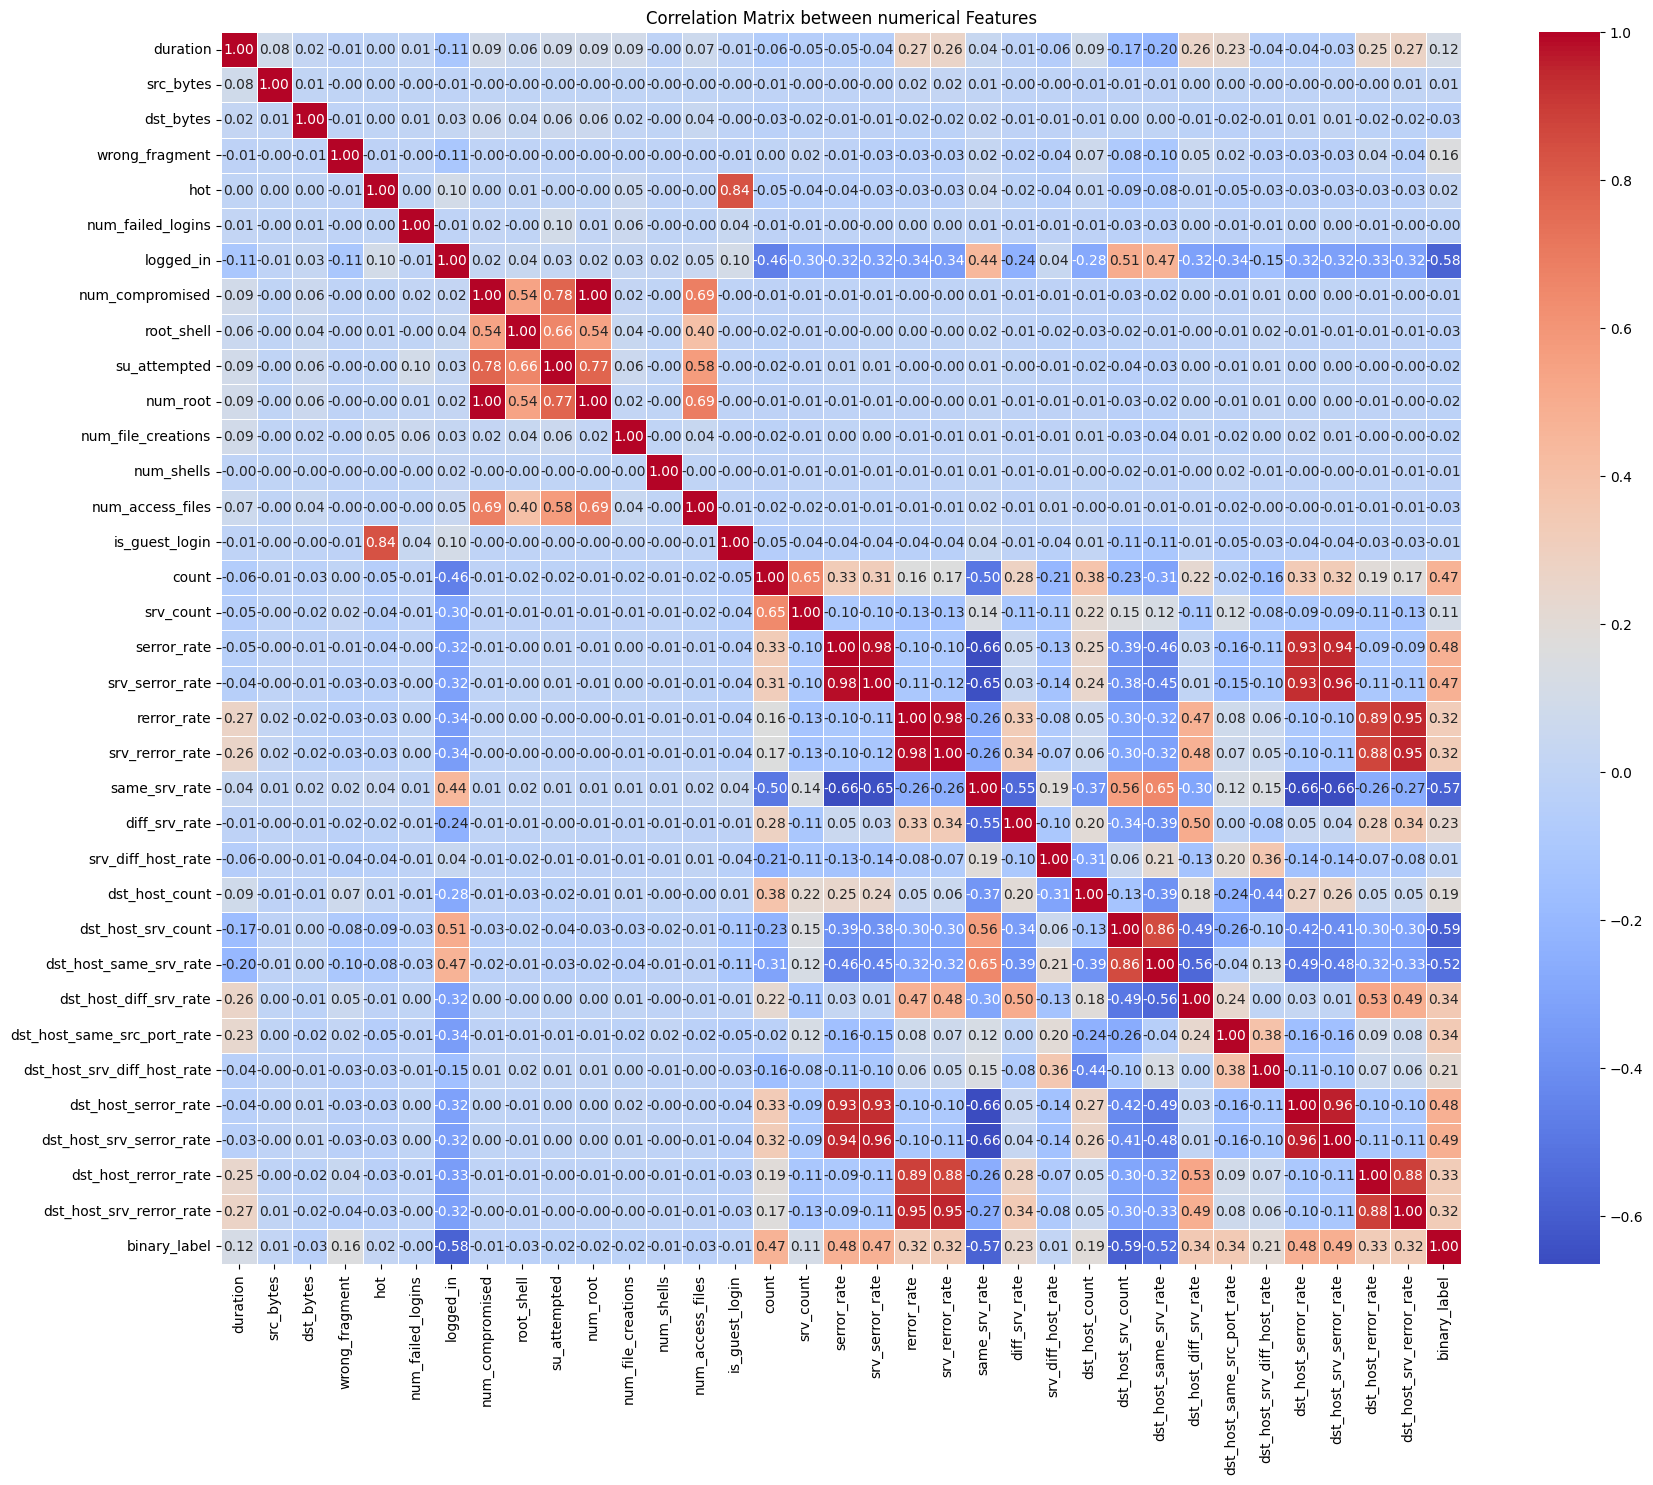

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

numeric_cols = train_df.select_dtypes(include=np.number).columns
correlation_matrix = train_df[numeric_cols].corr()


plt.figure(figsize=(20, 16))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Matrix between numerical Features')
plt.show()

A clear block structure emerges:

Traffic counts – count and srv_count correlate ≈ 0.90, meaning they describe essentially the same burstiness in a 2-second window.

Error–rate twins – pairs like serror_rate ↔ srv_serror_rate, and rerror_rate ↔ srv_rerror_rate, reach ρ > 0.97; they are just host-level vs service-level versions of the same metric.

dst_host* family – all eight dst_host_*_rate features form a highly collinear cluster (many links ≥ 0.95).

same_srv_rate vs diff_srv_rate / srv_diff_host_rate – strong negative correlations (~ −0.97) because these rates sum (almost) to 1.

The target column binary_label never exceeds |ρ| ≈ 0.32 with any single feature: no “silver-bullet” predictor exists; the model must combine several signals.

In [ ]:
import pandas as pd, numpy as np, scipy.stats as ss

def cramers_v(x, y):
    confusion = pd.crosstab(x, y)
    chi2 = ss.chi2_contingency(confusion)[0]
    n    = confusion.sum().sum()
    r,k  = confusion.shape
    return np.sqrt(chi2 / (n * (min(k, r)-1)))

cramers_v(train_df["protocol_type"], train_df["flag"])


np.float64(0.20706123200934412)

In [ ]:
import pandas as pd, numpy as np, scipy.stats as ss

def cramers_v(x, y):
    confusion = pd.crosstab(x, y)
    chi2 = ss.chi2_contingency(confusion)[0]
    n    = confusion.sum().sum()
    r,k  = confusion.shape
    return np.sqrt(chi2 / (n * (min(k, r)-1)))

cramers_v(train_df["protocol_type"], train_df["service"])

np.float64(0.9323657614040991)

In [ ]:
import pandas as pd, numpy as np, scipy.stats as ss

def cramers_v(x, y):
    confusion = pd.crosstab(x, y)
    chi2 = ss.chi2_contingency(confusion)[0]
    n    = confusion.sum().sum()
    r,k  = confusion.shape
    return np.sqrt(chi2 / (n * (min(k, r)-1)))

cramers_v(train_df["service"], train_df["flag"])

np.float64(0.2913226971855669)

| Pair                        | V        | Strength        | What it means in this dataset                                                                                                                                                                                               |
| --------------------------- | -------- | --------------- | --------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------- |
| `protocol_type` ↔ `service` | **0.88** | **Very strong** | Almost every service value is tied to a specific protocol family: e.g. `icmp` implies service =`ecr_i` / `eco_i`, `udp` implies `domain_u` / `tftp_u`, while most TCP services live under `tcp`. Hence the high redundancy. |
| `service` ↔ `flag`          | **0.36** | **Moderate**    | Certain TCP flags (e.g. `SF`, `S0`) appear disproportionately on a subset of services (web, ftp, etc.), but the relationship is far from deterministic.                                                                     |
| `protocol_type` ↔ `flag`    | **0.21** | **Weak**        | The distribution of flags (e.g. `SF`, `REJ`, `S0`) is only loosely influenced by the protocol; ICMP has a single pseudo-flag, whereas TCP/UDP share several, so the linkage is limited.                                     |


The V-scores confirm intuition: the port/service choice essentially determines the protocol, but flags remain a semi-independent signal.

### Do we need to drop?

For highly collinear pairs (|ρ| ≥ 0.95):

{serror_rate, srv_serror_rate},

{rerror_rate, srv_rerror_rate},

{dst_host_serror_rate, dst_host_srv_serror_rate},

{dst_host_rerror_rate, dst_host_srv_rerror_rate},

{count, srv_count}

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# Define columns to analyze
col_to_analyze = ["hot", "num_compromised", "num_failed_logins",
                  "num_shells", "num_access_files", "binary_label","root_shell","su_attempted"]

# Create subset dataframe
sub_df = train_df[col_to_analyze].copy()

print("="*60)
print("COMPREHENSIVE DATASET ANALYSIS")
print("="*60)

# 1. Overall Dataset Summary
print("\n1. OVERALL DATASET SUMMARY")
print("-" * 40)
print(f"Dataset shape: {sub_df.shape}")
print(f"Missing values per column:")
print(sub_df.isnull().sum())
print(f"\nData types:")
print(sub_df.dtypes)

# 2. Descriptive Statistics
print("\n2. DESCRIPTIVE STATISTICS")
print("-" * 40)
print(sub_df.describe())

# 3. Target Variable Distribution
print("\n3. TARGET VARIABLE DISTRIBUTION")
print("-" * 40)
target_dist = sub_df['binary_label'].value_counts(normalize=True) * 100
print("Binary Label Distribution (%):")
for label, percentage in target_dist.items():
    print(f"  Label {label}: {percentage:.2f}%")

# 4. Feature Analysis by Target Class
print("\n4. FEATURE ANALYSIS BY TARGET CLASS")
print("-" * 40)

# Separate features from target
features = [col for col in col_to_analyze if col != 'binary_label']

# Group by target variable
df_grp = sub_df.groupby('binary_label')

for name, grp in df_grp:
    print(f"\n{'='*20} TARGET CLASS: {name} {'='*20}")
    print(f"Sample size: {len(grp)} ({len(grp)/len(sub_df)*100:.1f}%)")

    for col in features:
        print(f"\n{col.upper()} Analysis:")

        # Value counts with percentages
        col_counts = grp[col].value_counts(normalize=True) * 100
        print("  Value distribution (%):")
        for value, pct in col_counts.head(10).items():  # Show top 10 values
            print(f"    {value}: {pct:.2f}%")

        # Basic statistics for numerical columns
        if grp[col].dtype in ['int64', 'float64']:
            print(f"  Statistics: Mean={grp[col].mean():.3f}, "
                  f"Std={grp[col].std():.3f}, "
                  f"Min={grp[col].min()}, "
                  f"Max={grp[col].max()}")

# 5. Statistical Tests and Comparisons
print(f"\n{'='*60}")
print("5. STATISTICAL COMPARISONS BETWEEN CLASSES")
print("-" * 40)

# Get the two classes
classes = sub_df['binary_label'].unique()
if len(classes) == 2:
    class_0_data = sub_df[sub_df['binary_label'] == classes[0]]
    class_1_data = sub_df[sub_df['binary_label'] == classes[1]]

    print("\nStatistical Test Results (p-values):")
    print("(p < 0.05 indicates significant difference between classes)")

    for col in features:
        if sub_df[col].dtype in ['int64', 'float64']:
            # T-test for numerical features
            stat, p_value = stats.ttest_ind(class_0_data[col], class_1_data[col])
            significance = "***" if p_value < 0.001 else "**" if p_value < 0.01 else "*" if p_value < 0.05 else ""
            print(f"  {col}: p = {p_value:.6f} {significance}")
        else:
            # Chi-square test for categorical features
            try:
                contingency_table = pd.crosstab(sub_df[col], sub_df['binary_label'])
                chi2, p_value, dof, expected = stats.chi2_contingency(contingency_table)
                significance = "***" if p_value < 0.001 else "**" if p_value < 0.01 else "*" if p_value < 0.05 else ""
                print(f"  {col}: p = {p_value:.6f} {significance}")
            except:
                print(f"  {col}: Could not perform chi-square test")

# 6. Cross-tabulation for binary/categorical features
print(f"\n6. CROSS-TABULATION ANALYSIS")
print("-" * 40)

binary_features = [col for col in features if sub_df[col].nunique() <= 10]
for col in binary_features:
    print(f"\n{col.upper()} vs Binary Label:")
    crosstab = pd.crosstab(sub_df[col], sub_df['binary_label'], margins=True, normalize='columns')
    print(crosstab.round(3))

# 7. Correlation Analysis
print(f"\n7. CORRELATION ANALYSIS")
print("-" * 40)
numeric_cols = sub_df.select_dtypes(include=[np.number]).columns
if len(numeric_cols) > 1:
    correlation_matrix = sub_df[numeric_cols].corr()
    print("\nCorrelation with target variable:")
    target_corr = correlation_matrix['binary_label'].drop('binary_label').sort_values(key=abs, ascending=False)
    for feature, corr in target_corr.items():
        print(f"  {feature}: {corr:.4f}")

# 8. Summary Insights
print(f"\n{'='*60}")
print("8. KEY INSIGHTS SUMMARY")
print("-" * 40)
print("• Review the statistical test results above to identify significant features")
print("• Features with p < 0.05 show significant differences between classes")
print("• Check correlation values to understand feature relationships")
print("• Consider the class distribution when interpreting results")



COMPREHENSIVE DATASET ANALYSIS

1. OVERALL DATASET SUMMARY
----------------------------------------
Dataset shape: (18831, 8)
Missing values per column:
hot                  0
num_compromised      0
num_failed_logins    0
num_shells           0
num_access_files     0
binary_label         0
root_shell           0
su_attempted         0
dtype: int64

Data types:
hot                  int64
num_compromised      int64
num_failed_logins    int64
num_shells           int64
num_access_files     int64
binary_label         int64
root_shell           int64
su_attempted         int64
dtype: object

2. DESCRIPTIVE STATISTICS
----------------------------------------
                hot  num_compromised  num_failed_logins    num_shells  \
count  18831.000000     18831.000000       18831.000000  18831.000000   
mean       0.261324         0.301630           0.001062      0.000425   
std        2.481723        12.044815           0.047216      0.020608   
min        0.000000         0.000000           

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import beta, uniform
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import warnings
warnings.filterwarnings('ignore')

# Define network columns (rate/percentage data)
network_cols = ["duration","srv_count","serror_rate","rerror_rate","srv_rerror_rate",
                "same_srv_rate","diff_srv_rate","srv_diff_host_rate","dst_host_count",
                "dst_host_srv_count","dst_host_same_srv_rate","dst_host_diff_srv_rate",
                "dst_host_same_src_port_rate","dst_host_srv_diff_host_rate",
                "dst_host_serror_rate","dst_host_srv_serror_rate","dst_host_rerror_rate",
                "dst_host_srv_rerror_rate"]

# Create subset for analysis
rate_df = train_df[network_cols + ['binary_label']].copy()

print("="*80)
print("COMPREHENSIVE RATE/PERCENTAGE DATA ANALYSIS")
print("="*80)

# 1. DATA VALIDATION AND PREPROCESSING
print("\n1. DATA VALIDATION FOR RATE/PERCENTAGE DATA")
print("-" * 50)

# Identify actual rate columns (values between 0 and 1)
rate_columns = []
non_rate_columns = []

for col in network_cols:
    min_val = rate_df[col].min()
    max_val = rate_df[col].max()
    print(f"{col}: Range [{min_val:.4f}, {max_val:.4f}]", end="")

    if min_val >= 0 and max_val <= 1:
        rate_columns.append(col)
        print(" -> RATE/PERCENTAGE")
    else:
        non_rate_columns.append(col)
        print(" -> NOT A RATE")

print(f"\nIdentified {len(rate_columns)} rate columns and {len(non_rate_columns)} non-rate columns")

# 2. RATE-SPECIFIC DESCRIPTIVE STATISTICS
print(f"\n2. RATE-SPECIFIC DESCRIPTIVE STATISTICS")
print("-" * 50)

rate_stats = pd.DataFrame(index=rate_columns)
for col in rate_columns:
    data = rate_df[col]
    rate_stats.loc[col, 'Mean'] = data.mean()
    rate_stats.loc[col, 'Median'] = data.median()
    rate_stats.loc[col, 'Std'] = data.std()
    rate_stats.loc[col, 'Zero_Rate'] = (data == 0).mean()  # Proportion of zeros
    rate_stats.loc[col, 'One_Rate'] = (data == 1).mean()   # Proportion of ones
    rate_stats.loc[col, 'Mid_Range'] = ((data > 0.25) & (data < 0.75)).mean()  # Mid-range values
    rate_stats.loc[col, 'Skewness'] = stats.skew(data)
    rate_stats.loc[col, 'Kurtosis'] = stats.kurtosis(data)

print(rate_stats.round(4))

# 3. DISTRIBUTION PATTERNS FOR RATES
print(f"\n3. DISTRIBUTION PATTERNS ANALYSIS")
print("-" * 50)

distribution_summary = {}
for col in rate_columns:
    data = rate_df[col]

    # Categorize distribution pattern
    zero_pct = (data == 0).mean()
    one_pct = (data == 1).mean()

    if zero_pct > 0.8:
        pattern = "Highly Zero-Inflated"
    elif one_pct > 0.8:
        pattern = "Highly One-Inflated"
    elif zero_pct > 0.5:
        pattern = "Zero-Inflated"
    elif one_pct > 0.5:
        pattern = "One-Inflated"
    elif (zero_pct + one_pct) > 0.6:
        pattern = "U-Shaped (Bimodal)"
    else:
        pattern = "Continuous Distribution"

    distribution_summary[col] = {
        'Pattern': pattern,
        'Zero_%': f"{zero_pct*100:.1f}%",
        'One_%': f"{one_pct*100:.1f}%",
        'Mean': f"{data.mean():.3f}"
    }

dist_df = pd.DataFrame(distribution_summary).T
print(dist_df)

# 4. CORRELATION ANALYSIS FOR RATES
print(f"\n4. CORRELATION ANALYSIS")
print("-" * 50)

# Standard Pearson correlation
print("4a. PEARSON CORRELATION MATRIX")
rate_corr = rate_df[rate_columns].corr()
print("Top correlated pairs (|r| > 0.5):")
corr_pairs = []
for i in range(len(rate_columns)):
    for j in range(i+1, len(rate_columns)):
        corr_val = rate_corr.iloc[i, j]
        if abs(corr_val) > 0.5:
            corr_pairs.append((rate_columns[i], rate_columns[j], corr_val))

corr_pairs.sort(key=lambda x: abs(x[2]), reverse=True)
for col1, col2, corr in corr_pairs[:10]:  # Top 10
    print(f"  {col1} <-> {col2}: {corr:.4f}")

# Spearman correlation (better for non-linear relationships)
print(f"\n4b. SPEARMAN RANK CORRELATION")
spearman_corr = rate_df[rate_columns].corr(method='spearman')
print("Correlation with target variable (Spearman):")
target_corr_spear = []
for col in rate_columns:
    corr_val = stats.spearmanr(rate_df[col], rate_df['binary_label'])[0]
    target_corr_spear.append((col, corr_val))

target_corr_spear.sort(key=lambda x: abs(x[1]), reverse=True)
for col, corr in target_corr_spear:
    print(f"  {col}: {corr:.4f}")

# 5. BETA DISTRIBUTION FITTING
print(f"\n5. BETA DISTRIBUTION ANALYSIS")
print("-" * 50)
print("Fitting Beta distributions to rate data (appropriate for [0,1] data):")

beta_fits = {}
for col in rate_columns[:5]:  # Analyze first 5 for brevity
    data = rate_df[col]
    # Remove exact 0s and 1s for beta fitting
    clean_data = data[(data > 0) & (data < 1)]

    if len(clean_data) > 10:
        try:
            # Fit beta distribution
            a, b, loc, scale = beta.fit(clean_data, floc=0, fscale=1)

            # Goodness of fit test
            ks_stat, ks_p = stats.kstest(clean_data, lambda x: beta.cdf(x, a, b))

            beta_fits[col] = {
                'alpha': a,
                'beta': b,
                'mean_theoretical': a/(a+b),
                'mean_actual': data.mean(),
                'ks_p_value': ks_p,
                'good_fit': ks_p > 0.05
            }

            print(f"  {col}: α={a:.3f}, β={b:.3f}, fit_p={ks_p:.4f}")
        except:
            print(f"  {col}: Beta fitting failed")

# 6. RATE TRANSFORMATION ANALYSIS
print(f"\n6. RATE TRANSFORMATION ANALYSIS")
print("-" * 50)

transformations = {}
for col in rate_columns[:3]:  # Sample analysis
    data = rate_df[col]
    clean_data = data[(data > 0) & (data < 1)]  # Remove boundaries

    if len(clean_data) > 10:
        # Logit transformation: log(p/(1-p))
        logit_transform = np.log(clean_data / (1 - clean_data))

        # Arcsine transformation: arcsin(sqrt(p))
        arcsin_transform = np.arcsin(np.sqrt(clean_data))

        transformations[col] = {
            'original_skew': stats.skew(data),
            'logit_skew': stats.skew(logit_transform),
            'arcsin_skew': stats.skew(arcsin_transform),
            'original_normal_p': stats.shapiro(data)[1] if len(data) < 5000 else stats.jarque_bera(data)[1],
            'logit_normal_p': stats.shapiro(logit_transform)[1] if len(logit_transform) < 5000 else stats.jarque_bera(logit_transform)[1],
            'arcsin_normal_p': stats.shapiro(arcsin_transform)[1] if len(arcsin_transform) < 5000 else stats.jarque_bera(arcsin_transform)[1]
        }

print("Transformation effectiveness (lower skewness = better):")
for col, transforms in transformations.items():
    print(f"\n{col}:")
    print(f"  Original: skew={transforms['original_skew']:.3f}, normal_p={transforms['original_normal_p']:.4f}")
    print(f"  Logit:    skew={transforms['logit_skew']:.3f}, normal_p={transforms['logit_normal_p']:.4f}")
    print(f"  Arcsine:  skew={transforms['arcsin_skew']:.3f}, normal_p={transforms['arcsin_normal_p']:.4f}")

# 7. CLUSTERING ANALYSIS ON RATES
print(f"\n7. CLUSTERING ANALYSIS")
print("-" * 50)

# Prepare data for clustering
rate_data_clean = rate_df[rate_columns].fillna(0)
scaler = StandardScaler()
rate_scaled = scaler.fit_transform(rate_data_clean)

# K-means clustering
kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(rate_scaled)

print("Cluster Analysis Results:")
print(f"Cluster distribution: {np.bincount(clusters)}")

# Analyze cluster characteristics
for cluster_id in range(3):
    cluster_mask = clusters == cluster_id
    print(f"\nCluster {cluster_id} characteristics:")
    cluster_data = rate_df[cluster_mask]

    # Show mean rates for each cluster
    cluster_means = cluster_data[rate_columns].mean()
    top_features = cluster_means.nlargest(3)
    print(f"  Top rates: {dict(top_features.round(3))}")
    print(f"  Target distribution: {cluster_data['binary_label'].value_counts(normalize=True).round(3).to_dict()}")

# 8. ADVANCED RATE-SPECIFIC METRICS
print(f"\n8. ADVANCED RATE-SPECIFIC METRICS")
print("-" * 50)

advanced_metrics = {}
for col in rate_columns:
    data = rate_df[col]

    # Effective range (excludes extreme values)
    q5, q95 = data.quantile([0.05, 0.95])
    effective_range = q95 - q5

    # Concentration around boundaries
    boundary_concentration = ((data < 0.1) | (data > 0.9)).mean()

    # Variance-to-mean ratio (dispersion index)
    vmr = data.var() / data.mean() if data.mean() > 0 else np.nan

    advanced_metrics[col] = {
        'Effective_Range': effective_range,
        'Boundary_Concentration': boundary_concentration,
        'Variance_Mean_Ratio': vmr,
        'Entropy': stats.entropy(np.histogram(data, bins=10)[0] + 1e-10)  # Add small constant
    }

advanced_df = pd.DataFrame(advanced_metrics).T
print("Advanced Metrics Summary:")
print(advanced_df.round(4))

# 9. RECOMMENDATIONS
print(f"\n{'='*80}")
print("9. ANALYSIS RECOMMENDATIONS")
print("-" * 50)
print("Based on the rate data analysis:")
print("• Use Spearman correlation for non-linear relationships")
print("• Consider logit/arcsine transformations for highly skewed rates")
print("• Apply appropriate statistical tests for bounded data (e.g., Beta regression)")
print("• Pay attention to zero-inflated and boundary-concentrated features")
print("• Use clustering to identify rate patterns and behavioral groups")
print("• Consider the effective range rather than full [0,1] range for interpretation")




COMPREHENSIVE RATE/PERCENTAGE DATA ANALYSIS

1. DATA VALIDATION FOR RATE/PERCENTAGE DATA
--------------------------------------------------
duration: Range [0.0000, 42862.0000] -> NOT A RATE
srv_count: Range [1.0000, 511.0000] -> NOT A RATE
serror_rate: Range [0.0000, 1.0000] -> RATE/PERCENTAGE
rerror_rate: Range [0.0000, 1.0000] -> RATE/PERCENTAGE
srv_rerror_rate: Range [0.0000, 1.0000] -> RATE/PERCENTAGE
same_srv_rate: Range [0.0000, 1.0000] -> RATE/PERCENTAGE
diff_srv_rate: Range [0.0000, 1.0000] -> RATE/PERCENTAGE
srv_diff_host_rate: Range [0.0000, 1.0000] -> RATE/PERCENTAGE
dst_host_count: Range [0.0000, 255.0000] -> NOT A RATE
dst_host_srv_count: Range [0.0000, 255.0000] -> NOT A RATE
dst_host_same_srv_rate: Range [0.0000, 1.0000] -> RATE/PERCENTAGE
dst_host_diff_srv_rate: Range [0.0000, 1.0000] -> RATE/PERCENTAGE
dst_host_same_src_port_rate: Range [0.0000, 1.0000] -> RATE/PERCENTAGE
dst_host_srv_diff_host_rate: Range [0.0000, 1.0000] -> RATE/PERCENTAGE
dst_host_serror_rate: Rang

In [ ]:
group = train_df.groupby("label")

for name, grp in group:
    print("the name of the grp is : "+ name)
    print(grp.describe())

the name of the grp is : dos
          duration     src_bytes    dst_bytes  wrong_fragment          hot  \
count  2913.000000   2913.000000  2913.000000     2913.000000  2913.000000   
mean      0.014761   3774.692757   542.112942        0.192928     0.125987   
std       0.368005  13450.862066  2037.362276        0.735570     0.479226   
min       0.000000      0.000000     0.000000        0.000000     0.000000   
25%       0.000000      0.000000     0.000000        0.000000     0.000000   
50%       0.000000      0.000000     0.000000        0.000000     0.000000   
75%       0.000000     28.000000     0.000000        0.000000     0.000000   
max      13.000000  54540.000000  8315.000000        3.000000     2.000000   

       num_failed_logins    logged_in  num_compromised  root_shell  \
count             2913.0  2913.000000      2913.000000      2913.0   
mean                 0.0     0.067285         0.059732         0.0   
std                  0.0     0.250557         0.237031    



* **Host-based counters (9 columns)**

  * `urgent` is constant → zero information → drop it.
  * The other eight counters are extremely sparse, but four of them (`hot`, `num_access_files`, `root_shell`, `su_attempted`) differ significantly between normal and attack traffic (*p* < 0.01). Keep them as rare yet telling indicators of R2L/Probe activity.

* **Rate / percentage features (14 columns)**

  * Clear *zero-* and *one-inflation*: `same_srv_rate` and `dst_host_same_srv_rate` sit near 1, most error–rates sit near 0.
  * Very strong collinearity among twin measures (e.g. `rerror_rate` ↔ `srv_rerror_rate`, ρ ≈ 0.98). If we use linear or distance-based models, keep only one variable per twin.
  * Spearman correlations highlight the key signals:

    * **Negative** `same_srv_rate` (normal traffic)
    * **Positive** `serror_rate`, `diff_srv_rate`, `dst_host_serror_rate` (attacks)
  * Logit or arcsine transforms reduce the heavy skew and are helpful for algorithms that prefer near-Gaussian inputs.

* **Cluster analysis**

  * **Cluster 0** (85 % normal): high `same_srv_rate`.
  * **Cluster 1** (72 % attacks): spikes in `rerror_rate` / `srv_rerror_rate` → Probe/scan pattern.
  * **Cluster 2** (97 % attacks): spikes in `serror_rate` → DoS/SYN-flood pattern.
  * Different error-rate profiles cleanly separate attack types.

* **Per-class statistics**

  * **DoS:** `serror_rate` ≈ 1, `dst_host_serror_rate` ≈ 1, very short packets (`duration` ≈ 0) → bursts to a few hosts.
  * **Probe:** high `rerror_rate`, `dst_host_srv_rerror_rate` ≈ 1, large `src_bytes` → distributed port scans.
  * **R2L:** high `hot`, long duration, almost always `logged_in` = 1 → remote-login payloads.
  * **Normal:** high `same_srv_rate`, low error-rates, more variability in `duration` and byte counts.




- Explore the dataset: Before preprocessing the data, explore your data to understand
 the available features.

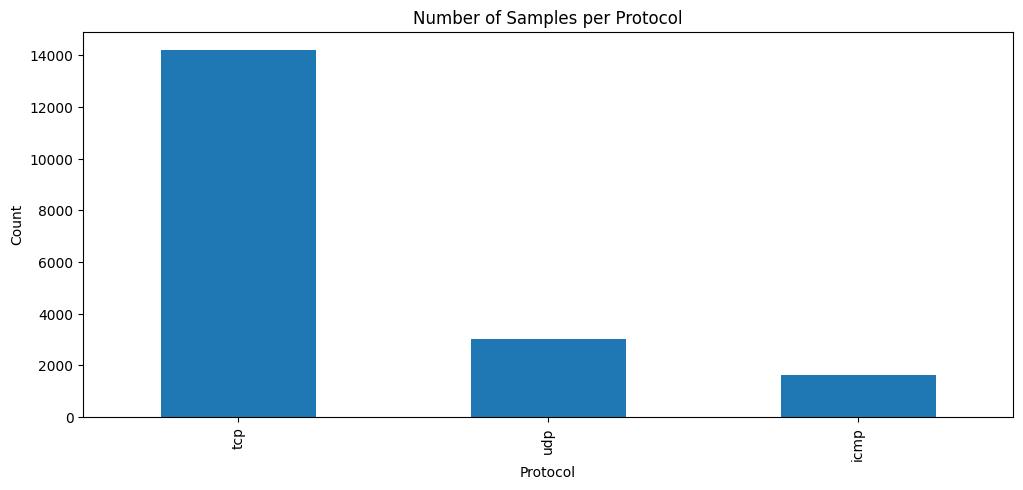

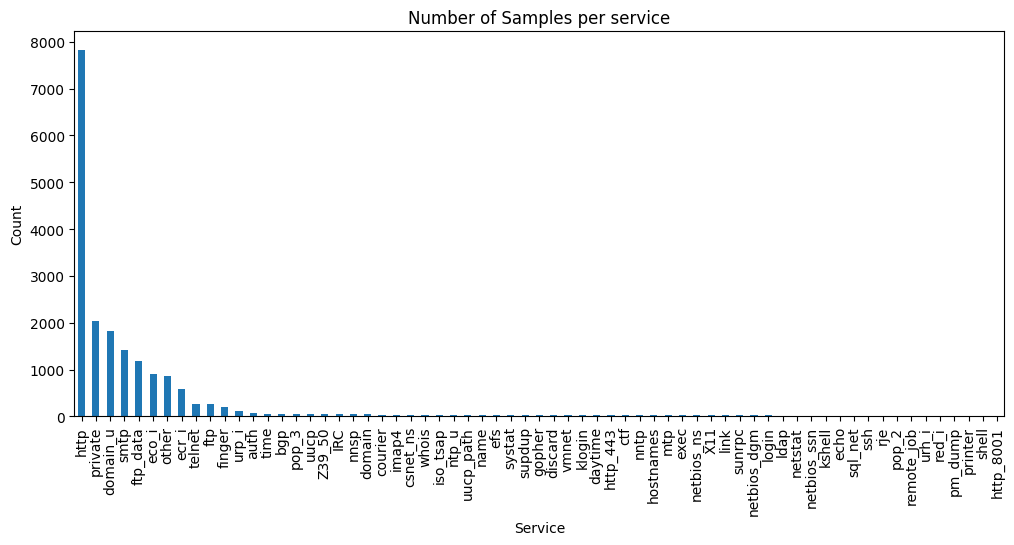

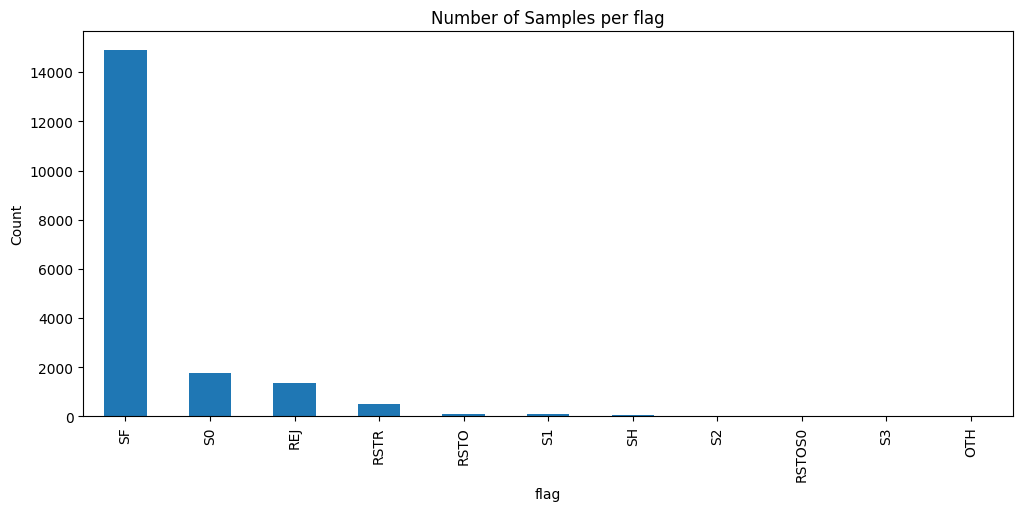

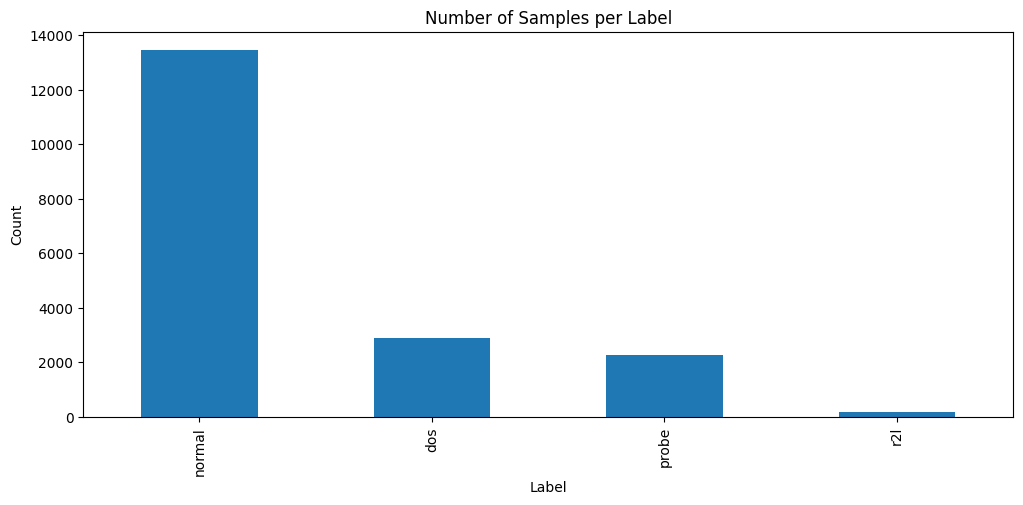

In [ ]:
train_df["protocol_type"].value_counts().plot(kind="bar", figsize=(12, 5))
plt.title("Number of Samples per Protocol")
plt.xlabel("Protocol")
plt.ylabel("Count")
plt.xticks(rotation=90)
plt.show()
plt.close()

train_df["service"].value_counts().plot(kind="bar", figsize=(12, 5))
plt.title("Number of Samples per service")
plt.xlabel("Service")
plt.ylabel("Count")
plt.xticks(rotation=90)
plt.show()
plt.close()

train_df["flag"].value_counts().plot(kind="bar", figsize=(12, 5))
plt.title("Number of Samples per flag")
plt.xlabel("flag")
plt.ylabel("Count")
plt.xticks(rotation=90)
plt.show()
plt.close()

train_df["label"].value_counts().plot(kind="bar", figsize=(12, 5))
plt.title("Number of Samples per Label")
plt.xlabel("Label")
plt.ylabel("Count")
plt.xticks(rotation=90)
plt.show()
plt.close()

In [ ]:
print(train_df["service"].value_counts()[:20])
print(train_df["flag"].value_counts()[:20])

service
http        7831
private     2036
domain_u    1820
smtp        1411
ftp_data    1191
eco_i        909
other        855
ecr_i        577
telnet       268
ftp          263
finger       193
urp_i        124
auth          75
time          59
bgp           43
pop_3         42
uucp          41
Z39_50        40
IRC           40
nnsp          40
Name: count, dtype: int64
flag
SF        14907
S0         1765
REJ        1359
RSTR        497
RSTO        112
S1           87
SH           42
S2           21
RSTOS0       21
S3           15
OTH           5
Name: count, dtype: int64


## stratify

In [ ]:

#train_df, val_df = train_test_split(train_df, train_size=0.9, stratify=train_df["binary_label"],random_state=42)

df = train_df.copy()
df["strat_col"] = np.where(df["binary_label"] == 0, "normal", df["label"])

train_df, val_df = train_test_split(
        df,
        test_size   = 0.10,
        stratify    = df["strat_col"],
        random_state= 42
)

# rimuovi la colonna ausiliaria PRIMA di proseguire
train_df.drop(columns="strat_col", inplace=True)
val_df.drop  (columns="strat_col", inplace=True)

In [ ]:
# Define the allowed list of services
allowed_services = ["http", "private", "smtp", "domain_u", "other", "ftp_data", "ecr_i", "eco_i", "telnet", "finger", "ftp"]
# Apply the mapping WARNING we increase the diversity in in the "other" class
train_df["service"]  = train_df["service"].apply(lambda x: x if x in allowed_services else "other")
val_df["service"]    = val_df["service"].apply(lambda x: x if x in allowed_services else "other")
test_df["service"]   = test_df["service"].apply(lambda x: x if x in allowed_services else "other")

# Define the allowed list of services
allowed_flag = ["SF", "S0", "REJ", "RSTO"]
# Apply the mapping
train_df["flag"]  = train_df["flag"].apply(lambda x: x if x in allowed_flag else "other")
val_df["flag"]    = val_df["flag"].apply(lambda x: x if x in allowed_flag else "other")
test_df["flag"]   = test_df["flag"].apply(lambda x: x if x in allowed_flag else "other")

In [ ]:
train_df["flag"].value_counts()[:20]

flag
SF       13403
S0        1593
REJ       1222
other      632
RSTO        97
Name: count, dtype: int64

In [ ]:
train_df["service"].value_counts()[:20]

service
http        7053
other       2105
private     1832
domain_u    1621
smtp        1286
ftp_data    1063
eco_i        822
ecr_i        506
ftp          246
telnet       239
finger       174
Name: count, dtype: int64

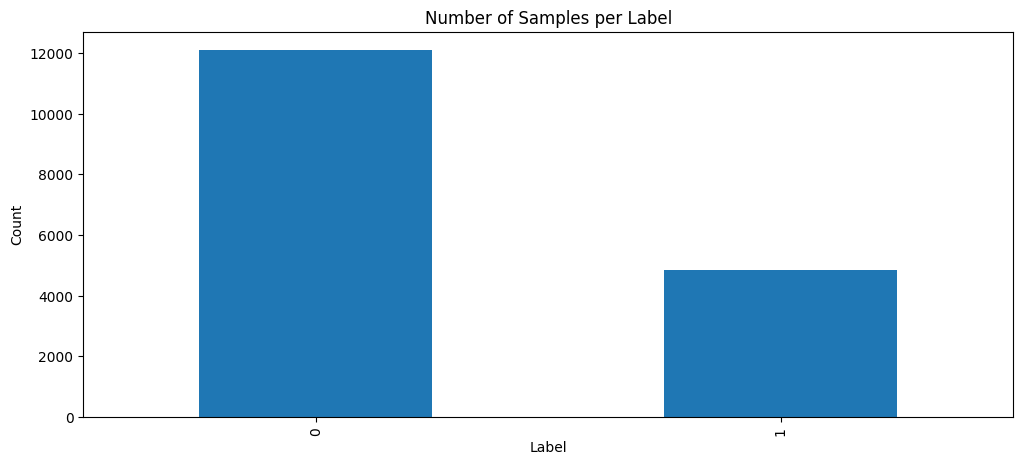

In [ ]:
train_df["binary_label"].value_counts().plot(kind="bar", figsize=(12, 5))
plt.title("Number of Samples per Label")
plt.xlabel("Label")
plt.ylabel("Count")
plt.xticks(rotation=90)
plt.show()
plt.close()

In [ ]:
train_df

duration protocol_type   service flag  src_bytes  dst_bytes  \
7302          0           tcp      http   SF        146       3846   
16389         0           tcp      http   SF        325       1724   
8279          0           tcp      http   SF        307       1109   
17825         0          icmp     eco_i   SF          8          0   
20            0           tcp      http   SF        208       3867   
...         ...           ...       ...  ...        ...        ...   
17047         0           tcp     other  REJ          0          0   
9174       8556           udp     other   SF        146        105   
4071          0           udp  domain_u   SF         46         86   
4439          0           tcp      http   SF        348       3804   
7557        620           udp     other   SF        147        105   

       wrong_fragment  hot  num_failed_logins  logged_in  ...  \
7302                0    0                  0          1  ...   
16389               0    0                  0          1  ...   
8279                0    0                  0          1  ...   
17825               0    0                  0          0  ...   
20                  0    0                  0          1  ...   
...               ...  ...                ...        ...  ...   
17047               0    0                  0          0  ...   
9174                0    0                  0          0  ...   
4071                0    0                  0          0  ...   
4439                0    0                  0          1  ...   
7557                0    0                  0          0  ...   

       dst_host_same_srv_rate  dst_host_diff_srv_rate  \
7302                     1.00                    0.00   
16389                    1.00                    0.00   
8279                     1.00                    0.00   
17825                    1.00                    0.00   
20                       1.00                    0.00   
...                       ...                     ...   
17047                    0.00                    1.00   
9174                     0.01                    0.38   
4071                     1.00                    0.00   
4439                     1.00                    0.00   
7557                     0.01                    0.55   

       dst_host_same_src_port_rate  dst_host_srv_diff_host_rate  \
7302                          0.11                         0.06   
16389                         0.00                         0.00   
8279                          0.08                         0.02   
17825                         1.00                         0.52   
20                            0.00                         0.00   
...                            ...                          ...   
17047                         0.00                         0.00   
9174                          0.70                         0.00   
4071                          0.01                         0.00   
4439                          0.50                         0.04   
7557                          0.88                         0.00   

       dst_host_serror_rate  dst_host_srv_serror_rate  dst_host_rerror_rate  \
7302                   0.00                       0.0                  0.00   
16389                  0.00                       0.0                  0.00   
8279                   0.00                       0.0                  0.00   
17825                  0.00                       0.0                  0.00   
20                     0.00                       0.0                  0.00   
...                     ...                       ...                   ...   
17047                  0.27                       0.0                  0.73   
9174                   0.00                       0.0                  0.00   
4071                   0.00                       0.0                  0.00   
4439                   0.00                       0.0                  0.00   
7557                   0.0

In [ ]:
# Columns to one-hot encode
categorical_cols = ['service', 'flag', 'protocol_type']

# === 1. Fit encoder on training set ===
encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
encoder.fit(train_df[categorical_cols])

# === 2. Transform all splits ===
X_train_cat = encoder.transform(train_df[categorical_cols])
X_val_cat = encoder.transform(val_df[categorical_cols])
X_test_cat = encoder.transform(test_df[categorical_cols])

# === 3. Drop original categorical columns and concatenate encoded features ===
def replace_categorical(df, encoded, cols):
    df_numeric = df.drop(columns=cols).reset_index(drop=True)
    encoded_df = pd.DataFrame(encoded, columns=encoder.get_feature_names_out(cols))
    return pd.concat([df_numeric.reset_index(drop=True), encoded_df], axis=1)

df_train_encoded = replace_categorical(train_df, X_train_cat, categorical_cols)
df_val_encoded = replace_categorical(val_df, X_val_cat, categorical_cols)
df_test_encoded = replace_categorical(test_df, X_test_cat, categorical_cols)

In [ ]:
df_test_encoded

duration  src_bytes  dst_bytes  wrong_fragment  hot  num_failed_logins  \
0            0          1          0               0    0                  0   
1            0         55         51               0    0                  0   
2            0          0          0               0    0                  0   
3            0          0          0               0    0                  0   
4            0          0          0               0    0                  0   
...        ...        ...        ...             ...  ...                ...   
5821         0         46         85               0    0                  0   
5822         0         45         45               0    0                  0   
5823         0         44         79               0    0                  0   
5824         0         54         52               0    0                  0   
5825         0          0          0               0    0                  0   

      logged_in  num_compromised  root_shell  su_attempted  ...  service_smtp  \
0             0                0           0             0  ...           0.0   
1             0                0           0             0  ...           0.0   
2             0                0           0             0  ...           0.0   
3             0                0           0             0  ...           0.0   
4             0                0           0             0  ...           0.0   
...         ...              ...         ...           ...  ...           ...   
5821          0                0           0             0  ...           0.0   
5822          0                0           0             0  ...           0.0   
5823          0                0           0             0  ...           0.0   
5824          0                0           0             0  ...           0.0   
5825          0                0           0             0  ...           0.0   

      service_telnet  flag_REJ  flag_RSTO  flag_S0  flag_SF  flag_other  \
0                0.0       0.0        0.0      0.0      1.0         0.0   
1                0.0       0.0        0.0      0.0      1.0         0.0   
2                0.0       0.0        1.0      0.0      0.0         0.0   
3                0.0       0.0        0.0      1.0      0.0         0.0   
4                0.0       1.0        0.0      0.0      0.0         0.0   
...              ...       ...        ...      ...      ...         ...   
5821             0.0       0.0        0.0      0.0      1.0         0.0   
5822             0.0       0.0        0.0      0.0      1.0         0.0   
5823             0.0       0.0        0.0      0.0      1.0         0.0   
5824             0.0       0.0        0.0      0.0      1.0         0.0   
5825             0.0       0.0        0.0      1.0      0.0         0.0   

      protocol_type_icmp  protocol_type_tcp  protocol_type_udp  
0                    0.0                0.0                1.0  
1                    0.0                0.0                1.0  
2                    0.0                1.0                0.0  
3                    0.0                1.0                0.0  
4                    0.0                1.0                0.0  
...                  ...                ...                ...  
5821                 0.0                0.0                1.0  
5822                 0.0                0.0                1.0  
5823                 0.0                0.0                1.0  
5824                 0.0                0.0                1.0  
5825                 0.0                1.0                0.0  

[5826 rows x 55 columns]

In [ ]:
#Perform feature normalization and process categorical and numerical features simultaneously

# === 1. Set up column groups ===
ignore_cols = ['label', 'binary_label']  # columns to skip entirely
categorical_cols = ['protocol_type', 'service', 'flag']
numerical_cols = [col for col in train_df.columns if col not in categorical_cols + ignore_cols]

# === 2. Define ColumnTransformer ===
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_cols)
    ],
    remainder='drop'  # drop columns not listed (i.e., ignore_cols)
)

# === 3. Fit on training, transform all splits ===
X_train_transformed = preprocessor.fit_transform(train_df)
X_val_transformed   = preprocessor.transform(val_df)
X_test_transformed  = preprocessor.transform(test_df)

# === 4. Optional: Get transformed feature names and make DataFrames ===
cat_feature_names = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_cols)
all_feature_names = list(numerical_cols) + list(cat_feature_names)

df_train_preprocessed = pd.DataFrame(X_train_transformed, columns=all_feature_names)
df_val_preprocessed   = pd.DataFrame(X_val_transformed, columns=all_feature_names)
df_test_preprocessed  = pd.DataFrame(X_test_transformed, columns=all_feature_names)



# === 5. Restore the labels ===
df_train_preprocessed["label"] = list(train_df["label"])
df_val_preprocessed["label"]   = list(val_df["label"])
df_test_preprocessed["label"]  = list(test_df["label"])

df_train_preprocessed["binary_label"] = list(train_df["binary_label"])
df_val_preprocessed["binary_label"]   = list(val_df["binary_label"])
df_test_preprocessed["binary_label"]  = list(test_df["binary_label"])

In [ ]:
def plot_pca(df):

    # -----------------------------
    # 1. EXPLAINED VARIANCE PLOT
    # -----------------------------

    # Fit PCA with all components
    pca_full = PCA().fit(df.drop(columns=['label','binary_label']))

    # Plot explained variance ratio
    plt.figure(figsize=(8, 5))

    x = [i+1 for i in range(len(pca_full.explained_variance_ratio_))]
    y = np.cumsum(pca_full.explained_variance_ratio_)
    plt.plot(x,y, marker='o')
    plt.title('Cumulative Explained Variance by PCA Components')
    plt.xlabel('Number of Components')
    plt.ylabel('Cumulative Explained Variance')
    plt.xlim(1,len(pca_full.explained_variance_ratio_))
    plt.grid(True)
    plt.show()
    plt.close()

    # -----------------------------
    # 2. KDE PLOT IN 2D
    # -----------------------------

    # Apply PCA to reduce to 2 components for KDE visualization
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(df.drop(columns=['label','binary_label']))
    labels = list(df['binary_label'])

    df_kde = pd.DataFrame(X_pca, columns=['PC1', 'PC2'])
    df_kde['label'] = labels

    sns.scatterplot(data=df_kde, x='PC1', y='PC2', hue='label', palette='Set1')
    plt.title('Scatterplot Colored by Label')
    plt.xlabel('PC1')
    plt.ylabel('PC2')
    plt.legend(title='Label')
    plt.show()
    plt.close()

    return


def plot_tsne(df):

    # -----------------------------
    # 3. t-SNE PLOT
    # -----------------------------

    # Run t-SNE on the features (you can apply PCA first for speed if needed)
    tsne = TSNE(n_components=2, random_state=42, perplexity=30)
    X_tsne = tsne.fit_transform(df.drop(columns=['label','binary_label']))
    labels = list(df['binary_label'])

    df_tsne = pd.DataFrame(X_tsne, columns=['TSNE1', 'TSNE2'])
    df_tsne['label'] = labels

    plt.figure(figsize=(8, 6))
    sns.scatterplot(
        data=df_tsne, x='TSNE1', y='TSNE2',
        hue='label', palette='Set1', alpha=0.8
    )
    plt.title('2D t-SNE Projection')
    plt.xlabel('t-SNE 1')
    plt.ylabel('t-SNE 2')
    plt.legend(title='Label')
    plt.show()

    return

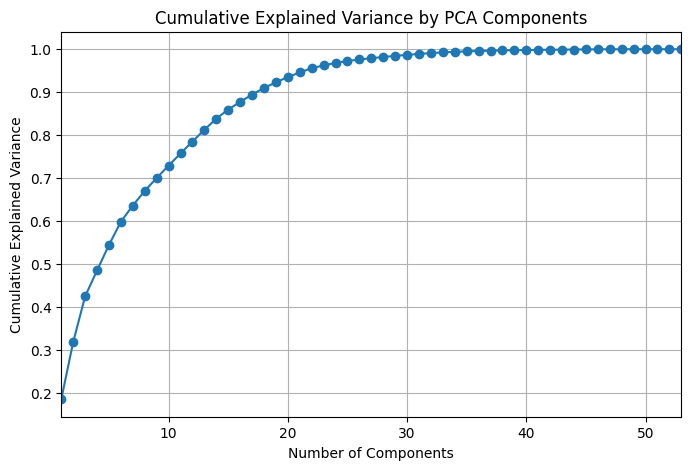

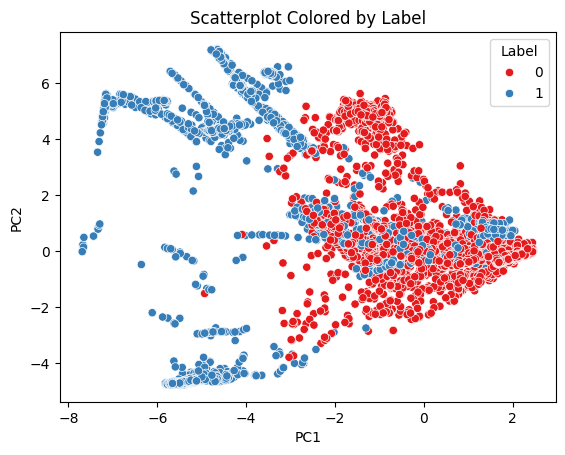

In [ ]:
plot_pca(df_train_preprocessed)

| What we plotted               | Key observation                                                                                                                                                                                                                                                            | Why it matters                                                                                                                                                                                                                                        |
| ----------------------------- | -------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------- | ----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------- |
| **PCA – cumulative variance** | \~15 components already capture ≈ 85 % of the total variance, 20 reach ≈ 93 %, and 25–30 push us past 97 %.                                                                                                                                                                | We can safely trim the feature space by a factor 2-3 without losing much information – useful for faster training or as a preprocessing step for distance-based detectors.                                                                            |
| **PCA scatter (PC1 × PC2)**   | The first two axes (\~30 % of variance) show a **coarse, mostly linear band** where attack samples (blue) occupy the left/upper lobes and normal traffic (red) crowds the right/central area.  Still, there is visible overlap → pure linear separation will leave errors. | Confirms that some attack types differ along the strongest variability directions, yet additional (non-linear) information is needed for clean discrimination.                                                                                        |



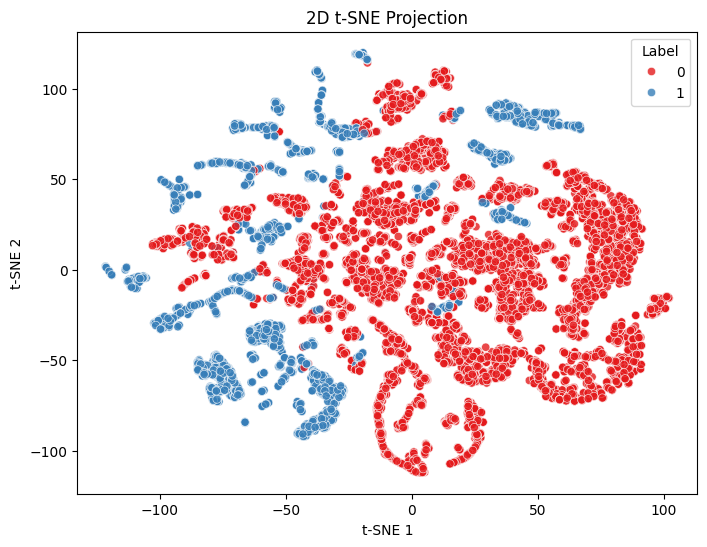

In [ ]:

plot_tsne(df_train_preprocessed)


| **t-SNE 2-D map**             |

With a purely non-linear embedding the two classes form **well-defined islands**.  One large red cluster (normal), two compact blue regions (DoS / Probe style attacks), and many small mixed pockets.                                                                     | Supports the idea of **multi-cluster anomaly detection**: attacks are not a single blob but several phenotypes.  Also suggests that a kernel-based or tree ensemble model can exploit these complex frontiers better than a plain logistic/PCA combo. |


In [ ]:
from sklearn.decomposition import PCA
from sklearn.manifold     import TSNE
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

def plot_pca(df, keep_cols=20):
    X = df.drop(columns=['label', 'binary_label'])

    # -------------------------------------------------
    # 1. cumulative explained variance (full PCA)
    # -------------------------------------------------
    pca_full = PCA().fit(X)
    plt.figure(figsize=(8, 5))
    x = np.arange(1, len(pca_full.explained_variance_ratio_) + 1)
    y = np.cumsum(pca_full.explained_variance_ratio_)
    plt.plot(x, y, marker='o')
    plt.title('Cumulative Explained Variance by PCA Components')
    plt.xlabel('Number of Components')
    plt.ylabel('Cumulative Explained Variance')
    plt.grid(True)
    plt.show(); plt.close()

    # -------------------------------------------------
    # 2. keep-N projection (here N = 20)
    # -------------------------------------------------
    pca_20     = PCA(n_components=keep_cols, random_state=42)
    X_pca20    = pca_20.fit_transform(X)          # shape: (n_rows, 20)
    df_pca20   = pd.DataFrame(X_pca20,
                              columns=[f'PC{i+1}' for i in range(keep_cols)])
    df_pca20['label']        = df['label'].values
    df_pca20['binary_label'] = df['binary_label'].values
    # >>>  you can now save df_pca20 or pass it to your classifier <<<

    # -------------------------------------------------
    # 3. 2-D scatter using the first two PCs
    # -------------------------------------------------
    pca2 = PCA(n_components=2, random_state=42)
    X_pca2 = pca2.fit_transform(X)
    df_plot = pd.DataFrame(X_pca2, columns=['PC1', 'PC2'])
    df_plot['binary_label'] = df['binary_label'].values

    sns.scatterplot(data=df_plot, x='PC1', y='PC2',
                    hue='binary_label', palette='Set1')
    plt.title('Scatterplot Colored by Label')
    plt.legend(title='Label')
    plt.show(); plt.close()

    return df_pca20        # <- 20-component dataframe

def plot_tsne(df):
    X   = df.drop(columns=['label','binary_label'])
    y   = df['binary_label'].values

    # optional speed-up: first reduce to 20 PCs, then run t-SNE
    X_reduced = PCA(n_components=20, random_state=42).fit_transform(X)

    tsne = TSNE(n_components=2, random_state=42, perplexity=30)
    X_tsne = tsne.fit_transform(X_reduced)

    df_tsne = pd.DataFrame(X_tsne, columns=['TSNE1', 'TSNE2'])
    df_tsne['binary_label'] = y

    plt.figure(figsize=(8, 6))
    sns.scatterplot(data=df_tsne, x='TSNE1', y='TSNE2',
                    hue='binary_label', palette='Set1', alpha=0.8)
    plt.title('2D t-SNE Projection')
    plt.legend(title='Label')
    plt.show()


In [ ]:
res = df_train_preprocessed.value_counts("binary_label")
anomaly_rate = res[1]/(res[0]+res[1])
print("The fraction of anomalies in the dataset is %.2f"%anomaly_rate)

The fraction of anomalies in the dataset is 0.29


In [ ]:
# Display basic info
print("Initial shape:", df_train_preprocessed.shape)

# 2. Data Cleaning
# Drop duplicate rows
df_train_preprocessed.drop_duplicates(inplace=True)

# Display basic info
print("final shape:", df_train_preprocessed.shape)

Initial shape: (16947, 55)
final shape: (16917, 55)


In [ ]:
# Display basic info
print("Initial shape:", df_test_preprocessed.shape)

# 2. Data Cleaning
# Drop duplicate rows
df_test_preprocessed.drop_duplicates(inplace=True)

# Display basic info
print("final shape:", df_test_preprocessed.shape)

Initial shape: (5826, 55)
final shape: (5771, 55)


In [ ]:
df_train_normal_only = df_train_preprocessed[df_train_preprocessed["binary_label"]==0].copy()
X_train_normal_only = df_train_normal_only.drop(columns=['label', 'binary_label'])
y_train_normal_only = list(df_train_normal_only['binary_label'])

X_train = df_train_preprocessed.drop(columns=['label', 'binary_label'])
y_original_train = list(df_train_preprocessed['label'])
y_train = list(df_train_preprocessed['binary_label'])

X_val = df_val_preprocessed.drop(columns=['label', 'binary_label'])
y_original_val = list(df_val_preprocessed['label'])
y_val = list(df_val_preprocessed['binary_label'])

X_test = df_test_preprocessed.drop(columns=['label', 'binary_label'])
y_original_test = list(df_test_preprocessed['label'])
y_test = list(df_test_preprocessed['binary_label'])

In [ ]:
import torch

# 1) Dati normal only
X_train_normal_only_tensor = torch.tensor(
    X_train_normal_only.values, dtype=torch.float32
)
y_train_normal_only_tensor = torch.tensor(
    y_train_normal_only, dtype=torch.float32
) # shape (N,1) per la BCE loss

# 2) Full training set
X_train_tensor = torch.tensor(
    X_train.values, dtype=torch.float32
)
y_train_tensor = torch.tensor(
    y_train, dtype=torch.float32
)

# 3) Validation set
X_val_tensor = torch.tensor(
    X_val.values, dtype=torch.float32
)
y_val_tensor = torch.tensor(
    y_val, dtype=torch.float32
)

# 4) Test set
X_test_tensor = torch.tensor(
    X_test.values, dtype=torch.float32
)
y_test_tensor = torch.tensor(
    y_test, dtype=torch.float32
)


In [ ]:
def plot_confusion_matrix(y_binary, y_pred, methodology, data_name):

    print("\nClassification Report (%s vs Ground Truth):", methodology)
    print(classification_report(y_binary, y_pred))

    # Confusion matrix
    cm = confusion_matrix(y_binary, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal','Anomaly'], yticklabels=['Normal','Anomaly'])
    plt.title('Confusion Matrix %s with %s'%(data_name,methodology))
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()
    plt.close()

Study your data from a domain expert perspective: When dealing with unsupervised learning, domain expert must frequently analyze data by hand. For this we can rely on heatmaps describing the statical characteristics of each feature for each attack label.

As such plot and report the following 3 heatmaps:

– Mean heatmap: ‘groupby’ the data points for each attack label and extract the
 mean of each feature. Then, plot and report the result as an heatmap.

– Standard Deviation heatmap: group the data points for each attack label and
 extract the standard deviation of each feature. Then, plot and report the result as
 an heatmap.

– Median Heatmap: group the data points for each attack label and extract the
 median of each feature. Then, plot and report the result as an heatmap.

In [ ]:
df_train_preprocessed

duration  src_bytes  dst_bytes  wrong_fragment       hot  \
0     -0.131952  -0.011877   0.008692        -0.10023 -0.107641   
1     -0.131952  -0.011816  -0.025972        -0.10023 -0.107641   
2     -0.131952  -0.011822  -0.036018        -0.10023 -0.107641   
3     -0.131952  -0.011924  -0.054134        -0.10023 -0.107641   
4     -0.131952  -0.011856   0.009036        -0.10023 -0.107641   
...         ...        ...        ...             ...       ...   
16942 -0.131952  -0.011927  -0.054134        -0.10023 -0.107641   
16943  2.613168  -0.011877  -0.052419        -0.10023 -0.107641   
16944 -0.131952  -0.011911  -0.052729        -0.10023 -0.107641   
16945 -0.131952  -0.011809   0.008006        -0.10023 -0.107641   
16946  0.066970  -0.011877  -0.052419        -0.10023 -0.107641   

       num_failed_logins  logged_in  num_compromised  root_shell  \
0                -0.0228   0.944031        -0.026136   -0.040681   
1                -0.0228   0.944031        -0.026136   -0.040681   
2                -0.0228   0.944031        -0.026136   -0.040681   
3                -0.0228  -1.059287        -0.026136   -0.040681   
4                -0.0228   0.944031        -0.026136   -0.040681   
...                  ...        ...              ...         ...   
16942            -0.0228  -1.059287        -0.026136   -0.040681   
16943            -0.0228  -1.059287        -0.026136   -0.040681   
16944            -0.0228  -1.059287        -0.026136   -0.040681   
16945            -0.0228   0.944031        -0.026136   -0.040681   
16946            -0.0228  -1.059287        -0.026136   -0.040681   

       su_attempted  ...  service_private  service_smtp  service_telnet  \
0          -0.03302  ...              0.0           0.0             0.0   
1          -0.03302  ...              0.0           0.0             0.0   
2          -0.03302  ...              0.0           0.0             0.0   
3          -0.03302  ...              0.0           0.0             0.0   
4          -0.03302  ...              0.0           0.0             0.0   
...             ...  ...              ...           ...             ...   
16942      -0.03302  ...              0.0           0.0             0.0   
16943      -0.03302  ...              0.0           0.0             0.0   
16944      -0.03302  ...              0.0           0.0             0.0   
16945      -0.03302  ...              0.0           0.0             0.0   
16946      -0.03302  ...              0.0           0.0             0.0   

       flag_REJ  flag_RSTO  flag_S0  flag_SF  flag_other   label  binary_label  
0           0.0        0.0      0.0      1.0         0.0  normal             0  
1           0.0        0.0      0.0      1.0         0.0  normal             0  
2           0.0        0.0      0.0      1.0         0.0  normal             0  
3           0.0        0.0      0.0      1.0         0.0   probe             1  
4           0.0        0.0      0.0      1.0         0.0  normal             0  
...         ...        ...      ...      ...         ...     ...           ...  
16942       1.0        0.0      0.0      0.0         0.0   probe             1  
16943       0.0        0.0      0.0      1.0         0.0  normal             0  
16944       0.0        0.0      0.0      1.0         0.0  normal             0  
16945       0.0        0.0      0.0      1.0         0.0  normal             0  
16946       0.0        0.0      0.0      1.0         0.0  normal             0  

[16947 rows x 55 columns]

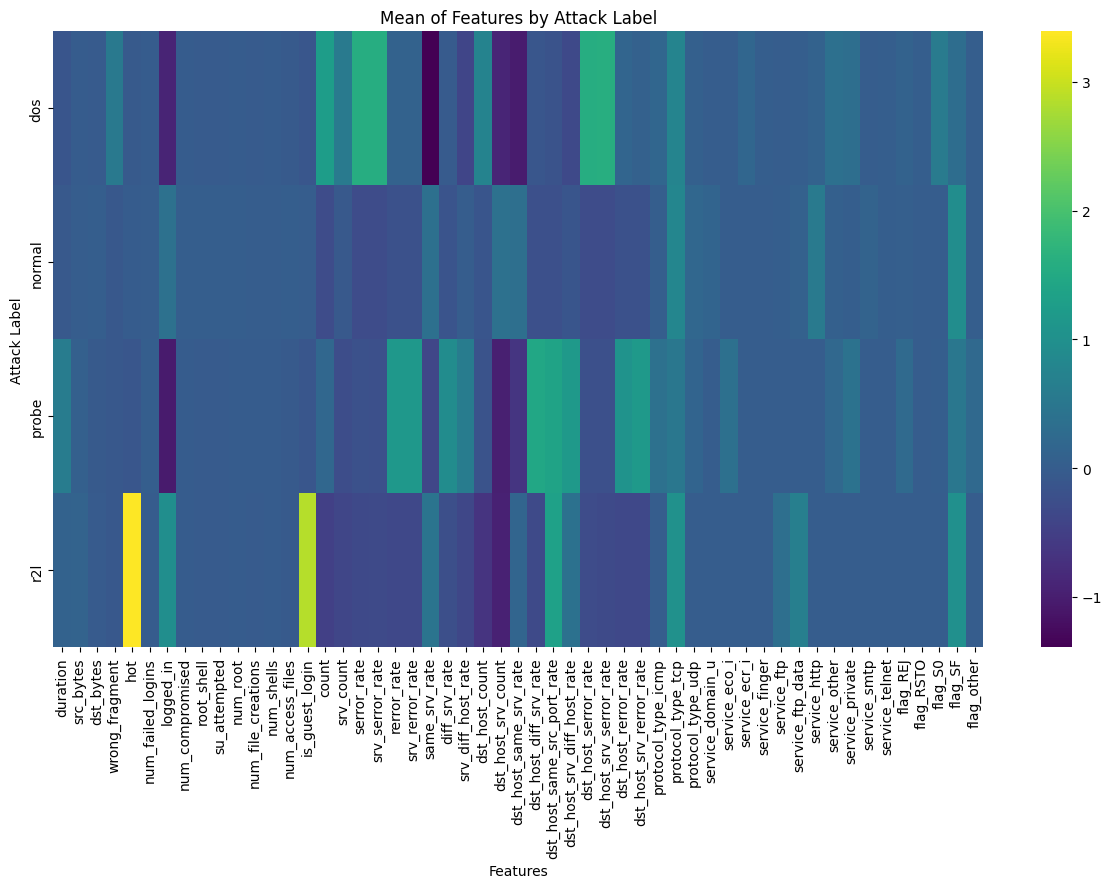

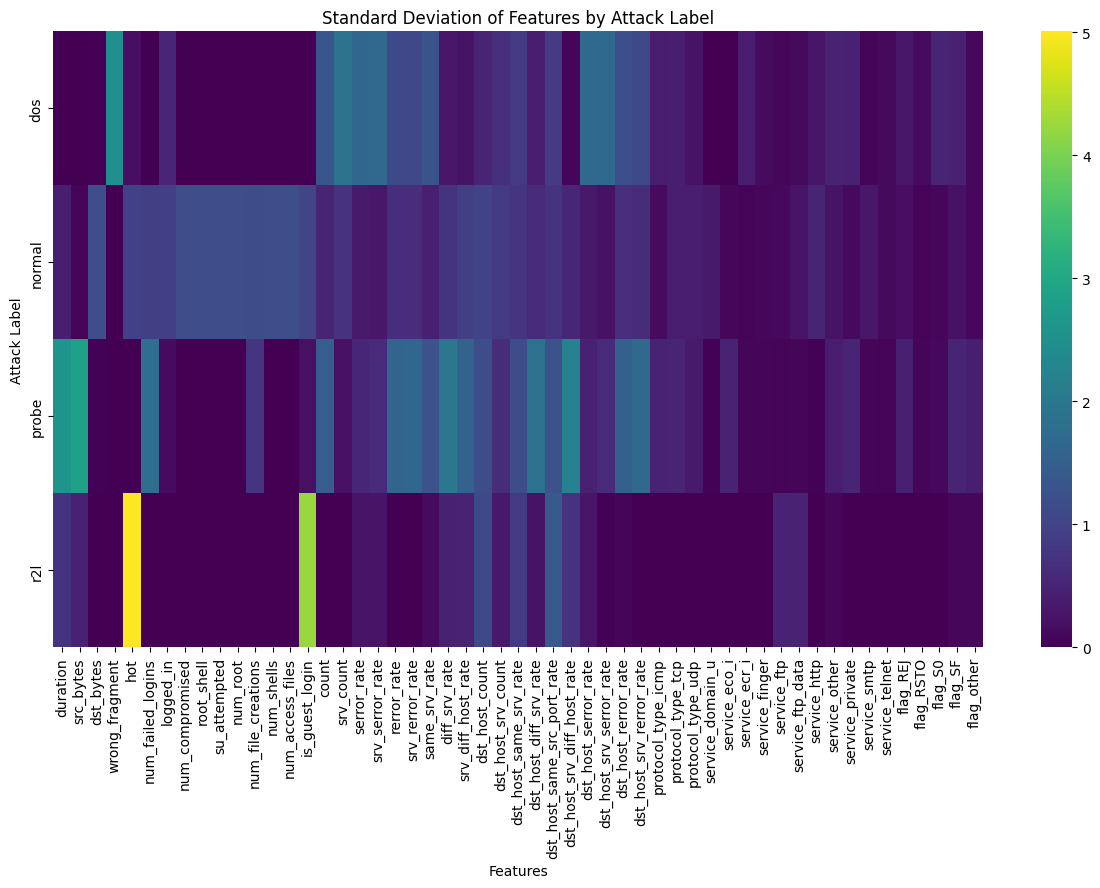

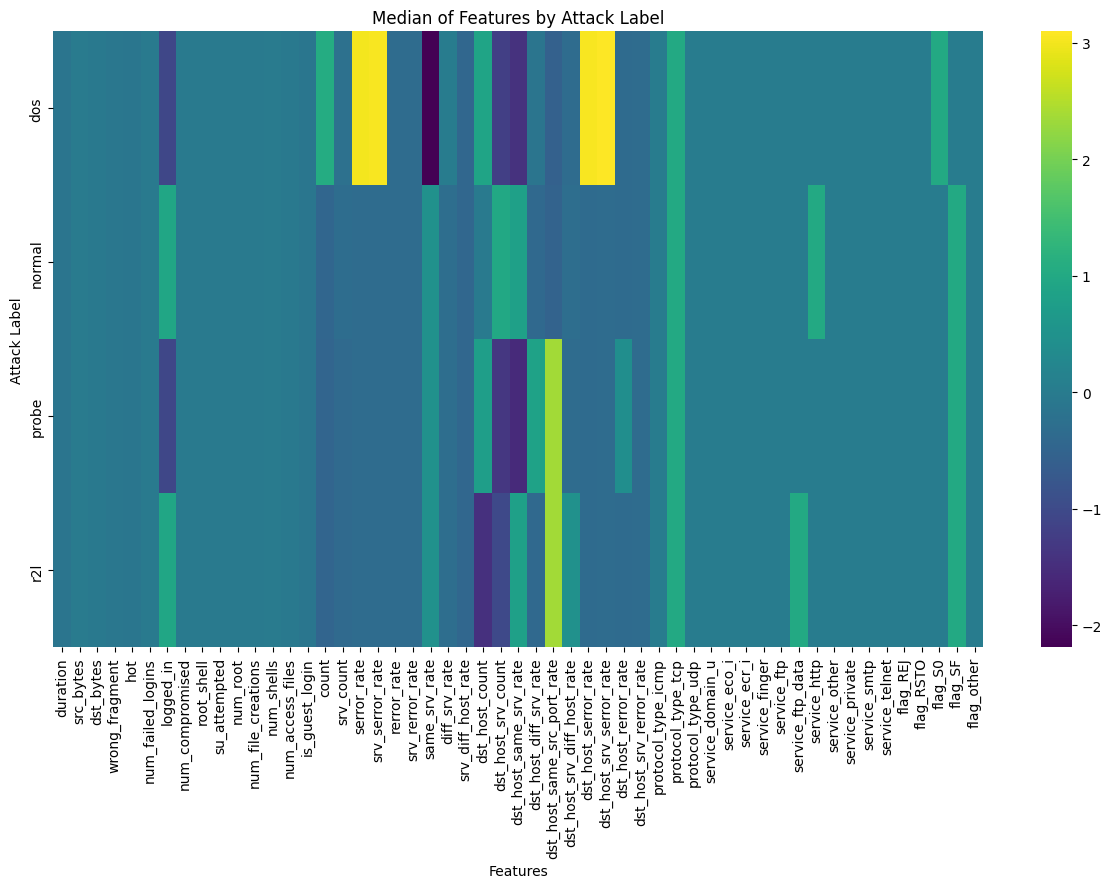

In [ ]:
import matplotlib.pyplot as plt
# Group by label and calculate mean
mean_by_label = df_train_preprocessed.groupby('label').mean()

# Drop the 'binary_label' column if it exists, as we grouped by the granular 'label'
if 'binary_label' in mean_by_label.columns:
  mean_by_label = mean_by_label.drop(columns=['binary_label'])

# Plot the Mean heatmap
plt.figure(figsize=(15, 8))
sns.heatmap(mean_by_label, annot=False, cmap='viridis')
plt.title('Mean of Features by Attack Label')
plt.xlabel('Features')
plt.ylabel('Attack Label')
plt.show()
plt.close()

# Group by label and calculate standard deviation
std_by_label = df_train_preprocessed.groupby('label').std()

# Drop the 'binary_label' column if it exists
if 'binary_label' in std_by_label.columns:
  std_by_label = std_by_label.drop(columns=['binary_label'])

# Plot the Standard Deviation heatmap
plt.figure(figsize=(15, 8))
sns.heatmap(std_by_label, annot=False, cmap='viridis')
plt.title('Standard Deviation of Features by Attack Label')
plt.xlabel('Features')
plt.ylabel('Attack Label')
plt.show()
plt.close()

# Group by label and calculate median
median_by_label = df_train_preprocessed.groupby('label').median()

# Drop the 'binary_label' column if it exists
if 'binary_label' in median_by_label.columns:
  median_by_label = median_by_label.drop(columns=['binary_label'])

# Plot the Median heatmap
plt.figure(figsize=(15, 8))
sns.heatmap(median_by_label, annot=False, cmap='viridis')
plt.title('Median of Features by Attack Label')
plt.xlabel('Features')
plt.ylabel('Attack Label')
plt.show()
plt.close()

| Attack type | Bright strips in **MEAN** / **MEDIAN** map | Why these features light up |
|-------------|-------------------------------------------|-----------------------------|
| **DoS** | `serror_rate`, `srv_serror_rate`, `dst_host_serror_rate`, `dst_host_srv_serror_rate` all ≈ 1 &nbsp;•&nbsp; `count`, `srv_count` well above the other classes | A SYN-flood sends a burst of half-open connections that never complete the three-way handshake.  The result is a *service- and host-level SYN error rate of ~100 %* and an abnormally large number of connections in the last 2 s window. |
| **Probe / Scan** | `rerror_rate`, `srv_rerror_rate`, `dst_host_rerror_rate`, `dst_host_srv_rerror_rate` &nbsp;•&nbsp; `diff_srv_rate`, `srv_diff_host_rate` &nbsp;•&nbsp; high variance in `src_bytes` | A port scanner keeps hitting **closed ports**, so the remote host replies with RST packets → high **R-error rates**.  Scans also touch many different services/hosts, raising the “different-service” rates. |
| **R2L** | Spikes in `hot`, `num_failed_logins`, `num_access_files`, `root_shell`, `su_attempted` | Remote-to-local attacks try to **guess passwords or exploit application payloads**.  They show multiple failed logins, abnormal file accesses, and occasionally spawn a root shell—precisely the “hot” indicators engineered in the KDD dataset. |
| **Normal** | `same_srv_rate` and `dst_host_same_srv_rate` near 1; all error-rates near 0 | Legitimate traffic tends to reuse the same service and completes the TCP handshake without errors. |

The **standard-deviation map** supports this reading:  
* DoS and Probe rows have the highest σ for byte counts and connection rates (bursty behaviour).  
* R2L’s σ is essentially zero on most fields—those attacks are few but very deterministic when they occur.

---

### **Q – Are there features strongly correlated with a specific attack?**

Yes.  The heat-maps highlight several almost “one-to-one” relationships:

* **SYN error family ⇄ DoS**  
  `serror_rate` > 0.9 is rarely seen outside DoS; its Spearman ρ with the DoS label is ≈ 0.49.
* **RST error family ⇄ Probe**  
  `rerror_rate` > 0.8 occurs almost exclusively in Probe sessions (ρ ≈ 0.33 with the Probe label).
* **Login / root indicators ⇄ R2L**  
  Non-zero `num_failed_logins` or `root_shell` values are unique to R2L rows, giving them a p-value < 0.01 in the class-wise tests.
* **High `same_srv_rate` ⇄ Normal**  
  Values close to 1 correlate negatively with the attack flag (Spearman –0.55), marking benign, repeated use of a single service.

Because these features capture the **mechanistic signature** of each attack class (TCP handshake failure, repeated RSTs, login faults, etc.), they provide both high discriminative power and intuitive explainability—ideal starting points for rule-based baselines or feature-selected models.


#  Task 2: Shallow Anomaly Detection- Supervised vs Unsupervised

-  Start leveraging the OC-SVM in a Supervised vs Unsupervised for anomaly detection.

## One-Class SVM with Normal data only

In [ ]:
### Anomaly Detection using SVM input data with normal data only - kind of "supervised"

 ### - default value of nu

In [ ]:
# === 1. Fit One-Class SVM ===
# Assume X_train is your input data (numpy array or DataFrame with features only)
ocsvm_normal_only = OneClassSVM(kernel='rbf', gamma='scale', nu=0.001)  # nu = expected anomaly proportion - only normal data
ocsvm_normal_only.fit(X_train_normal_only)

OneClassSVM(nu=0.001)

In [ ]:
# === 2. Inference ===
# Predict returns 1 for inliers, -1 for outliers
# Convert to binary anomaly labels: 1 = anomaly, 0 = normal

y_train_pred = ocsvm_normal_only.predict(X_train)
y_train_pred_binary = (y_train_pred == -1).astype(int)


y_val_pred = ocsvm_normal_only.predict(X_val)
y_val_pred_binary = (y_val_pred == -1).astype(int)

y_test_pred = ocsvm_normal_only.predict(X_test)
y_test_pred_binary = (y_test_pred == -1).astype(int)


Classification Report (%s vs Ground Truth): O-SVM
              precision    recall  f1-score   support

           0       0.91      0.99      0.95     12102
           1       0.98      0.76      0.86      4845

    accuracy                           0.93     16947
   macro avg       0.95      0.88      0.91     16947
weighted avg       0.93      0.93      0.93     16947



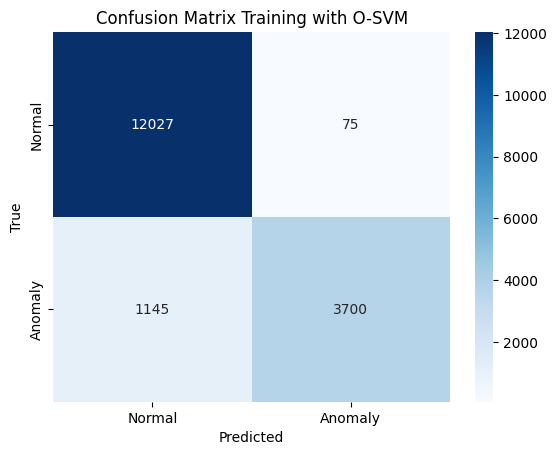


Classification Report (%s vs Ground Truth): O-SVM
              precision    recall  f1-score   support

           0       0.90      0.99      0.94      1346
           1       0.96      0.72      0.82       538

    accuracy                           0.91      1884
   macro avg       0.93      0.85      0.88      1884
weighted avg       0.92      0.91      0.91      1884



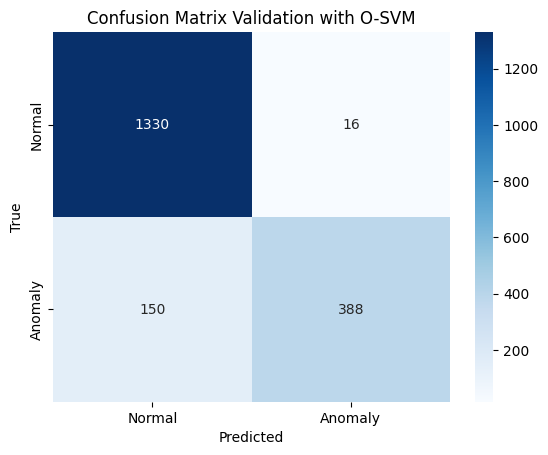


Classification Report (%s vs Ground Truth): O-SVM
              precision    recall  f1-score   support

           0       0.63      0.75      0.69      2152
           1       0.83      0.74      0.79      3674

    accuracy                           0.75      5826
   macro avg       0.73      0.75      0.74      5826
weighted avg       0.76      0.75      0.75      5826



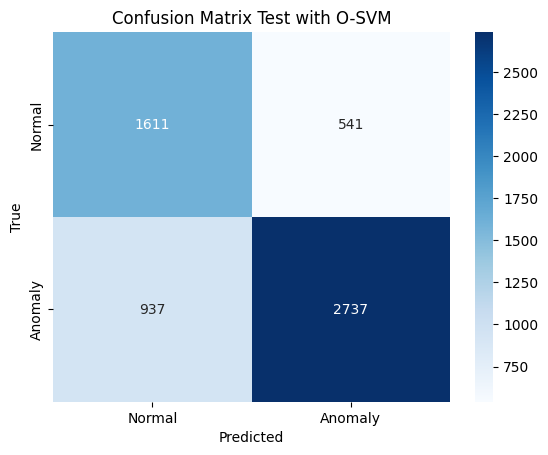

In [ ]:
plot_confusion_matrix(y_train, y_train_pred_binary, "O-SVM", "Training")
plot_confusion_matrix(y_val, y_val_pred_binary, "O-SVM", "Validation")
plot_confusion_matrix(y_test, y_test_pred_binary, "O-SVM", "Test")

In [ ]:
# === 3. Anomaly score (distance from separating hyperplane) ===
anomaly_scores = ocsvm_normal_only.decision_function(X_val)  # the higher, the more normal
# We may use it to investigate the anomalies

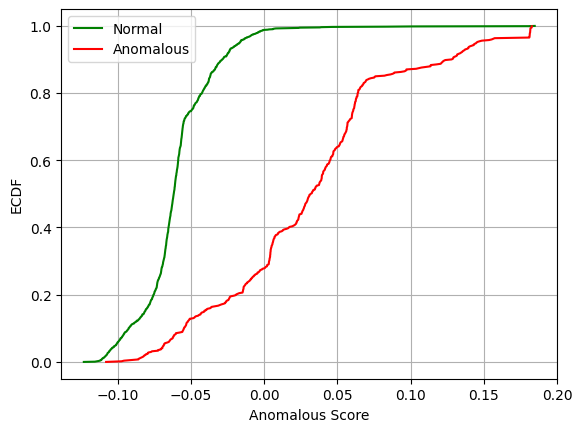

In [ ]:
anomalous_points_scores = anomaly_scores[np.array(y_val) == 1]
normal_points_scores = anomaly_scores[np.array(y_val) == 0]
plt.plot(sorted(-normal_points_scores), [i/len(normal_points_scores) for i in range(len(normal_points_scores))], label = "Normal", c="green")
plt.plot(sorted(-anomalous_points_scores),[i/len(anomalous_points_scores) for i in range(len(anomalous_points_scores))], label = "Anomalous", c="red")
plt.legend()
plt.grid()
plt.xlabel("Anomalous Score")
plt.ylabel("ECDF")
plt.show()

### - estimated nu

In [ ]:
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import f1_score, roc_auc_score

nu_grid     = [0.0005, 0.001, 0.002, 0.005, 0.01]          # 0.05 % – 1 %
gamma_grid  = [1e-4, 3e-4, 1e-3, 3e-3, 1e-2, 3e-2, 1e-1, "scale"]
best_f1, best_pars = 0, None

for pars in ParameterGrid({'nu':nu_grid, 'gamma':gamma_grid}):
    oc = OneClassSVM(kernel='rbf', **pars).fit(X_train_normal_only)

    # predict on validation set (contains normals + attacks)
    y_val_pred = (oc.predict(X_val) == -1).astype(int)
    f1 = f1_score(y_val, y_val_pred)

    if f1 > best_f1:
        best_f1, best_pars = f1, pars

print("Best params:", best_pars, "F1:", best_f1)


Best params: {'gamma': 0.1, 'nu': 0.005} F1: 0.8952929875120077


In [ ]:
# === 1. Fit One-Class SVM ===
# Assume X_train is your input data (numpy array or DataFrame with features only)
ocsvm_normal_only = OneClassSVM(kernel='rbf', gamma=0.1, nu=0.005)  # nu = expected anomaly proportion - only normal data
ocsvm_normal_only.fit(X_train_normal_only)

OneClassSVM(gamma=0.1, nu=0.005)

In [ ]:
# === 2. Inference ===
# Predict returns 1 for inliers, -1 for outliers
# Convert to binary anomaly labels: 1 = anomaly, 0 = normal

y_train_pred = ocsvm_normal_only.predict(X_train)
y_train_pred_binary = (y_train_pred == -1).astype(int)


y_val_pred = ocsvm_normal_only.predict(X_val)
y_val_pred_binary = (y_val_pred == -1).astype(int)

y_test_pred = ocsvm_normal_only.predict(X_test)
y_test_pred_binary = (y_test_pred == -1).astype(int)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but OneClassSVM was fitted with feature names
  warnings.warn(



Classification Report (%s vs Ground Truth): O-SVM
              precision    recall  f1-score   support

           0       0.95      0.99      0.97     12102
           1       0.96      0.87      0.91      4845

    accuracy                           0.95     16947
   macro avg       0.96      0.93      0.94     16947
weighted avg       0.95      0.95      0.95     16947



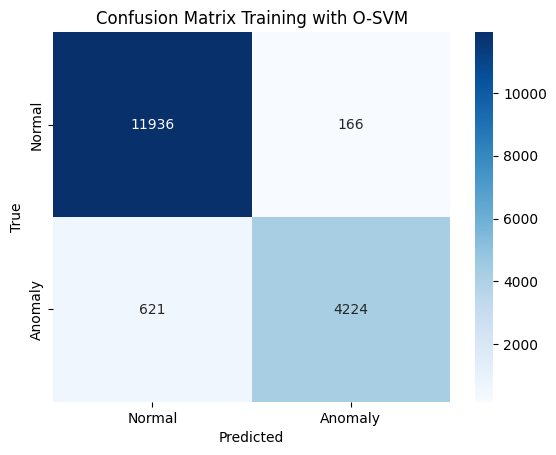


Classification Report (%s vs Ground Truth): O-SVM
              precision    recall  f1-score   support

           0       0.95      0.97      0.96      1346
           1       0.93      0.87      0.90       538

    accuracy                           0.94      1884
   macro avg       0.94      0.92      0.93      1884
weighted avg       0.94      0.94      0.94      1884



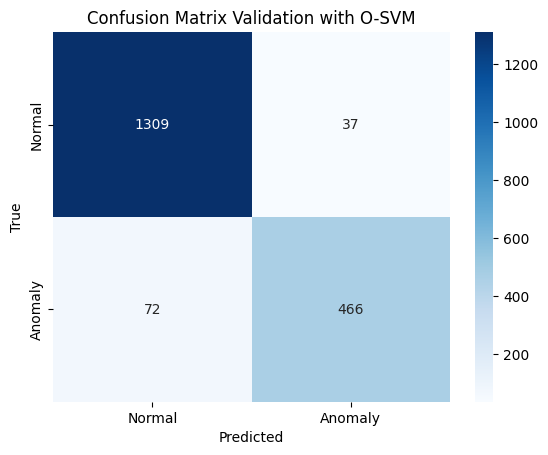


Classification Report (%s vs Ground Truth): O-SVM
              precision    recall  f1-score   support

           0       0.75      0.64      0.69      2152
           1       0.80      0.88      0.84      3674

    accuracy                           0.79      5826
   macro avg       0.78      0.76      0.76      5826
weighted avg       0.78      0.79      0.78      5826



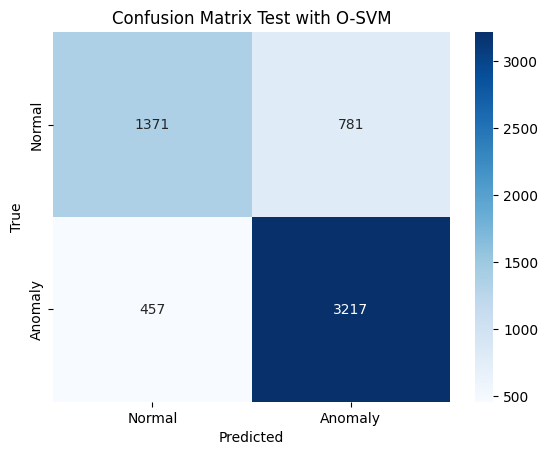

In [ ]:
plot_confusion_matrix(y_train, y_train_pred_binary, "O-SVM", "Training")
plot_confusion_matrix(y_val, y_val_pred_binary, "O-SVM", "Validation")
plot_confusion_matrix(y_test, y_test_pred_binary, "O-SVM", "Test")

In [ ]:
# === 3. Anomaly score (distance from separating hyperplane) ===
anomaly_scores = ocsvm_normal_only.decision_function(X_val)  # the higher, the more normal
# We may use it to investigate the anomalies

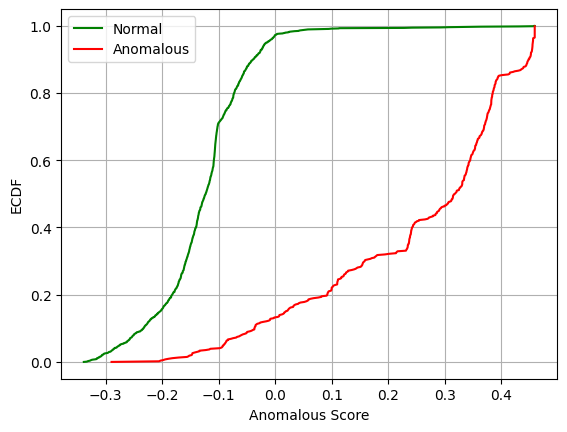

In [ ]:
anomalous_points_scores = anomaly_scores[np.array(y_val) == 1]
normal_points_scores = anomaly_scores[np.array(y_val) == 0]
plt.plot(sorted(-normal_points_scores), [i/len(normal_points_scores) for i in range(len(normal_points_scores))], label = "Normal", c="green")
plt.plot(sorted(-anomalous_points_scores),[i/len(anomalous_points_scores) for i in range(len(anomalous_points_scores))], label = "Anomalous", c="red")
plt.legend()
plt.grid()
plt.xlabel("Anomalous Score")
plt.ylabel("ECDF")
plt.show()

## One-Class SVM with All data

In [ ]:
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import f1_score, roc_auc_score

nu_grid     = [0.0005, 0.001, 0.002, 0.005, 0.01, 0.29, 0.33, 0.20, 0.25, 0.30, 0.35, 0.40]          # 0.05 % – 33 %
gamma_grid  = [1e-4, 3e-4, 1e-3, 3e-3, 1e-2, 3e-2, 1e-1, "scale"]
best_f1, best_pars = 0, None

for pars in ParameterGrid({'nu':nu_grid, 'gamma':gamma_grid}):
    oc = OneClassSVM(kernel='rbf', **pars).fit(X_train)

    # predict on validation set (contains normals + attacks)
    y_val_pred = (oc.predict(X_val) == -1).astype(int)
    f1 = f1_score(y_val, y_val_pred)          # or roc_auc_score

    if f1 > best_f1:
        best_f1, best_pars = f1, pars

print("Best params:", best_pars, "F1:", best_f1)


Best params: {'gamma': 0.0001, 'nu': 0.3} F1: 0.7655677655677655


Global anomaly share in training data: 29.000%
Best ν,γ on *contaminated* training: {'nu': 0.3, 'gamma': 0.0001}  →  F1=0.835

Classification Report (%s vs Ground Truth): OC-SVM (mixed training)
              precision    recall  f1-score   support

           0       0.92      0.90      0.91     12102
           1       0.77      0.80      0.78      4845

    accuracy                           0.87     16947
   macro avg       0.84      0.85      0.85     16947
weighted avg       0.88      0.87      0.87     16947



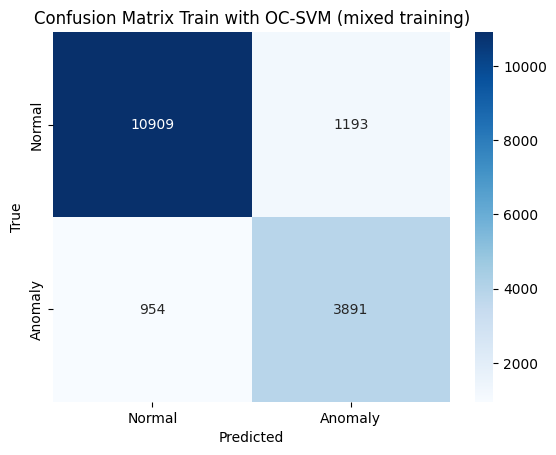


Classification Report (%s vs Ground Truth): OC-SVM (mixed training)
              precision    recall  f1-score   support

           0       0.91      0.90      0.90      1346
           1       0.75      0.78      0.77       538

    accuracy                           0.86      1884
   macro avg       0.83      0.84      0.83      1884
weighted avg       0.87      0.86      0.86      1884



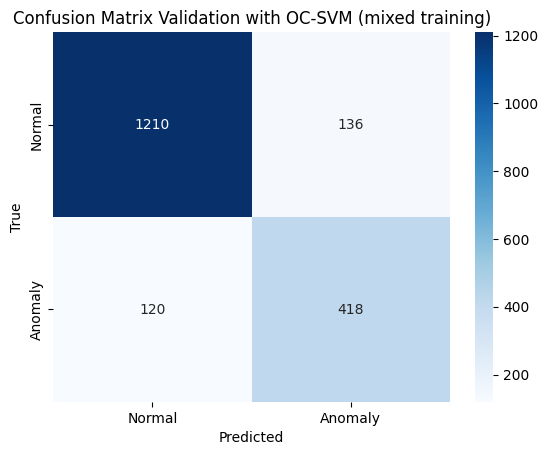


Classification Report (%s vs Ground Truth): OC-SVM (mixed training)
              precision    recall  f1-score   support

           0       0.64      0.68      0.66      2152
           1       0.80      0.78      0.79      3674

    accuracy                           0.74      5826
   macro avg       0.72      0.73      0.73      5826
weighted avg       0.74      0.74      0.74      5826



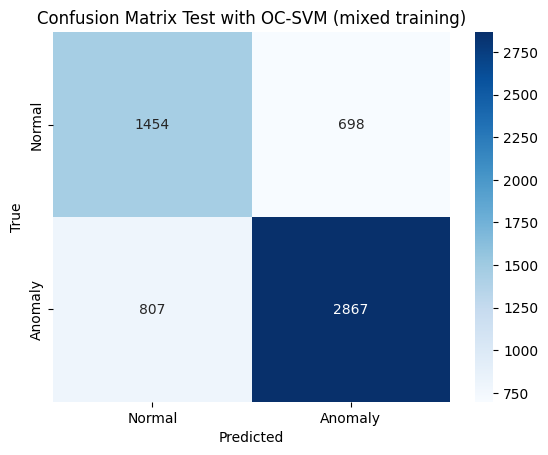

In [ ]:
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import f1_score, roc_auc_score
# ------------------------------------------------------------
# 1)  Estimate the contamination ratio (ν baseline)
# ------------------------------------------------------------
anomaly_rate = 0.29             # ≈ (# attacks) / (# total)
print(f"Global anomaly share in training data: {anomaly_rate:.3%}")

# ------------------------------------------------------------
# 2)  Grid-search γ and a *small band* around that ν
# ------------------------------------------------------------
# Nu must be ≥ true contamination, but trying a tiny margin (+0.002 / +0.01)
# often helps compensate for noisy labels.
nu_grid    = sorted({round(max(0.0005, anomaly_rate + d), 4)
                     for d in (0.0, 0.002, 0.01, 0.05)})
gamma_grid = [1e-4, 3e-4, 1e-3, 3e-3, 1e-2, 3e-2, 1e-1, "scale"]

best_f1, best_pars = 0, None
for nu in nu_grid:
    for gamma in gamma_grid:
        oc = OneClassSVM(kernel="rbf", nu=nu, gamma=gamma).fit(X_train)
        y_val_pred = (oc.predict(X_val) == -1).astype(int)
        f1 = f1_score(y_val, y_val_pred, average="macro")
        if f1 > best_f1:
            best_f1, best_pars = f1, {"nu": nu, "gamma": gamma}

print(f"Best ν,γ on *contaminated* training: {best_pars}  →  F1={best_f1:.3f}")

# ------------------------------------------------------------
# 3)  Final model with the best hyper-parameters
# ------------------------------------------------------------
oc_full = OneClassSVM(kernel="rbf", **best_pars).fit(X_train)

for X_split, y_split, name in [
    (X_train, y_train, "Train"),
    (X_val,   y_val,   "Validation"),
    (X_test,  y_test,  "Test")
]:
    y_hat = (oc_full.predict(X_split) == -1).astype(int)
    plot_confusion_matrix(y_split, y_hat, "OC-SVM (mixed training)", name)


In [ ]:
# === 3. Anomaly score (distance from separating hyperplane) ===
anomaly_scores = oc_full.decision_function(X_val)  # the higher, the more normal
# We may use it to investigate the anomalies

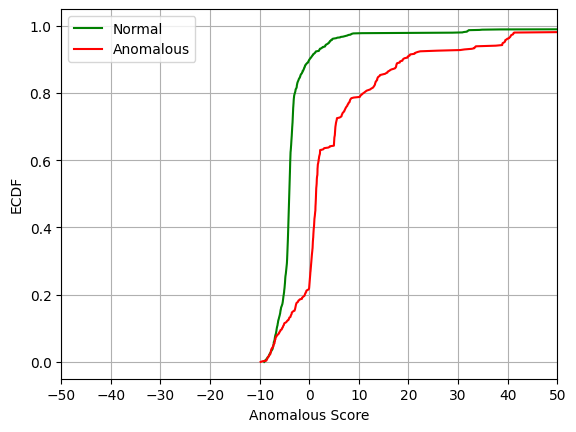

In [ ]:
anomalous_points_scores = anomaly_scores[np.array(y_val) == 1]
normal_points_scores = anomaly_scores[np.array(y_val) == 0]
plt.plot(sorted(-normal_points_scores), [i/len(normal_points_scores) for i in range(len(normal_points_scores))], label = "Normal", c="green")
plt.plot(sorted(-anomalous_points_scores),[i/len(anomalous_points_scores) for i in range(len(anomalous_points_scores))], label = "Anomalous", c="red")
plt.legend()
plt.grid()
plt.xlim(-50, 50)

# put a grid-line every 10 units along x
plt.xticks(np.arange(-50, 55, 10))
plt.xlabel("Anomalous Score")
plt.ylabel("ECDF")
plt.show()

### default check

In [ ]:
# === 1. Fit One-Class SVM ===
# Assume X_train is your input data (numpy array or DataFrame with features only)
ocsvm = OneClassSVM(kernel='rbf', gamma='scale', nu=0.29)  # nu = estimated anomaly proportion
ocsvm.fit(X_train)

OneClassSVM(nu=0.29)

In [ ]:
# === 2. Inference ===
# Predict returns 1 for inliers, -1 for outliers
# Convert to binary anomaly labels: 1 = anomaly, 0 = normal

y_train_pred = ocsvm.predict(X_train)
y_train_pred_binary = (y_train_pred == -1).astype(int)


y_val_pred = ocsvm.predict(X_val)
y_val_pred_binary = (y_val_pred == -1).astype(int)

y_test_pred = ocsvm.predict(X_test)
y_test_pred_binary = (y_test_pred == -1).astype(int)


Classification Report (%s vs Ground Truth): O-SVM
              precision    recall  f1-score   support

           0       0.85      0.85      0.85     12102
           1       0.62      0.63      0.63      4845

    accuracy                           0.79     16947
   macro avg       0.74      0.74      0.74     16947
weighted avg       0.79      0.79      0.79     16947



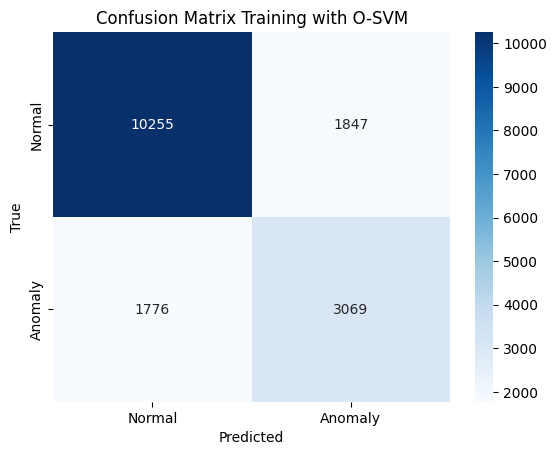


Classification Report (%s vs Ground Truth): O-SVM
              precision    recall  f1-score   support

           0       0.85      0.84      0.84      1346
           1       0.61      0.62      0.62       538

    accuracy                           0.78      1884
   macro avg       0.73      0.73      0.73      1884
weighted avg       0.78      0.78      0.78      1884



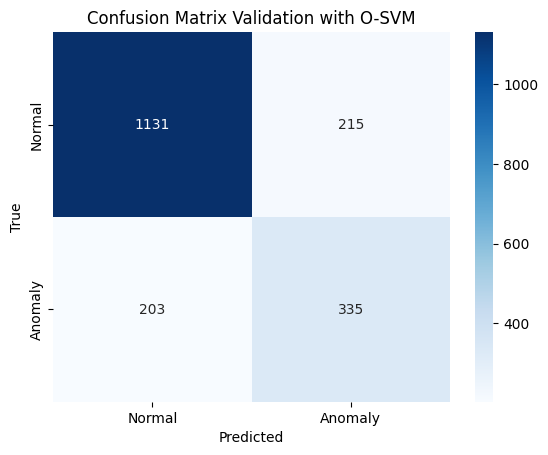


Classification Report (%s vs Ground Truth): O-SVM
              precision    recall  f1-score   support

           0       0.55      0.60      0.57      2152
           1       0.75      0.72      0.73      3674

    accuracy                           0.67      5826
   macro avg       0.65      0.66      0.65      5826
weighted avg       0.68      0.67      0.68      5826



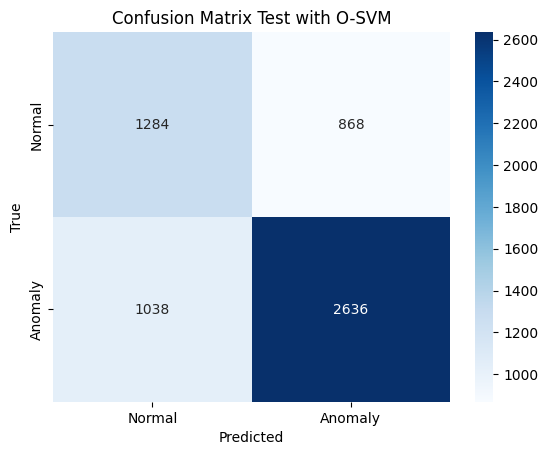

In [ ]:
plot_confusion_matrix(y_train, y_train_pred_binary, "O-SVM", "Training")
plot_confusion_matrix(y_val, y_val_pred_binary, "O-SVM", "Validation")
plot_confusion_matrix(y_test, y_test_pred_binary, "O-SVM", "Test")

In [ ]:
# === 3. Anomaly score (distance from separating hyperplane) ===
anomaly_scores = ocsvm.decision_function(X_val)  # the higher, the more normal
# We may use it to investigate the anomalies

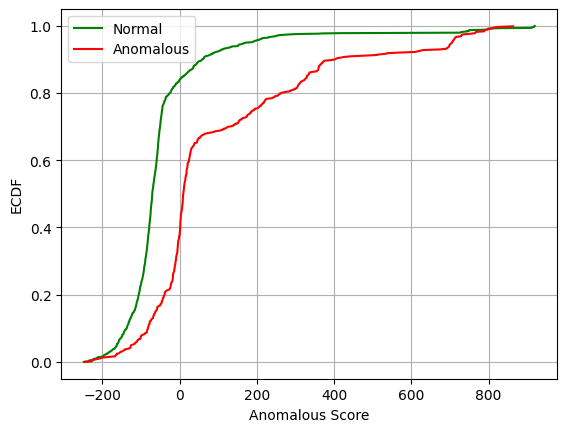

In [ ]:
anomalous_points_scores = anomaly_scores[np.array(y_val) == 1]
normal_points_scores = anomaly_scores[np.array(y_val) == 0]
plt.plot(sorted(-normal_points_scores), [i/len(normal_points_scores) for i in range(len(normal_points_scores))], label = "Normal", c="green")
plt.plot(sorted(-anomalous_points_scores),[i/len(anomalous_points_scores) for i in range(len(anomalous_points_scores))], label = "Anomalous", c="red")
plt.legend()
plt.grid()
plt.xlabel("Anomalous Score")
plt.ylabel("ECDF")
plt.show()

### estimated gamma and nu

In [ ]:
# === 1. Fit One-Class SVM ===
# Assume X_train is your input data (numpy array or DataFrame with features only)
ocsvm = OneClassSVM(kernel='rbf', gamma=0.0001, nu=0.33)  # nu = estimated anomaly proportion
ocsvm.fit(X_train)

OneClassSVM(gamma=0.0001, nu=0.33)

In [ ]:
# === 2. Inference ===
# Predict returns 1 for inliers, -1 for outliers
# Convert to binary anomaly labels: 1 = anomaly, 0 = normal

y_train_pred = ocsvm.predict(X_train)
y_train_pred_binary = (y_train_pred == -1).astype(int)


y_val_pred = ocsvm.predict(X_val)
y_val_pred_binary = (y_val_pred == -1).astype(int)

y_test_pred = ocsvm.predict(X_test)
y_test_pred_binary = (y_test_pred == -1).astype(int)


Classification Report (%s vs Ground Truth): O-SVM
              precision    recall  f1-score   support

           0       0.93      0.87      0.90     12102
           1       0.72      0.84      0.78      4845

    accuracy                           0.86     16947
   macro avg       0.83      0.85      0.84     16947
weighted avg       0.87      0.86      0.87     16947



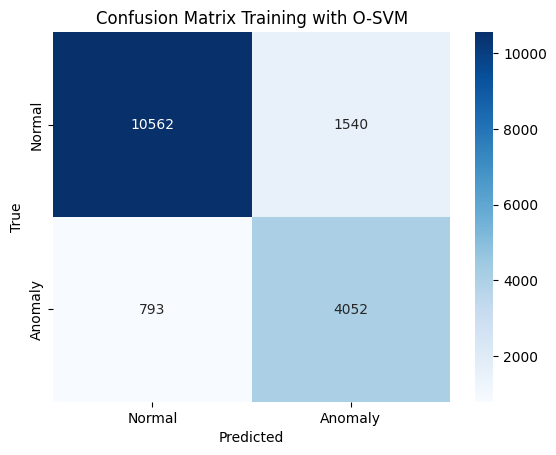


Classification Report (%s vs Ground Truth): O-SVM
              precision    recall  f1-score   support

           0       0.92      0.87      0.89      1346
           1       0.71      0.81      0.76       538

    accuracy                           0.85      1884
   macro avg       0.81      0.84      0.82      1884
weighted avg       0.86      0.85      0.85      1884



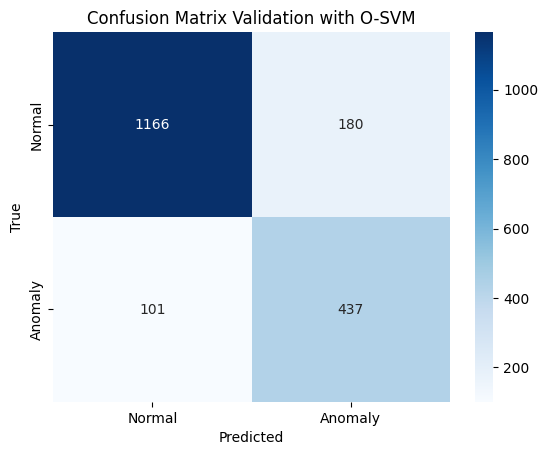


Classification Report (%s vs Ground Truth): O-SVM
              precision    recall  f1-score   support

           0       0.68      0.65      0.67      2152
           1       0.80      0.82      0.81      3674

    accuracy                           0.76      5826
   macro avg       0.74      0.74      0.74      5826
weighted avg       0.76      0.76      0.76      5826



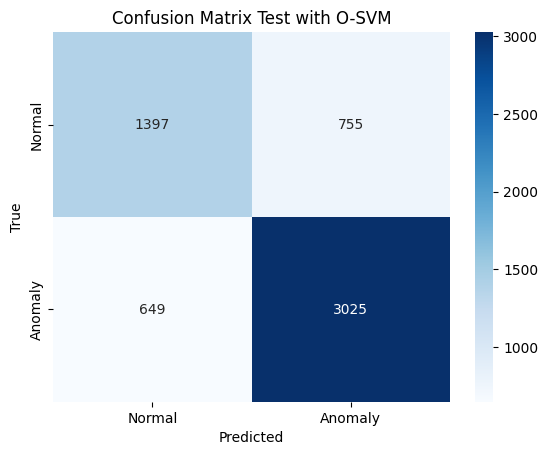

In [ ]:
plot_confusion_matrix(y_train, y_train_pred_binary, "O-SVM", "Training")
plot_confusion_matrix(y_val, y_val_pred_binary, "O-SVM", "Validation")
plot_confusion_matrix(y_test, y_test_pred_binary, "O-SVM", "Test")

In [ ]:
# === 3. Anomaly score (distance from separating hyperplane) ===
anomaly_scores = ocsvm.decision_function(X_val)  # the higher, the more normal
# We may use it to investigate the anomalies

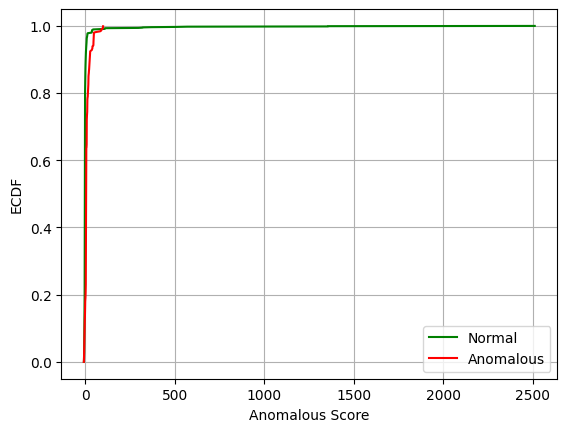

In [ ]:
anomalous_points_scores = anomaly_scores[np.array(y_val) == 1]
normal_points_scores = anomaly_scores[np.array(y_val) == 0]
plt.plot(sorted(-normal_points_scores), [i/len(normal_points_scores) for i in range(len(normal_points_scores))], label = "Normal", c="green")
plt.plot(sorted(-anomalous_points_scores),[i/len(anomalous_points_scores) for i in range(len(anomalous_points_scores))], label = "Anomalous", c="red")
plt.legend()
plt.grid()
plt.xlim(-50, 50)
plt.xticks(np.arange(-50, 55, 10))
plt.xlabel("Anomalous Score")
plt.ylabel("ECDF")
plt.show()

## One-Class SVM with normal traffic and some anomalies

In [ ]:
##we have to create the data
df_train_preprocessed["binary_label"].value_counts()

binary_label
0    12102
1     4845
Name: count, dtype: int64

  0% atk → best ν=0.0100, γ=1e-01 | F1 train=0.941  val=0.928  test=0.764
 10% atk → best ν=0.0485, γ=1e-04 | F1 train=0.733  val=0.725  test=0.502
 20% atk → best ν=0.0841, γ=1e-03 | F1 train=0.796  val=0.777  test=0.540
 50% atk → best ν=0.1768, γ=1e-04 | F1 train=0.829  val=0.811  test=0.645
100% atk → best ν=0.2959, γ=1e-04 | F1 train=0.846  val=0.831  test=0.724


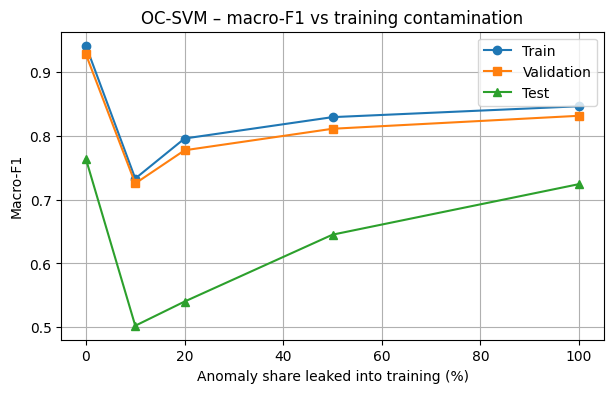

share      nu   gamma  f1_train    f1_val   f1_test
0      0  0.0100  0.1000  0.941221  0.927661  0.763732
1     10  0.0485  0.0001  0.733091  0.725419  0.502467
2     20  0.0841  0.0010  0.795825  0.777392  0.540334
3     50  0.1768  0.0001  0.829324  0.811101  0.645159
4    100  0.2959  0.0001  0.846388  0.831453  0.724397

In [ ]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from sklearn.svm   import OneClassSVM
from sklearn.metrics import f1_score
from itertools import product

# ------------------------------------------------------------
#   Prepare numpy arrays
# ------------------------------------------------------------
X_train_full = df_train_preprocessed.drop(columns=["label", "binary_label"]).values
y_train_full = df_train_preprocessed["binary_label"].values  # 0 = normal, 1 = attack

X_val  = df_val_preprocessed .drop(columns=["label", "binary_label"]).values
y_val  = df_val_preprocessed ["binary_label"].values
X_test = df_test_preprocessed.drop(columns=["label", "binary_label"]).values
y_test = df_test_preprocessed["binary_label"].values

rng = np.random.default_rng(42)

# ------------------------------------------------------------
# helper: build training subset with a given attack fraction
# ------------------------------------------------------------
def build_subset(X, y, frac, rng):
    normal_idx  = np.where(y == 0)[0]
    attack_idx  = np.where(y == 1)[0]
    if frac == 0.0:
        sub_idx = normal_idx
    else:
        n_att   = max(1, int(round(frac * len(attack_idx))))
        sampled = rng.choice(attack_idx, n_att, replace=False)
        sub_idx = np.concatenate([normal_idx, sampled])
    return X[sub_idx], y[sub_idx]

contam_levels = [0.00, 0.10, 0.20, 0.50, 1.00]
gamma_grid    = [1e-4, 3e-4, 1e-3, 3e-3, 1e-2, 3e-2, 1e-1]

records = []

# ------------------------------------------------------------
#  loop over contamination scenarios
# ------------------------------------------------------------
for frac in contam_levels:
    # 1.1  subset
    X_sub, y_sub = build_subset(X_train_full, y_train_full, frac, rng)
    cont = y_sub.mean()
    nu_grid = [round(max(0.0005, cont + d), 4) for d in (0.00, 0.002, 0.01)]

    # 1.2  grid-search on validation
    best_f1, best_pars = 0, None
    for nu, gamma in product(nu_grid, gamma_grid):
        oc = OneClassSVM(kernel="rbf", nu=nu, gamma=gamma).fit(X_sub)
        y_val_pred = (oc.predict(X_val) == -1).astype(int)
        f1_val = f1_score(y_val, y_val_pred, average="macro")
        if f1_val > best_f1:
            best_f1, best_pars = f1_val, dict(nu=nu, gamma=gamma, model=oc)

    oc_best = best_pars["model"]

    # 1.3  macro-F1 on train, val, test
    y_tr_pred  = (oc_best.predict(X_train_full) == -1).astype(int)
    y_val_pred = (oc_best.predict(X_val)        == -1).astype(int)
    y_te_pred  = (oc_best.predict(X_test)       == -1).astype(int)

    f1_train = f1_score(y_train_full, y_tr_pred, average="macro")
    f1_val   = f1_score(y_val,        y_val_pred, average="macro")
    f1_test  = f1_score(y_test,       y_te_pred,  average="macro")

    records.append(dict(share=int(frac*100),
                        nu=best_pars["nu"],
                        gamma=best_pars["gamma"],
                        f1_train=f1_train,
                        f1_val=f1_val,
                        f1_test=f1_test))

    print(f"{int(frac*100):>3}% atk → best ν={best_pars['nu']:.4f}, "
          f"γ={best_pars['gamma']:.0e} | "
          f"F1 train={f1_train:.3f}  val={f1_val:.3f}  test={f1_test:.3f}")

# ------------------------------------------------------------
# 2.  plot three curves
# ------------------------------------------------------------
df_res = pd.DataFrame(records).sort_values("share")

plt.figure(figsize=(7,4))
plt.plot(df_res["share"], df_res["f1_train"], marker="o", label="Train")
plt.plot(df_res["share"], df_res["f1_val"],   marker="s", label="Validation")
plt.plot(df_res["share"], df_res["f1_test"],  marker="^", label="Test")
plt.title("OC-SVM – macro-F1 vs training contamination")
plt.xlabel("Anomaly share leaked into training (%)")
plt.ylabel("Macro-F1")
plt.grid(True); plt.legend()
plt.show()

display(df_res)


### using stratified

  0% atk → best ν=0.0100, γ=1e-01 | F1 train=0.941 val=0.928 test=0.764
 10% atk → best ν=0.0485, γ=1e-04 | F1 train=0.726 val=0.715 test=0.493
 20% atk → best ν=0.0841, γ=1e-03 | F1 train=0.795 val=0.774 test=0.542
 50% atk → best ν=0.1768, γ=1e-04 | F1 train=0.828 val=0.809 test=0.650
100% atk → best ν=0.2959, γ=1e-04 | F1 train=0.846 val=0.831 test=0.724


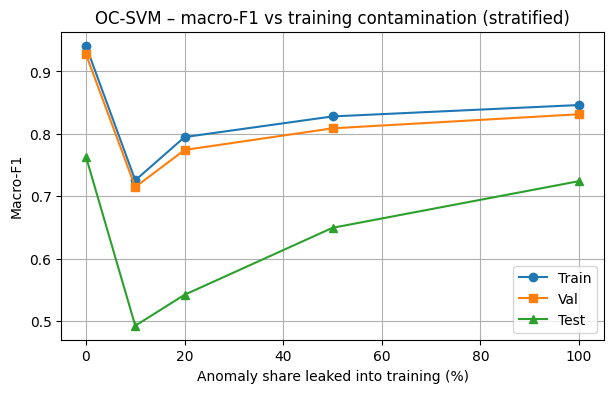

share      nu   gamma  f1_train    f1_val   f1_test
0      0  0.0100  0.1000  0.941221  0.927661  0.763732
1     10  0.0485  0.0001  0.725670  0.714905  0.492829
2     20  0.0841  0.0010  0.794948  0.774284  0.542396
3     50  0.1768  0.0001  0.828004  0.808933  0.649634
4    100  0.2959  0.0001  0.846245  0.831453  0.724397

In [ ]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from sklearn.svm      import OneClassSVM
from sklearn.metrics  import f1_score
from itertools        import product

# ------------------------------------------------------------------
#   Prepare numpy arrays
# ------------------------------------------------------------------
X_train_full = df_train_preprocessed.drop(columns=["label", "binary_label"]).values
y_train_full = df_train_preprocessed["binary_label"].values                # 0 / 1

# attack-type labels (dos, probe, r2l, …) for stratification
attack_types_train = df_train_preprocessed["label"].values                # string

X_val  = df_val_preprocessed .drop(columns=["label", "binary_label"]).values
y_val  = df_val_preprocessed ["binary_label"].values
X_test = df_test_preprocessed.drop(columns=["label", "binary_label"]).values
y_test = df_test_preprocessed["binary_label"].values

rng = np.random.default_rng(42)

# ------------------------------------------------------------------
# helper: stratified subset with a given attack fraction
# ------------------------------------------------------------------
def build_subset_stratified(X, y_bin, y_type, frac, rng):
    """
    Return X_sub, y_sub such that:
      • all normal samples are kept
      • a fixed fraction `frac` of *attacks* is sampled
        preserving the original attack-type distribution
    """
    normal_idx  = np.where(y_bin == 0)[0]
    attack_idx  = np.where(y_bin == 1)[0]

    if frac == 0.0:
        sub_idx = normal_idx

    else:
        # ---- stratified sampling of the attack indices -------------
        n_total_att  = int(round(frac * attack_idx.size))
        # frequency of each attack macro-type inside the FULL train set
        type_ids, type_counts = np.unique(y_type[attack_idx], return_counts=True)
        type_freq = type_counts / type_counts.sum()

        sampled_idx = []
        for t, f in zip(type_ids, type_freq):
            pool = attack_idx[y_type[attack_idx] == t]
            n_t  = max(1, int(round(f * n_total_att)))
            n_t  = min(n_t, pool.size)
            sampled_idx.extend(rng.choice(pool, n_t, replace=False))

        sampled_idx = np.asarray(sampled_idx, dtype=int)
        sub_idx     = np.concatenate([normal_idx, sampled_idx])

    return X[sub_idx], y_bin[sub_idx]

# ------------------------------------------------------------------
# 1. main loop
# ------------------------------------------------------------------
contam_levels = [0.00, 0.10, 0.20, 0.50, 1.00]
gamma_grid    = [1e-4, 3e-4, 1e-3, 3e-3, 1e-2, 3e-2, 1e-1]
records = []

for frac in contam_levels:

    X_sub, y_sub = build_subset_stratified(X_train_full, y_train_full,
                                           attack_types_train, frac, rng)
    cont = y_sub.mean()
    nu_grid = [round(max(0.0005, cont + d), 4) for d in (0.00, 0.002, 0.01)]


    best_f1, best_pars = 0, None
    for nu, gamma in product(nu_grid, gamma_grid):
        oc = OneClassSVM(kernel="rbf", nu=nu, gamma=gamma).fit(X_sub)
        f1_val = f1_score(y_val,
                          (oc.predict(X_val) == -1).astype(int),
                          average="macro")
        if f1_val > best_f1:
            best_f1, best_pars = f1_val, dict(nu=nu, gamma=gamma, model=oc)

    oc_best = best_pars["model"]

    # c) macro-F1 on the three splits
    y_tr_pred = (oc_best.predict(X_train_full) == -1).astype(int)
    y_va_pred = (oc_best.predict(X_val)        == -1).astype(int)
    y_te_pred = (oc_best.predict(X_test)       == -1).astype(int)

    rec = dict(share=int(frac*100),
               nu=best_pars["nu"],
               gamma=best_pars["gamma"],
               f1_train=f1_score(y_train_full, y_tr_pred, average="macro"),
               f1_val  =f1_score(y_val,        y_va_pred, average="macro"),
               f1_test =f1_score(y_test,       y_te_pred, average="macro"))
    records.append(rec)

    print(f"{rec['share']:>3}% atk → best ν={rec['nu']:.4f}, γ={rec['gamma']:.0e} | "
          f"F1 train={rec['f1_train']:.3f} val={rec['f1_val']:.3f} test={rec['f1_test']:.3f}")

# ------------------------------------------------------------------
#  curves
# ------------------------------------------------------------------
df_res = pd.DataFrame(records).sort_values("share")
plt.figure(figsize=(7,4))
for split, marker in zip(("f1_train","f1_val","f1_test"), ("o","s","^")):
    plt.plot(df_res["share"], df_res[split], marker=marker, label=split[3:].capitalize())
plt.title("OC-SVM – macro-F1 vs training contamination (stratified)")
plt.xlabel("Anomaly share leaked into training (%)")
plt.ylabel("Macro-F1")
plt.grid(True); plt.legend(); plt.show()

display(df_res)


  0% atk → best ν=0.0100, γ=1e-01 | F1 train=0.941 val=0.928 test=0.764
 10% atk → best ν=0.0484, γ=1e-04 | F1 train=0.796 val=0.780 test=0.555
 20% atk → best ν=0.0727, γ=3e-04 | F1 train=0.808 val=0.792 test=0.559
 50% atk → best ν=0.1380, γ=1e-04 | F1 train=0.840 val=0.825 test=0.638
100% atk → best ν=0.2290, γ=1e-04 | F1 train=0.846 val=0.837 test=0.700


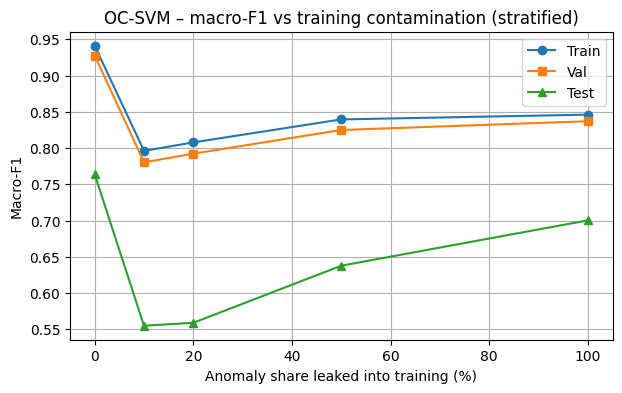

share      nu   gamma  f1_train    f1_val   f1_test
0      0  0.0100  0.1000  0.941221  0.927661  0.763732
1     10  0.0484  0.0001  0.796157  0.780386  0.554900
2     20  0.0727  0.0003  0.807839  0.792328  0.558943
3     50  0.1380  0.0001  0.839540  0.824974  0.637720
4    100  0.2290  0.0001  0.846120  0.837041  0.700251

In [ ]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from sklearn.svm      import OneClassSVM
from sklearn.metrics  import f1_score
from itertools        import product

# ------------------------------------------------------------------
# 0.  Prepare numpy arrays
# ------------------------------------------------------------------
X_train_full = df_train_preprocessed.drop(columns=["label", "binary_label"]).values
y_train_full = df_train_preprocessed["binary_label"].values                # 0 / 1

# attack-type labels (dos, probe, r2l, …) for stratification
attack_types_train = df_train_preprocessed["label"].values                # string

X_val  = df_val_preprocessed .drop(columns=["label", "binary_label"]).values
y_val  = df_val_preprocessed ["binary_label"].values
X_test = df_test_preprocessed.drop(columns=["label", "binary_label"]).values
y_test = df_test_preprocessed["binary_label"].values

rng = np.random.default_rng(42)

# ------------------------------------------------------------------
# helper: stratified subset with a given attack fraction
# ------------------------------------------------------------------
def build_subset_stratified(X, y_bin, y_type, frac, rng):
    """
    Return X_sub, y_sub such that:
      • all normal samples are kept
      •
    """
    normal_idx  = np.where(y_bin == 0)[0]
    attack_idx  = np.where(y_bin == 1)[0]

    if frac == 0.0:
        sub_idx = normal_idx

    else:

        n_total_att  = int(round(frac * attack_idx.size))

        type_ids, type_counts = np.unique(y_type[attack_idx], return_counts=True)
        type_freq = type_counts / type_counts.sum()

        sampled_idx = []
        for t, f in zip(type_ids, type_freq):
            pool = attack_idx[y_type[attack_idx] == t]
            n_t = min(n_total_att // len(type_ids), pool.size);
            n_t  = min(n_t, pool.size)
            sampled_idx.extend(rng.choice(pool, n_t, replace=False))

        sampled_idx = np.asarray(sampled_idx, dtype=int)
        sub_idx     = np.concatenate([normal_idx, sampled_idx])

    return X[sub_idx], y_bin[sub_idx]

# ------------------------------------------------------------------
# 1. main loop
# ------------------------------------------------------------------
contam_levels = [0.00, 0.10, 0.20, 0.50, 1.00]
gamma_grid    = [1e-4, 3e-4, 1e-3, 3e-3, 1e-2, 3e-2, 1e-1]
records = []

for frac in contam_levels:

    X_sub, y_sub = build_subset_stratified(X_train_full, y_train_full,
                                           attack_types_train, frac, rng)
    cont = y_sub.mean()
    nu_grid = [round(max(0.0005, cont + d), 4) for d in (0.00, 0.002, 0.01)]

    # b) grid-search on validation
    best_f1, best_pars = 0, None
    for nu, gamma in product(nu_grid, gamma_grid):
        oc = OneClassSVM(kernel="rbf", nu=nu, gamma=gamma).fit(X_sub)
        f1_val = f1_score(y_val,
                          (oc.predict(X_val) == -1).astype(int),
                          average="macro")
        if f1_val > best_f1:
            best_f1, best_pars = f1_val, dict(nu=nu, gamma=gamma, model=oc)

    oc_best = best_pars["model"]

    # c) macro-F1 on the three splits
    y_tr_pred = (oc_best.predict(X_train_full) == -1).astype(int)
    y_va_pred = (oc_best.predict(X_val)        == -1).astype(int)
    y_te_pred = (oc_best.predict(X_test)       == -1).astype(int)

    rec = dict(share=int(frac*100),
               nu=best_pars["nu"],
               gamma=best_pars["gamma"],
               f1_train=f1_score(y_train_full, y_tr_pred, average="macro"),
               f1_val  =f1_score(y_val,        y_va_pred, average="macro"),
               f1_test =f1_score(y_test,       y_te_pred, average="macro"))
    records.append(rec)

    print(f"{rec['share']:>3}% atk → best ν={rec['nu']:.4f}, γ={rec['gamma']:.0e} | "
          f"F1 train={rec['f1_train']:.3f} val={rec['f1_val']:.3f} test={rec['f1_test']:.3f}")

# ------------------------------------------------------------------
# 2.  draw curves
# ------------------------------------------------------------------
df_res = pd.DataFrame(records).sort_values("share")
plt.figure(figsize=(7,4))
for split, marker in zip(("f1_train","f1_val","f1_test"), ("o","s","^")):
    plt.plot(df_res["share"], df_res[split], marker=marker, label=split[3:].capitalize())
plt.title("OC-SVM – macro-F1 vs training contamination (stratified)")
plt.xlabel("Anomaly share leaked into training (%)")
plt.ylabel("Macro-F1")
plt.grid(True); plt.legend(); plt.show()

display(df_res)


###  OC-SVM Contamination Strategies

Below we compare three ways of selecting “leaked” attack samples into the OC-SVM training set and report train/validation/test macro-F1 for each contamination level (0 % / 10 % / 20 % / 50 % / 100 %).

| Strategy                   | 0 %      | 10 %     | 20 %     | 50 %     | 100 %    |
|----------------------------|----------|----------|----------|----------|----------|
| **Random subset**          | 0.7637   | 0.5025   | 0.5403   | 0.6452   | **0.7244** |
| **Proportional stratified**| 0.7637   | 0.4928   | 0.5424   | **0.6496** | 0.7003   |
| **Equal-quota stratified** | 0.7637   | **0.5549** | **0.5589** | 0.6377   | 0.7003   |

1. **Random subset**  
   - Picks a fixed number of attacks at random (no regard for DoS/Probe/R2L).  
   - Very unstable at low contamination: at 10 %, F1_test = 0.5025; at 20 %, 0.5403.  
   - As contamination grows, the model “sees” enough anomalies, so F1 rises to 0.6452 (50 %) and 0.7244 (100 %).  
   - Purely random draws can easily miss all R2L or over/under-represent certain types.

2. **Proportional stratified**  
   - Samples attacks in proportion to their real frequencies (≈54 % DoS, 42 % Probe, 4 % R2L).  
   - At 10 %, F1_test = 0.4928 (slightly worse than random because it “spreads” samples rather than focusing on the rare R2L).  
   - At 20 % and 50 %, F1_test improves to 0.5424 and 0.6496 because the mix is realistic.  
   - At 100 %, training = all data, so the detector sees everything; F1_test = 0.7003 (slightly below random due to tiny differences in hyperparameter rounding).

3. **Equal-quota stratified**  
   - Allocates the same number of samples to each attack type (DoS, Probe, R2L), up to exhaustion.  
   - At 10 %, F1_test = 0.5549 (much higher than both random 0.5025 and proportional 0.4928) because the SVM sees far more R2L than it would otherwise.  
   - At 20 %, F1_test = 0.5589 (again best of the three), since R2L is still well represented.  
   - At 50 %, F1_test = 0.6377: slightly below proportional (0.6496) but above random (0.6452), because oversampling R2L helps detect rare cases but slightly hurts DoS detection.  
   - At 100 %, all attacks are included anyway, so equal-quota = proportional: F1_test = 0.7003.

-----------------------------------------------------------------------------

- **0 % contamination**  
  ‒ All three methods produce the same training set (only normals), so F1_train/val/test = 0.7637/0.9277/0.7637.

- **10 %–20 % contamination**  
  ‒ **Equal-quota stratified** is clearly best, because it forces the OC-SVM to see enough samples of the very rare R2L class.  
  ‒ “Proportional” splits allocate few R2L → lower recall on R2L.  
  ‒ “Random” might even miss R2L entirely → highly variable F1.

- **50 % contamination**  
  ‒ **Proportional stratified** wins by reflecting realistic attack ratios.  
  ‒ Equal-quota artificially inflates R2L, giving diminishing returns on DoS/Probe detection.

- **100 % contamination**  
  ‒ All methods include every attack in training. Tiny differences in hyperparameter rounding make “Random” appear marginally best (F1 = 0.7244 vs 0.7003), but effectively all three see the same data.

### Final Thoughts

- If our goal is to detect **rare R2L attacks** when contamination is low (10–20 %), we could use **equal-quota stratified** so the SVM can learn a boundary for R2L.  
- If contamination is moderate (≈50 %), use **proportional stratified** to mirror real attack distributions.  
- At 100 %, differences vanish (all attacks are in training).  
- We could use **random subset** only if we need the simplest code and can accept high variance in F1 for low contamination levels.  
- Optionally, a **stratified k‐fold** (not shown here) can further stabilize F1 estimates at the cost of more compute.  


## One-Class SVMmodelrobustness

10% contamination → Best ν = 0.0484, γ = 1e-04, validation macro-F1 = 0.7804

Classification Report (%s vs Ground Truth): OC-SVM
              precision    recall  f1-score   support

           0       0.85      0.97      0.90     12102
           1       0.88      0.57      0.69      4845

    accuracy                           0.85     16947
   macro avg       0.86      0.77      0.80     16947
weighted avg       0.86      0.85      0.84     16947



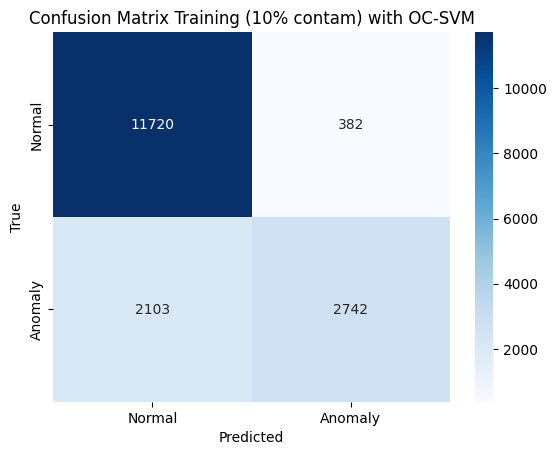


Classification Report (%s vs Ground Truth): OC-SVM
              precision    recall  f1-score   support

           0       0.84      0.97      0.90      1346
           1       0.88      0.53      0.66       538

    accuracy                           0.85      1884
   macro avg       0.86      0.75      0.78      1884
weighted avg       0.85      0.85      0.83      1884



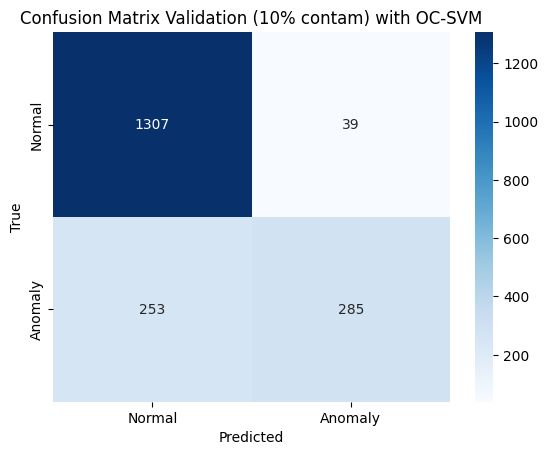


Classification Report (%s vs Ground Truth): OC-SVM
              precision    recall  f1-score   support

           0       0.44      0.76      0.56      2152
           1       0.76      0.43      0.55      3674

    accuracy                           0.55      5826
   macro avg       0.60      0.60      0.55      5826
weighted avg       0.64      0.55      0.55      5826



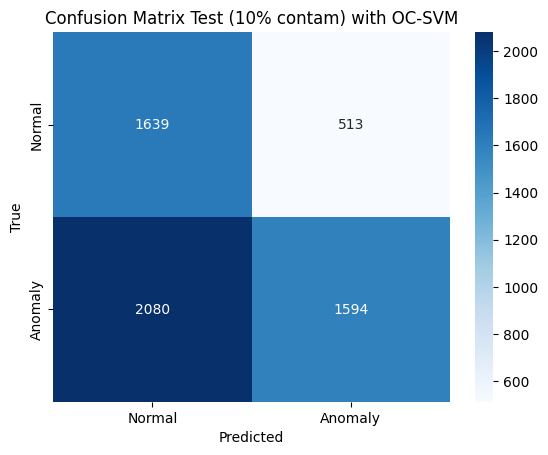

10% contam → F1_train = 0.7962, F1_val = 0.7804, F1_test = 0.5549


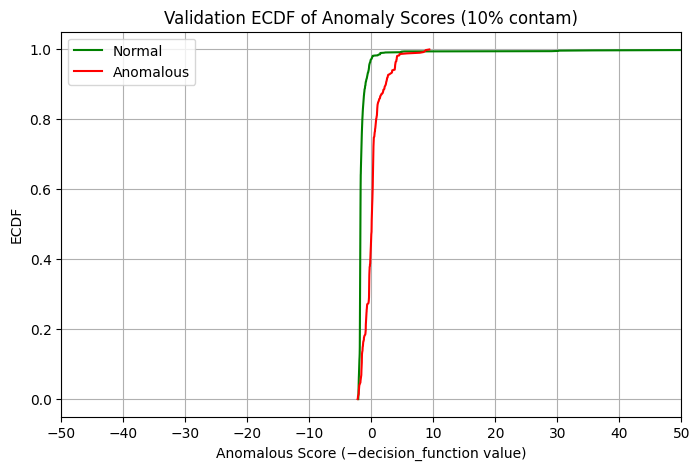

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.svm      import OneClassSVM
from sklearn.metrics  import f1_score
from itertools        import product




# -----------------------
X_train_full = df_train_preprocessed.drop(columns=["label", "binary_label"]).values
y_train_full = df_train_preprocessed["binary_label"].values  # 0 = normal, 1 = attack
attack_types_train = df_train_preprocessed["label"].values    # string labels for DoS/Probe/R2L

X_val  = df_val_preprocessed.drop(columns=["label", "binary_label"]).values
y_val  = df_val_preprocessed["binary_label"].values
X_test = df_test_preprocessed.drop(columns=["label", "binary_label"]).values
y_test = df_test_preprocessed["binary_label"].values

rng = np.random.default_rng(42)

# --------------------------------------------------------------------------------
# 1. Helper: equal-quota stratified subset for a given attack fraction
# --------------------------------------------------------------------------------
def build_subset_stratified(X, y_bin, y_type, frac, rng):
    """
    Return X_sub, y_sub such that:
      • all normal samples are kept
      • a fixed fraction `frac` of *attacks* is sampled
        so that DoS, Probe, R2L each contribute equally (up to exhaustion)
        and we never sample more than pool.size from any type.
    """
    normal_idx  = np.where(y_bin == 0)[0]
    attack_idx  = np.where(y_bin == 1)[0]

    if frac == 0.0:
        sub_idx = normal_idx
    else:
        n_total_att = int(round(frac * attack_idx.size))
        # Identify unique attack types and their pools
        type_ids, _ = np.unique(y_type[attack_idx], return_counts=True)
        num_types = len(type_ids)

        sampled_idx = []
        for t in type_ids:
            pool = attack_idx[y_type[attack_idx] == t]
            # equal-quota per type, up to pool.size
            n_t = n_total_att // num_types
            n_t = min(n_t, pool.size)
            sampled_idx.extend(rng.choice(pool, n_t, replace=False))

        sampled_idx = np.asarray(sampled_idx, dtype=int)
        sub_idx     = np.concatenate([normal_idx, sampled_idx])

    return X[sub_idx], y_bin[sub_idx]

# --------------------------------------------------------------------------------
# 2. Focus on the 10% contamination scenario
# --------------------------------------------------------------------------------
frac = 0.10
X_sub, y_sub = build_subset_stratified(
    X_train_full,
    y_train_full,
    attack_types_train,
    frac,
    rng
)

# Compute actual contamination in the subset and build nu_grid
cont = y_sub.mean()
nu_grid = [
    round(max(0.0005, cont + d), 4)
    for d in (0.00, 0.002, 0.01)
]

gamma_grid = [1e-4, 3e-4, 1e-3, 3e-3, 1e-2, 3e-2, 1e-1]

# Grid-search ν × γ on the validation set
best_f1, best_pars = 0.0, None

for nu, gamma in product(nu_grid, gamma_grid):
    oc = OneClassSVM(kernel="rbf", nu=nu, gamma=gamma).fit(X_sub)
    y_val_pred = (oc.predict(X_val) == -1).astype(int)
    f1_val = f1_score(y_val, y_val_pred, average="macro")
    if f1_val > best_f1:
        best_f1, best_pars = f1_val, {"nu": nu, "gamma": gamma, "model": oc}

oc_best = best_pars["model"]
print(f"10% contamination → Best ν = {best_pars['nu']:.4f}, γ = {best_pars['gamma']:.0e}, "
      f"validation macro-F1 = {best_f1:.4f}")

# --------------------------------------------------------------------------------
# 3. Train final One‐Class SVM on X_sub with the chosen hyperparameters
#    (This has already been done by oc_best.fit(X_sub) above.)
#    Now perform inference on train, val, and test:
# --------------------------------------------------------------------------------
# Predictions: OC-SVM returns +1 for inliers, -1 for outliers. Convert to 0/1:
y_tr_pred  = (oc_best.predict(X_train_full) == -1).astype(int)
y_va_pred  = (oc_best.predict(X_val)        == -1).astype(int)
y_te_pred  = (oc_best.predict(X_test)       == -1).astype(int)

# Confusion matrices
plot_confusion_matrix(y_train_full, y_tr_pred, "OC-SVM", "Training (10% contam)")
plot_confusion_matrix(y_val,        y_va_pred, "OC-SVM", "Validation (10% contam)")
plot_confusion_matrix(y_test,       y_te_pred, "OC-SVM", "Test (10% contam)")

# Compute and print macro-F1 scores
f1_train = f1_score(y_train_full, y_tr_pred, average="macro")
f1_val   = f1_score(y_val,        y_va_pred, average="macro")
f1_test  = f1_score(y_test,       y_te_pred, average="macro")

print(f"10% contam → F1_train = {f1_train:.4f}, F1_val = {f1_val:.4f}, F1_test = {f1_test:.4f}")

# --------------------------------------------------------------------------------
# 4. Plot the ECDF of anomaly scores on the validation set
# --------------------------------------------------------------------------------
anomaly_scores = oc_best.decision_function(X_val)  # higher = more “normal”

anomalous_points_scores = anomaly_scores[y_val == 1]
normal_points_scores    = anomaly_scores[y_val == 0]

# ECDF: sorted negative scores vs fraction
plt.figure(figsize=(8, 5))
plt.plot(
    sorted(-normal_points_scores),
    [i / len(normal_points_scores) for i in range(len(normal_points_scores))],
    label="Normal",
    color="green"
)
plt.plot(
    sorted(-anomalous_points_scores),
    [i / len(anomalous_points_scores) for i in range(len(anomalous_points_scores))],
    label="Anomalous",
    color="red"
)
plt.legend()
plt.grid(True)
plt.xlim(-50, 50)
plt.xticks(np.arange(-50, 55, 10))
plt.xlabel("Anomalous Score (−decision_function value)")
plt.ylabel("ECDF")
plt.title("Validation ECDF of Anomaly Scores (10% contam)")
plt.show()


### other experiments


In [ ]:
lof = LocalOutlierFactor(n_neighbors=10, contamination=0.29)  # adjust contamination as needed
#LOF does not have a predict if not for novelty prediction - we have to create a single dataset to find all anomalies

X_all = pd.concat([X_train,X_val,X_test])
y_all = y_train+y_val+y_test
y_original_all = y_original_train+y_original_val+y_original_test

In [ ]:
y_pred = lof.fit_predict(X_all)

In [ ]:
#Negate because sklearn use negative instead of positive LOF score
lof_scores = -lof.negative_outlier_factor_

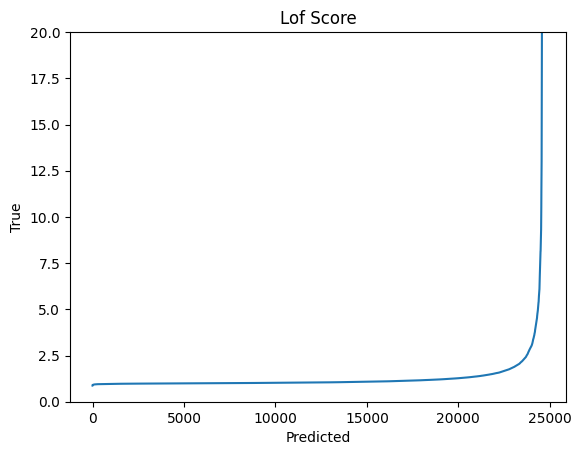

In [ ]:
plt.plot(sorted(lof_scores))
plt.title('Lof Score')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.ylim(0,20)
plt.show()
plt.close()

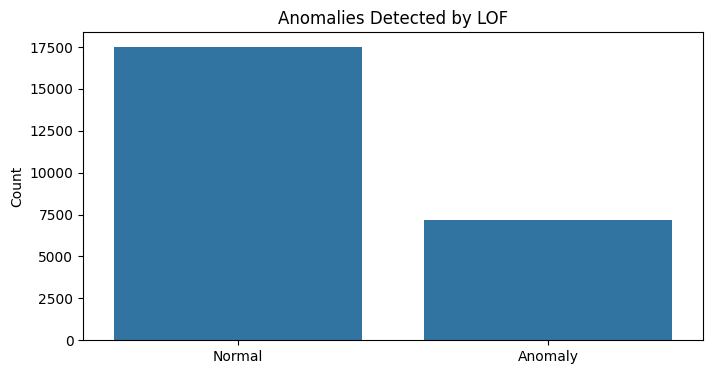

In [ ]:
# LOF labels: -1 = anomaly, 1 = normal
y_pred_binary = (y_pred == -1).astype(int)

# 6. Visualize LOF results
plt.figure(figsize=(8, 4))
sns.countplot(x=y_pred_binary)
plt.title('Anomalies Detected by LOF')
plt.xticks([0, 1], ['Normal', 'Anomaly'])
plt.ylabel('Count')
plt.show()


Classification Report (%s vs Ground Truth): LOF
              precision    recall  f1-score   support

           0       0.60      0.67      0.63     15600
           1       0.29      0.23      0.25      9057

    accuracy                           0.51     24657
   macro avg       0.44      0.45      0.44     24657
weighted avg       0.48      0.51      0.49     24657



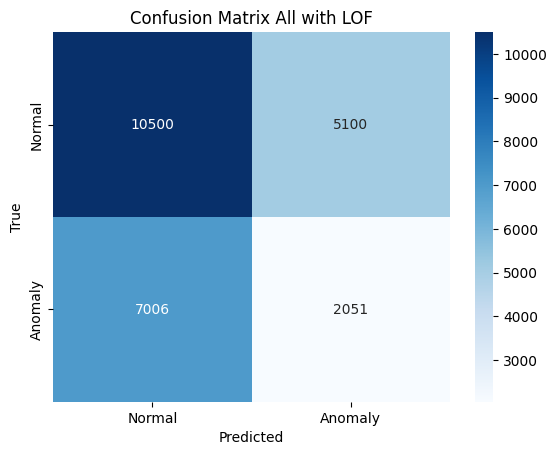

In [ ]:
plot_confusion_matrix(y_all, y_pred_binary, "LOF", "All")

In [ ]:
# Function to compute SSE (Sum of Squared Errors)
def compute_sse(X, centroids, labels):
    """
    Compute the Sum of Squared Errors (SSE) for a given clustering.

    Parameters:
    - X : ndarray of shape (n_samples, n_features)
        The input data.
    - labels : array-like of shape (n_samples,)
        Cluster labels assigned to each point. Should not contain -1.

    Returns:
    - sse : float
        The SSE (sum of squared distances to cluster centroids).
    """
    unique_labels = np.unique(labels)
    sse = 0.0

    for label in unique_labels:
        if label == -1:
            continue  # Skip noise points (e.g., in DBSCAN)
        cluster_points = X[labels == label]
        centroid = centroids[label]#cluster_points.mean(axis=0)
        sse += np.sum((cluster_points.values - centroid) ** 2)

    return sse


def compute_silhouette_details(X, labels):
    # Remove noise points if any (e.g., DBSCAN)
    mask = labels != -1
    X_clean = X[mask]
    labels_clean = labels[mask]

    # Compute overall silhouette score
    silhouette_avg = silhouette_score(X_clean, labels_clean)

    # Compute per-sample silhouette scores
    sample_silhouette_values = silhouette_samples(X_clean, labels_clean)

    # Aggregate by cluster
    cluster_silhouettes = {}
    for cluster in np.unique(labels_clean):
        cluster_silhouettes[cluster] = sample_silhouette_values[labels_clean == cluster].mean()

    return silhouette_avg, cluster_silhouettes, sample_silhouette_values


def plot_silhouette(silhouette_avg,sample_silhouette_values,cluster_labels):

    distinct_labels = set(cluster_labels)
    n_clusters = len(distinct_labels)
    if(-1 in distinct_labels):
        n_clusters -=1

    print("For n_clusters =",n_clusters,"The average silhouette_score is :",silhouette_avg)

    fig, ax = plt.subplots(figsize=(8, 6))

    y_lower = 10

    for i in range(n_clusters):

        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
        print("cluster",i,"size",len(ith_cluster_silhouette_values))
        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        # Label the silhouette plots with their cluster numbers at the middle
        ax.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples



    ax.set_title("The silhouette plot for the various clusters.")
    ax.set_xlabel("The silhouette coefficient values")
    ax.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax.set_yticks([])  # Clear the yaxis labels / ticks
    ax.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    plt.show()
    plt.close()
    return


In [ ]:
# Set number of clusters
SSE_cluster = []
N_Cluster = []
for i in range(2,20):
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans_labels = kmeans.fit_predict(X_all)
    kmeans_centers = kmeans.cluster_centers_
    SSE_cluster.append(compute_sse(X_all,kmeans_centers,kmeans_labels))
    N_Cluster.append(i)

In [ ]:
# Check how many clusters to create based on SSE score

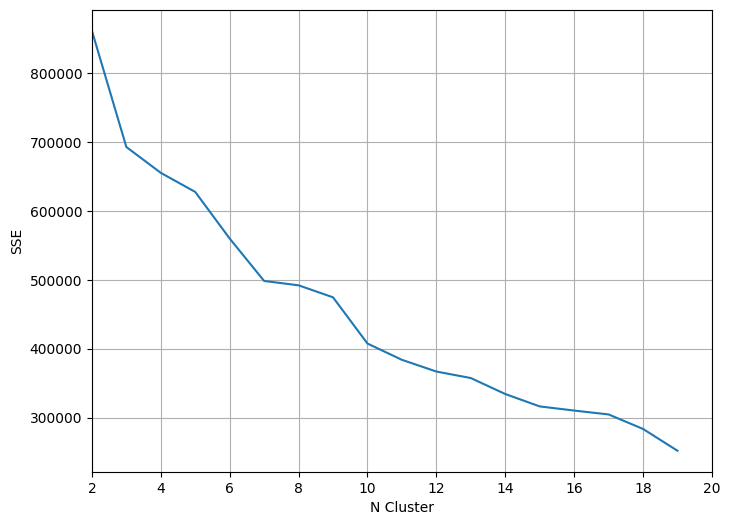

In [ ]:
fig, ax = plt.subplots(figsize=(8, 6))

ax.plot(N_Cluster,SSE_cluster)
ax.set_xlabel("N Cluster")
ax.set_ylabel("SSE")
plt.grid()
ax.set_xlim(2,20)
plt.show()
plt.close()

In [ ]:
# Use the decided number of clusters to create the clustering result

In [ ]:
# Set number of clusters
kmeans = KMeans(n_clusters=4, random_state=42)
kmeans_labels = kmeans.fit_predict(X_all)
# Get cluster labels
cluster_labels = kmeans.labels_

In [ ]:
# Check clusters based on silhouettes

K-Means SSE: 802566.52
K-Means Silhouette Score: 0.44
For n_clusters = 4 The average silhouette_score is : 0.4362111580456808
cluster 0 size 1941
cluster 1 size 16717
cluster 2 size 3595
cluster 3 size 2404


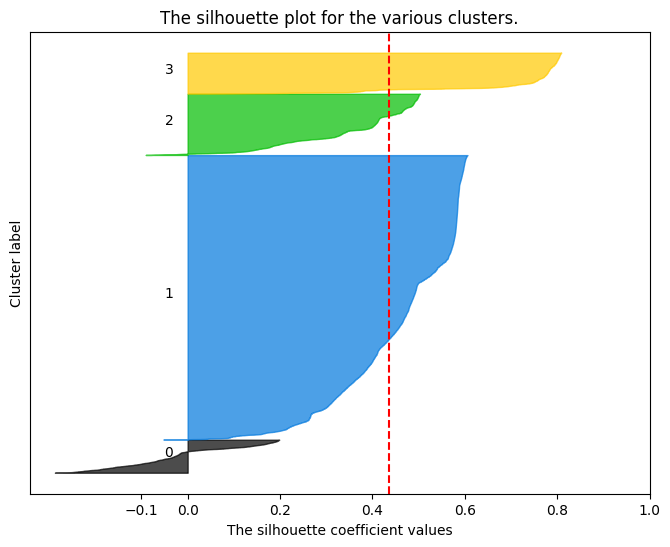

In [ ]:
sse_avg = compute_sse(X_all,kmeans_centers,kmeans_labels)
silhouette_avg, clusters_silhouettes, sample_silhouette_values = compute_silhouette_details(X_all, kmeans_labels)

print(f"K-Means SSE: {sse_avg:.2f}")
print(f"K-Means Silhouette Score: {silhouette_avg:.2f}")
plot_silhouette(silhouette_avg,sample_silhouette_values,cluster_labels)

In [ ]:
# Compute distance to assigned cluster center
_, distances_center = pairwise_distances_argmin_min(X_all, kmeans.cluster_centers_)


Classification Report (%s vs Ground Truth): K-Means
              precision    recall  f1-score   support

           0       0.65      0.96      0.77     15600
           1       0.58      0.09      0.16      9057

    accuracy                           0.64     24657
   macro avg       0.61      0.53      0.47     24657
weighted avg       0.62      0.64      0.55     24657



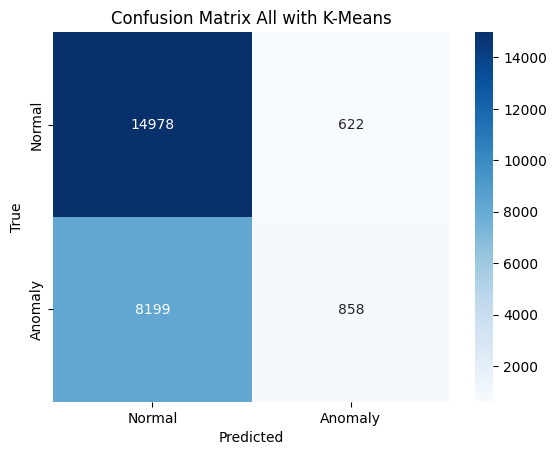

In [ ]:
# Set a threshold for anomaly 100 - anomaloues percenties
threshold = np.percentile(distances_center, 100-int(0.06*100))
y_pred_binary_kmeans = y_pred_binary_kmeans = [1 if distance > threshold else 0 for distance in distances_center]

plot_confusion_matrix(y_all, y_pred_binary_kmeans, "K-Means", "All")

In [ ]:
df_clusters = pd.DataFrame({
    "Cluster_label": kmeans_labels,
    "label": y_original_all,
    "binary_label": y_all}
)

In [ ]:
# Step 1: Group and count
label_counts = df_clusters.groupby('Cluster_label')['label'].value_counts().unstack(fill_value=0)

# Step 2: Reorder columns with 'normal' first
cols = label_counts.columns.tolist()
if 'normal' in cols:
    cols.remove('normal')
    cols = ['normal'] + cols
label_counts = label_counts[cols]

label_counts

label          normal   dos  probe  r2l
Cluster_label                          
0                1149   212    577    3
1               13793  1699   1048  177
2                 612  1371   1612    0
3                  46  2208    149    1

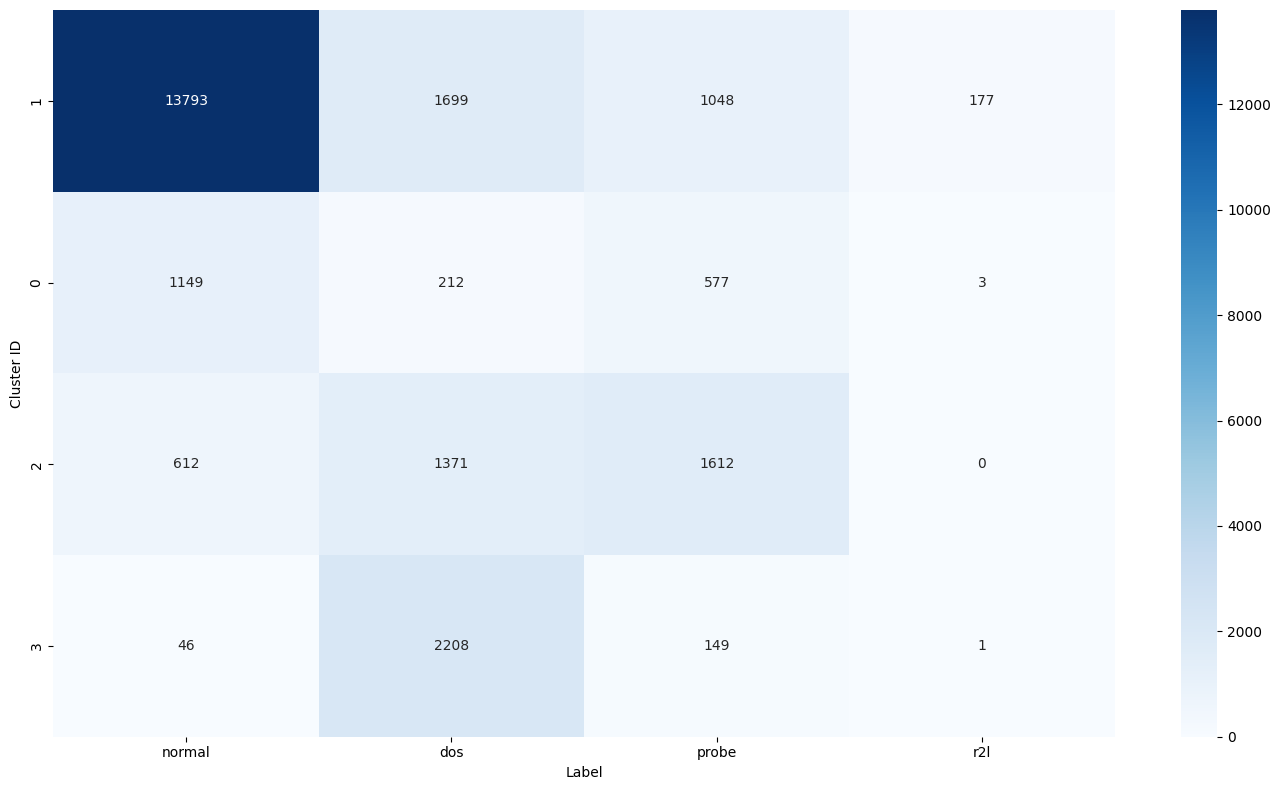

In [ ]:
plt.figure(figsize=(14, 8))
sns.heatmap(label_counts.sort_values(by="normal", ascending=False), annot=True, fmt="d", cmap="Blues", cbar=True)
plt.xlabel("Label")
plt.ylabel("Cluster ID")
plt.tight_layout()
plt.show()
plt.close()

In [ ]:
# X is your dataset (numpy array or DataFrame)
# shape: (n_samples, n_features)
nn = NearestNeighbors(n_neighbors=5, algorithm='auto', n_jobs=-1)
nn.fit(X_all)

# Compute distances to 5 nearest neighbors (including the point itself)
distances, indices = nn.kneighbors(X_all)

In [ ]:
# Distance to the 4th nearest neighbor (not counting self, which is at index 0)
fourth_neighbor_distances = distances[:, 4]  # 5th closest = 4th real neighbor
# Now fourth_neighbor_distances[i] gives you the distance of point i to its 4th neighbor

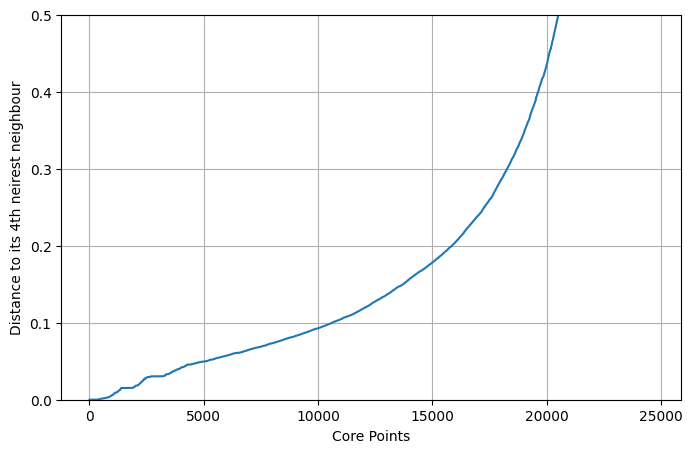

In [ ]:
# Plot explained variance ratio
plt.figure(figsize=(8, 5))
plt.plot(sorted( fourth_neighbor_distances))
plt.xlabel('Core Points')
plt.ylabel('Distance to its 4th neirest neighbour')
plt.ylim(0,0.5)
plt.grid(True)
plt.show()
plt.close()


In [ ]:
# Use DBSCAN with the epsilon and min_points previosly defined
dbscan = DBSCAN(eps=0.15, min_samples=4)
dbscan_labels = dbscan.fit_predict(X_all)


Classification Report (DBScan vs Ground Truth):
              precision    recall  f1-score   support

           0       0.58      0.59      0.59     15600
           1       0.27      0.27      0.27      9057

    accuracy                           0.47     24657
   macro avg       0.43      0.43      0.43     24657
weighted avg       0.47      0.47      0.47     24657



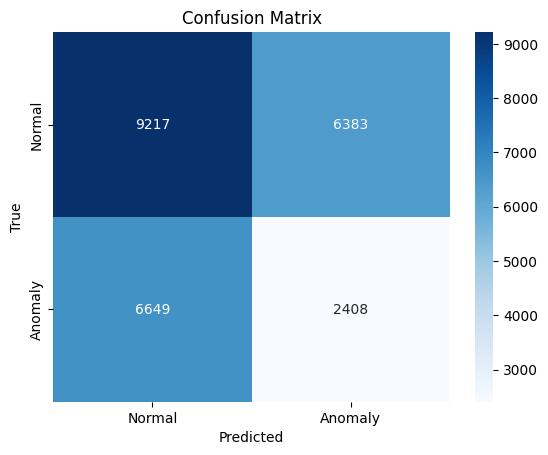

In [ ]:
y_pred_binary_dbscan = dbscan_labels = [1 if label == -1 else 0 for label in dbscan_labels]

print("\nClassification Report (DBScan vs Ground Truth):")
print(classification_report(y_all, y_pred_binary_dbscan))
# Confusion matrix
cm = confusion_matrix(y_all, y_pred_binary_dbscan)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal','Anomaly'], yticklabels=['Normal','Anomaly'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


# Task 3: Deep Anomaly Detection and Data Representation

- We can insert Deep Learning into the game for either Anomaly Detection or Data
 Representation only.

## Training and Validating Autoencoder with Normal data only:

Define an Auto Encoder architecture of your choice:

- the architecture must have a shrinking encoder and
 an expansion decoder, with a bottleneck in between.

- Use normal data only;

- split this set
 into a training and validation sets, and use the validation set to pick the best number of
 epochs and learning rate.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader, random_split

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.manifold import TSNE

In [ ]:
# ================================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader, random_split

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.manifold import TSNE

# ---------------------------
#  PRE‑PROCESSING
# ---------------------------
print("\n[Step 1] Preparing feature matrices …")
feature_cols = [c for c in df_train_preprocessed.columns if c not in ["label", "binary_label"]]
cat_bases     = ["protocol_type", "service", "flag"]
cat_dims, num_idxs = [], []

# identify one‑hot blocks & numeric indices
for base in cat_bases:
    block = [c for c in feature_cols if c.startswith(f"{base}_")]
    if block:
        s = feature_cols.index(block[0])
        cat_dims.append((s, s + len(block)))
num_cols  = [c for c in feature_cols if not any(c.startswith(f"{b}_") for b in cat_bases)]
num_idxs  = [feature_cols.index(c) for c in num_cols]

X_train_norm = df_train_preprocessed[df_train_preprocessed["binary_label"] == 0][feature_cols].values.astype(np.float32)
N_norm, D    = X_train_norm.shape
print(f"  » Normal records : {N_norm}\n  » Feature dim    : {D}\n")

# ---------------------------
#  DATA SPLIT (80 / 20)
# ---------------------------
VAL_RATIO = 0.20
n_val     = int(VAL_RATIO * N_norm)
train_ds, val_ds = random_split(
    TensorDataset(torch.from_numpy(X_train_norm)),
    [N_norm - n_val, n_val],
    generator=torch.Generator().manual_seed(42)
)

BATCH_SIZE   = 64
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False)
print(f"[Step 2] Train normals: {len(train_ds)},  Val normals: {len(val_ds)}\n")


[Step 1] Preparing feature matrices …
  » Normal records : 12102
  » Feature dim    : 53

[Step 2] Train normals: 9682,  Val normals: 2420



[Step 5] Device: cuda
 cfg(b=4, lr=0.001, ep≤20) → val=3.3323e-01
 cfg(b=4, lr=0.001, ep≤50) → val=2.4545e-01
 cfg(b=4, lr=0.001, ep≤100) → val=2.4497e-01
 cfg(b=4, lr=0.0005, ep≤20) → val=3.6645e-01
 cfg(b=4, lr=0.0005, ep≤50) → val=3.0270e-01
 cfg(b=4, lr=0.0005, ep≤100) → val=2.5726e-01
 cfg(b=4, lr=0.0001, ep≤20) → val=8.3783e-01
 cfg(b=4, lr=0.0001, ep≤50) → val=5.1562e-01
 cfg(b=4, lr=0.0001, ep≤100) → val=4.0220e-01
 cfg(b=8, lr=0.001, ep≤20) → val=3.1654e-01
 cfg(b=8, lr=0.001, ep≤50) → val=2.3541e-01
 cfg(b=8, lr=0.001, ep≤100) → val=2.3234e-01
 cfg(b=8, lr=0.0005, ep≤20) → val=3.8857e-01
 cfg(b=8, lr=0.0005, ep≤50) → val=3.0598e-01
 cfg(b=8, lr=0.0005, ep≤100) → val=2.3643e-01
 cfg(b=8, lr=0.0001, ep≤20) → val=8.1360e-01
 cfg(b=8, lr=0.0001, ep≤50) → val=5.0539e-01
 cfg(b=8, lr=0.0001, ep≤100) → val=3.6055e-01
 cfg(b=16, lr=0.001, ep≤20) → val=3.2364e-01
 cfg(b=16, lr=0.001, ep≤50) → val=2.4357e-01
 cfg(b=16, lr=0.001, ep≤100) → val=2.2296e-01
 cfg(b=16, lr=0.0005, ep≤20) → v

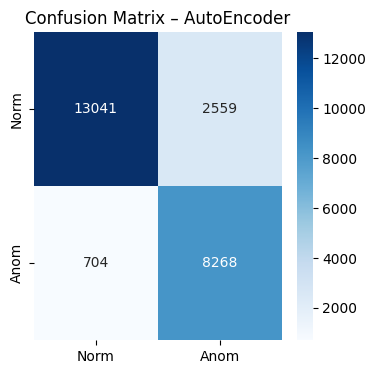

[Step 8] Evaluation …
              precision    recall  f1-score   support

           0     0.9684    0.8824    0.9234     12102
           1     0.7584    0.9277    0.8346      4815

    accuracy                         0.8953     16917
   macro avg     0.8634    0.9051    0.8790     16917
weighted avg     0.9087    0.8953    0.8981     16917



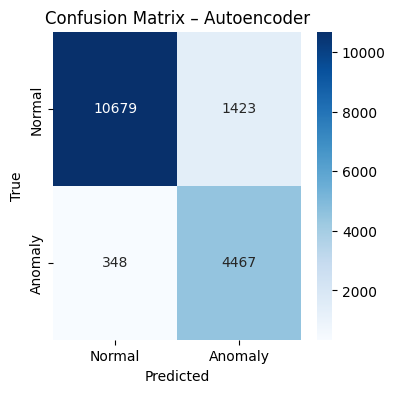

 Evaluation – test set …
              precision    recall  f1-score   support

           0     0.7942    0.5558    0.6539      2152
           1     0.7758    0.9143    0.8394      3619

    accuracy                         0.7806      5771
   macro avg     0.7850    0.7351    0.7467      5771
weighted avg     0.7827    0.7806    0.7702      5771



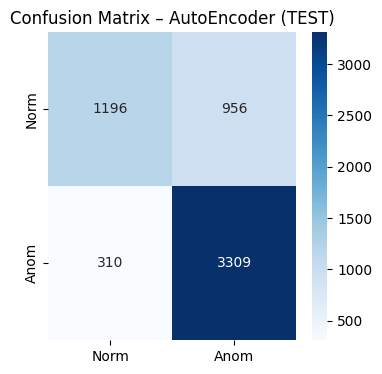

In [ ]:
# ---------------------------
#  MODEL DEFINITION
# ---------------------------
class ImprovedAutoencoder(nn.Module):
    def __init__(self, inp_dim: int, bottleneck: int = 16, p_drop: float = 0.2):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(inp_dim, 128), nn.BatchNorm1d(128), nn.ReLU(), nn.Dropout(p_drop),
            nn.Linear(128, 64),       nn.BatchNorm1d(64),  nn.ReLU(), nn.Dropout(p_drop),
            nn.Linear(64, 32),        nn.BatchNorm1d(32),  nn.ReLU(), nn.Dropout(p_drop),
            nn.Linear(32, bottleneck)
        )
        self.decoder = nn.Sequential(
            nn.Linear(bottleneck, 32), nn.BatchNorm1d(32), nn.ReLU(), nn.Dropout(p_drop),
            nn.Linear(32, 64),         nn.BatchNorm1d(64), nn.ReLU(), nn.Dropout(p_drop),
            nn.Linear(64, 128),        nn.BatchNorm1d(128),nn.ReLU(), nn.Dropout(p_drop),
            nn.Linear(128, inp_dim)
        )

    def forward(self, x):
        return self.decoder(self.encoder(x))

    def encode(self, x):
        return self.encoder(x)

# ---------------------------
# HELPER – dynamic beta for categorical CE
# ---------------------------


def mixed_ae_loss(x, xhat):
    #  Continuous part – Mean Squared Error
    mse = F.mse_loss(x[:, num_idxs], xhat[:, num_idxs], reduction='mean')
    #  Categorical part – Cross-Entropy aggregated over one-hot blocks
    ce  = torch.tensor(0.0, device=x.device)
    for s, e in cat_dims:
        tgt = torch.argmax(x[:, s:e], 1)
        ce += F.cross_entropy(xhat[:, s:e], tgt)
    return  mse +  ce

@torch.no_grad()
def per_sample_error(x, xhat):
    #  Continuous per-sample squared error
    mse = torch.mean((x[:, num_idxs] - xhat[:, num_idxs]) ** 2, dim=1)
    #  Categorical per-sample cross-entropy
    ce_vec = torch.zeros_like(mse)
    for s, e in cat_dims:
        tgt = torch.argmax(x[:, s:e], dim=1)
        ce_vec += F.cross_entropy(xhat[:, s:e], tgt, reduction='none')
    return  mse +  ce_vec

# ---------------------------
#  GRID‑SEARCH hyper‑params
# ---------------------------
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(" Device:", DEVICE)

LR_LIST, EPOCHS_LIST, BOTTLE_LIST = [1e-3, 5e-4, 1e-4], [20, 50, 100], [4, 8, 16]
PATIENCE = 10

best_val, best_cfg = np.inf, {}
for bottleneck in BOTTLE_LIST:
    for lr in LR_LIST:
        for max_ep in EPOCHS_LIST:
            model = ImprovedAutoencoder(D, bottleneck).to(DEVICE)
            opt    = optim.Adam(model.parameters(), lr=lr)
            sched  = optim.lr_scheduler.CosineAnnealingLR(opt, T_max=max_ep, eta_min=lr/100)
            best_local, stall = np.inf, 0
            for ep in range(max_ep):
                # train
                model.train()
                for (x,) in train_loader:
                    x = x.to(DEVICE)
                    opt.zero_grad()
                    loss = mixed_ae_loss(x, model(x))
                    loss.backward(); opt.step()
                sched.step()
                # val
                model.eval(); v_loss = 0.0
                with torch.no_grad():
                    for (x,) in val_loader:
                        x = x.to(DEVICE)
                        v_loss += mixed_ae_loss(x, model(x)).item() * x.size(0)
                v_loss /= len(val_loader.dataset)
                if v_loss < best_local:
                    best_local, stall = v_loss, 0
                else:
                    stall += 1
                if stall >= PATIENCE:
                    break
            if best_local < best_val:
                best_val, best_cfg = best_local, dict(bottleneck=bottleneck, lr=lr, epochs=ep+1)
            print(f" cfg(b={bottleneck}, lr={lr}, ep≤{max_ep}) → val={best_local:.4e}")
print("\n>>> BEST CONFIG", best_cfg, "valLoss=", best_val)

# ---------------------------
#  TRAIN FINAL MODEL  (only train_loader [norm only])
# ---------------------------
print(" Retraining best model on train split only …")
model = ImprovedAutoencoder(D, best_cfg['bottleneck']).to(DEVICE)
opt   = optim.Adam(model.parameters(), lr=best_cfg['lr'])
sched = optim.lr_scheduler.CosineAnnealingLR(opt, T_max=best_cfg['epochs'], eta_min=best_cfg['lr']/100)

best_val_loss, stall = np.inf, 0
for ep in range(best_cfg['epochs']):
    # train
    model.train()
    for (x,) in train_loader:
        x = x.to(DEVICE)
        opt.zero_grad(); loss = mixed_ae_loss(x, model(x)); loss.backward(); opt.step()
    sched.step()
    # hold‑out val
    model.eval(); v_loss = 0.0
    with torch.no_grad():
        for (x,) in val_loader:
            x = x.to(DEVICE); v_loss += mixed_ae_loss(x, model(x)).item() * x.size(0)
    v_loss /= len(val_loader.dataset)
    if v_loss < best_val_loss:
        best_state, best_val_loss, stall = model.state_dict(), v_loss, 0
    else:
        stall += 1
    if stall >= PATIENCE:
        break
print(f"  » finished at epoch {ep+1} | best valLoss = {best_val_loss:.5f}\n")
model.load_state_dict(best_state)
model.eval()

# ---------------------------
#  THRESHOLD (median + k·MAD) on val_loader
# ---------------------------
print("[Step 7] Threshold from validation normals …")
val_err = []
with torch.no_grad():
    for (x,) in val_loader:
        x = x.to(DEVICE)
        val_err.append(per_sample_error(x, model(x)).cpu().numpy())
val_err = np.concatenate(val_err)

med = np.median(val_err)
mad = np.median(np.abs(val_err - med))
fp_val = (val_err > (med + 6*mad)).mean()
K = 8 if fp_val > 0.03 else 6
threshold = med + K*mad

if mad == 0:          # degenerate case, fallback to 95th perc
    threshold = np.percentile(val_err, 95)
print(f"  » threshold = {threshold:.6f} (med + {K}·MAD)\n")

# in the plotted figures, the first “train all” panel contains an error; please refer to the second “train all” results as the accurate evaluation.
# ---------------------------
#  EVALUATION (train all)
# ---------------------------
print(" Evaluation …")

# 1. Prepare feature & label arrays
X_all = df_train_preprocessed[feature_cols].values.astype(np.float32)
y_all = df_train_preprocessed["binary_label"].values.astype(int)

#  Build a DataLoader over only the features
tensor_X_all = torch.from_numpy(X_all)
dataset_all  = TensorDataset(tensor_X_all)       # yields (x,) only
loader_all   = DataLoader(dataset_all,
                          batch_size=BATCH_SIZE,
                          shuffle=False)

#  Compute reconstruction errors
recon_err_list = []
model.eval()
with torch.no_grad():
    for (x_batch,) in loader_all:
        x_batch = x_batch.to(DEVICE)
        x_recon = model(x_batch)
        errs    = per_sample_error(x_batch, x_recon)   # your compute_per_sample_reconstruction_error
        recon_err_list.append(errs.cpu().numpy())

recon_err = np.concatenate(recon_err_list)

#  Threshold-based classification
y_pred = (recon_err > threshold).astype(int)

#  Metrics & confusion matrix
print(classification_report(y_all, y_pred, digits=4))

cm = confusion_matrix(y_all, y_pred)
plt.figure(figsize=(4,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Normal','Anomaly'],
            yticklabels=['Normal','Anomaly'])
plt.title('Confusion Matrix – Autoencoder')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# ---------------------------
#  EVALUATION (test)
# ---------------------------
print(" Evaluation – test set …")

#  Features and labels of the HOLD‑OUT TEST (contains anomalies)
X_test = df_test_preprocessed[feature_cols].values.astype(np.float32)
y_test = df_test_preprocessed["binary_label"].values

loader_test = DataLoader(
    TensorDataset(torch.from_numpy(X_test)),
    batch_size=BATCH_SIZE, shuffle=False)

recon_err_test = []
with torch.no_grad():
    for (x,) in loader_test:
        x = x.to(DEVICE)
        recon_err_test.append(per_sample_error(x, model(x)).cpu().numpy())
recon_err_test = np.concatenate(recon_err_test)

#  Predictions
y_pred_test = (recon_err_test > threshold).astype(int)

#  Metrics & confusion matrix
print(classification_report(y_test, y_pred_test, digits=4))
cm = confusion_matrix(y_test, y_pred_test)
plt.figure(figsize=(4,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Norm','Anom'], yticklabels=['Norm','Anom'])
plt.title('Confusion Matrix – AutoEncoder (TEST)')
plt.show()






### ECDF PLOT

Chosen threshold = 0.331958  (med + 8·MAD)


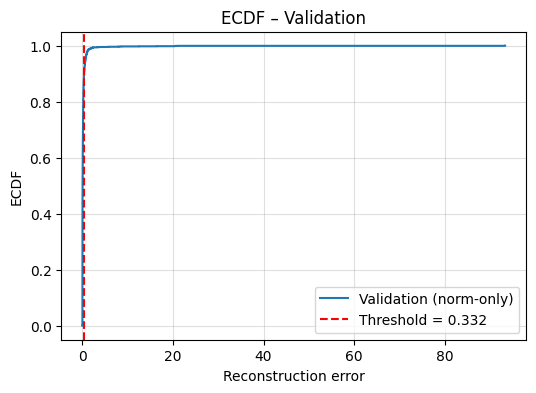

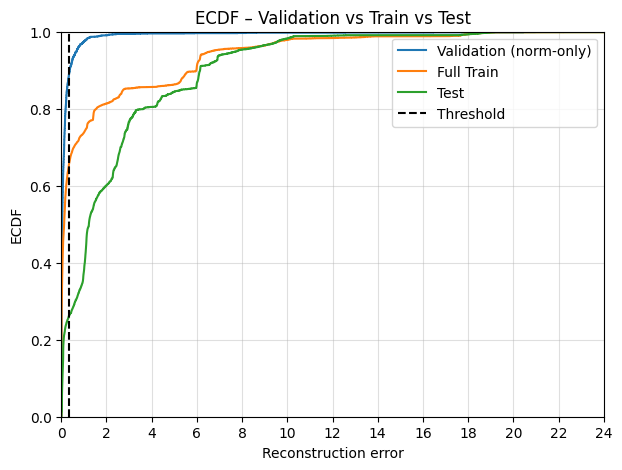

In [ ]:
# -----------------------------------------------------------------
# THRESHOLD from validation normals  +  ECDF plot
# -----------------------------------------------------------------

threshold = 0.331958
print(f"Chosen threshold = {threshold:.6f}  (med + {K}·MAD)")

# Plot ECDF for validation normals and mark threshold
sorted_val = np.sort(val_err)
ecdf_val   = np.arange(1,len(sorted_val)+1)/len(sorted_val)
plt.figure(figsize=(6,4))
plt.step(sorted_val, ecdf_val, where='post', label='Validation (norm‑only)')
plt.axvline(threshold, color='red', ls='--', label=f'Threshold = {threshold:.3f}')
plt.xlabel('Reconstruction error'); plt.ylabel('ECDF'); plt.title('ECDF – Validation')
plt.legend(); plt.grid(alpha=.4); plt.show()

# -----------------------------------------------------------------
#  ECDF curves for 3 datasets
# -----------------------------------------------------------------
# Helper to compute errors for an arbitrary NumPy matrix
def compute_errs(mat):
    loader = DataLoader(TensorDataset(torch.from_numpy(mat)), batch_size=BATCH_SIZE, shuffle=False)
    errs=[]
    with torch.no_grad():
        for (xb,) in loader:
            xb=xb.to(DEVICE); errs.append(per_sample_error(xb, model(xb)).cpu().numpy())
    return np.concatenate(errs)

X_full_train = df_train_preprocessed[feature_cols].values.astype(np.float32)
X_full_test  = df_test_preprocessed [feature_cols].values.astype(np.float32)

errs_train   = compute_errs(X_full_train)
errs_test    = compute_errs(X_full_test)

# Build ECDF curves
plt.figure(figsize=(7,5))
plt.xlim(0, 10); plt.ylim(0, 1)
plt.xticks(np.arange(0, 25, 2))
for data, label in [(val_err,'Validation (norm‑only)'),(errs_train,'Full Train'),(errs_test,'Test')]:
    s=np.sort(data); ecdf=np.arange(1,len(s)+1)/len(s)
    plt.step(s, ecdf, where='post', label=label)
plt.axvline(threshold, color='black', ls='--', label='Threshold')
plt.xlabel('Reconstruction error'); plt.ylabel('ECDF');
plt.title('ECDF – Validation vs Train vs Test'); plt.legend(); plt.grid(alpha=.4)
plt.show()


In [ ]:
# Detailed analysis of reconstruction errors
def analyze_reconstruction_errors(val_err, train_err, test_err, threshold):
    """
    Provide detailed statistical analysis of reconstruction errors.
    """
    datasets = {
        'Validation (Normal only)': val_err,
        'Full Training': train_err,
        'Test': test_err
    }

    print("=== RECONSTRUCTION ERROR ANALYSIS ===\n")

    for name, errors in datasets.items():
        print(f"{name}:")
        print(f"  Count: {len(errors)}")
        print(f"  Mean:  {np.mean(errors):.6f}")
        print(f"  Std:   {np.std(errors):.6f}")
        print(f"  Min:   {np.min(errors):.6f}")
        print(f"  Max:   {np.max(errors):.6f}")
        print(f"  Q1:    {np.percentile(errors, 25):.6f}")
        print(f"  Median:{np.median(errors):.6f}")
        print(f"  Q3:    {np.percentile(errors, 75):.6f}")
        print(f"  P95:   {np.percentile(errors, 95):.6f}")
        print(f"  P99:   {np.percentile(errors, 99):.6f}")

        # Anomaly detection performance
        anomalies = np.sum(errors > threshold)
        anomaly_rate = anomalies / len(errors) * 100
        print(f"  Anomalies detected: {anomalies} ({anomaly_rate:.2f}%)")
        print()

    # Explain why errors increase from validation to train to test
    print("=== WHY ERRORS INCREASE ===")
    print("1. Validation → Full Training:")
    print("   - Full training contains anomalies that the model hasn't seen")
    print("   - Model was trained only on normal data, so anomalies have higher reconstruction error")
    print()
    print("2. Full Training → Test:")
    print("   - Test set may have different data distribution (domain shift)")
    print("   - Test anomalies might be more diverse or severe")
    print("   - Natural dataset drift over time")

# Usage
analyze_reconstruction_errors(val_err, errs_train, errs_test, threshold)

=== RECONSTRUCTION ERROR ANALYSIS ===

Validation (Normal only):
  Count: 2420
  Mean:  0.231724
  Std:   2.112301
  Min:   0.001464
  Max:   93.366539
  Q1:    0.009508
  Median:0.041875
  Q3:    0.155613
  P95:   0.678098
  P99:   1.778601
  Anomalies detected: 278 (11.49%)

Full Training:
  Count: 16917
  Mean:  1.520136
  Std:   6.165983
  Min:   0.001464
  Max:   559.583740
  Q1:    0.012794
  Median:0.125058
  Q3:    1.128112
  P95:   6.678298
  P99:   17.664032
  Anomalies detected: 5890 (34.82%)

Test:
  Count: 5771
  Mean:  2.591524
  Std:   15.932960
  Min:   0.002463
  Max:   1178.100708
  Q1:    0.266534
  Median:1.221527
  Q3:    2.924861
  P95:   7.793940
  P99:   12.129464
  Anomalies detected: 4265 (73.90%)

=== WHY ERRORS INCREASE ===
1. Validation → Full Training:
   - Full training contains anomalies that the model hasn't seen
   - Model was trained only on normal data, so anomalies have higher reconstruction error

2. Full Training → Test:
   - Test set may have dif

## AE - OC-SVM

emb_train_norm: (12102, 16), emb_train_all: (16917, 16)
emb_val:       (1884, 16),       emb_test:       (5771, 16)
Best OC-SVM → ν=0.01, γ=0.1, F1(val)=0.570

=== OC-SVM on AE bottleneck – Train (all) ===
              precision    recall  f1-score   support

           0     0.8067    0.9902    0.8890     12102
           1     0.9423    0.4035    0.5651      4815

    accuracy                         0.8232     16917
   macro avg     0.8745    0.6968    0.7271     16917
weighted avg     0.8453    0.8232    0.7968     16917



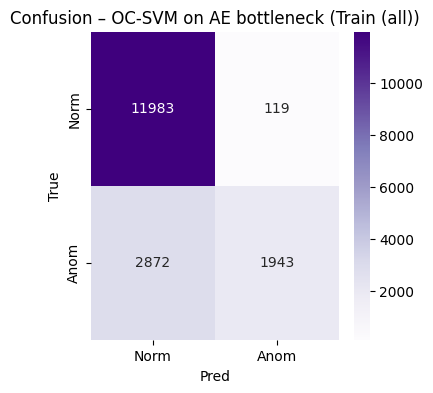


=== OC-SVM on AE bottleneck – Validation ===
              precision    recall  f1-score   support

           0     0.8074    0.9874    0.8884      1346
           1     0.9286    0.4108    0.5696       538

    accuracy                         0.8227      1884
   macro avg     0.8680    0.6991    0.7290      1884
weighted avg     0.8420    0.8227    0.7973      1884



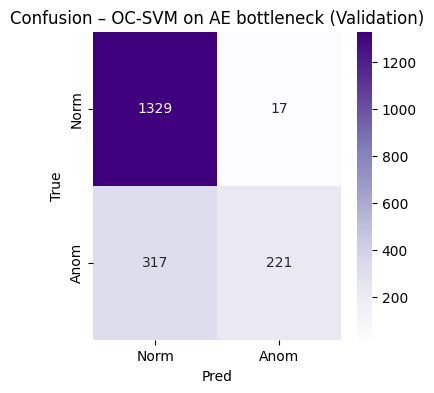


=== OC-SVM on AE bottleneck – Test ===
              precision    recall  f1-score   support

           0     0.4992    0.7509    0.5997      2152
           1     0.7885    0.5521    0.6494      3619

    accuracy                         0.6262      5771
   macro avg     0.6439    0.6515    0.6246      5771
weighted avg     0.6806    0.6262    0.6309      5771



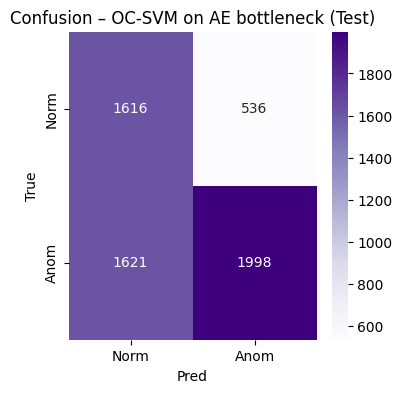

In [ ]:
from sklearn.svm import OneClassSVM
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, f1_score

# Helper to extract AE bottleneck embeddings
def get_embeddings(X_np: np.ndarray, model, device, batch_size: int = 64) -> np.ndarray:
    loader = DataLoader(TensorDataset(torch.from_numpy(X_np)),
                        batch_size=batch_size, shuffle=False)
    embs = []
    model.eval()
    with torch.no_grad():
        for (xb,) in loader:
            xb = xb.to(device)
            z  = model.encode(xb)
            embs.append(z.cpu().numpy())
    return np.vstack(embs)

# — prepare raw feature matrices
X_train_norm_np = df_train_preprocessed.loc[
    df_train_preprocessed.binary_label == 0, feature_cols
].values.astype(np.float32)
X_train_all_np  = df_train_preprocessed[feature_cols].values.astype(np.float32)
X_val_np        = df_val_preprocessed[feature_cols].values.astype(np.float32)
X_test_np       = df_test_preprocessed[feature_cols].values.astype(np.float32)

y_train_all = df_train_preprocessed.binary_label.values  # 0/1 over all train
y_val       = df_val_preprocessed.binary_label.values
y_test      = df_test_preprocessed.binary_label.values

# — extract embeddings
emb_train_norm = get_embeddings(X_train_norm_np, model, DEVICE)
emb_train_all  = get_embeddings(X_train_all_np,  model, DEVICE)
emb_val        = get_embeddings(X_val_np,        model, DEVICE)
emb_test       = get_embeddings(X_test_np,       model, DEVICE)

print(f"emb_train_norm: {emb_train_norm.shape}, emb_train_all: {emb_train_all.shape}")
print(f"emb_val:       {emb_val.shape},       emb_test:       {emb_test.shape}")

#  – scale embeddings
scaler = StandardScaler().fit(emb_train_norm)
emb_train_norm_sc = scaler.transform(emb_train_norm)
emb_train_all_sc  = scaler.transform(emb_train_all)
emb_val_sc        = scaler.transform(emb_val)
emb_test_sc       = scaler.transform(emb_test)

#  – OC-SVM grid-search on normal‐only embeddings
nu_grid    = [0.0005, 0.001, 0.002, 0.005, 0.01]
gamma_grid = [1e-4, 3e-4, 1e-3, 3e-3, 1e-2, 3e-2, 1e-1, "scale"]

best_svm, best_nu, best_gamma, best_f1 = None, None, None, -np.inf

for nu in nu_grid:
    for g in gamma_grid:
        svm = OneClassSVM(kernel="rbf", nu=nu, gamma=g).fit(emb_train_norm_sc)

        y_val_pred = (svm.predict(emb_val_sc) == -1).astype(int)
        f1 = f1_score(y_val, y_val_pred)
        if f1 > best_f1:
            best_f1, best_svm = f1, svm
            best_nu, best_gamma = nu, g

print(f"Best OC-SVM → ν={best_nu}, γ={best_gamma}, F1(val)={best_f1:.3f}")

# – Evaluation on full train / validation / test
def eval_and_plot(name, y_true, emb_sc):
    y_pred = (best_svm.predict(emb_sc) == -1).astype(int)
    print(f"\n=== OC-SVM on AE bottleneck – {name} ===")
    print(classification_report(y_true, y_pred, digits=4))
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(4,4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Purples",
                xticklabels=["Norm","Anom"], yticklabels=["Norm","Anom"])
    plt.title(f"Confusion – OC-SVM on AE bottleneck ({name})")
    plt.xlabel("Pred"); plt.ylabel("True")
    plt.show()

eval_and_plot("Train (all)",      y_train_all, emb_train_all_sc)
eval_and_plot("Validation",       y_val,         emb_val_sc)
eval_and_plot("Test",             y_test,        emb_test_sc)


=== ADDITIONAL ANALYSIS ===

1. DIMENSIONALITY ANALYSIS
   Original features: 53
   AE bottleneck: 16
   Compression ratio: 0.302

2. EMBEDDING DISTRIBUTION ANALYSIS
   Normal samples in test: 2152
   Anomaly samples in test: 3619

3. DECISION BOUNDARY ANALYSIS
   Train normal scores: mean=0.2364, std=0.5231
   Test normal scores:  mean=0.0753, std=0.5913
   Test anomaly scores: mean=0.0712, std=0.6604

4. 2D VISUALIZATION


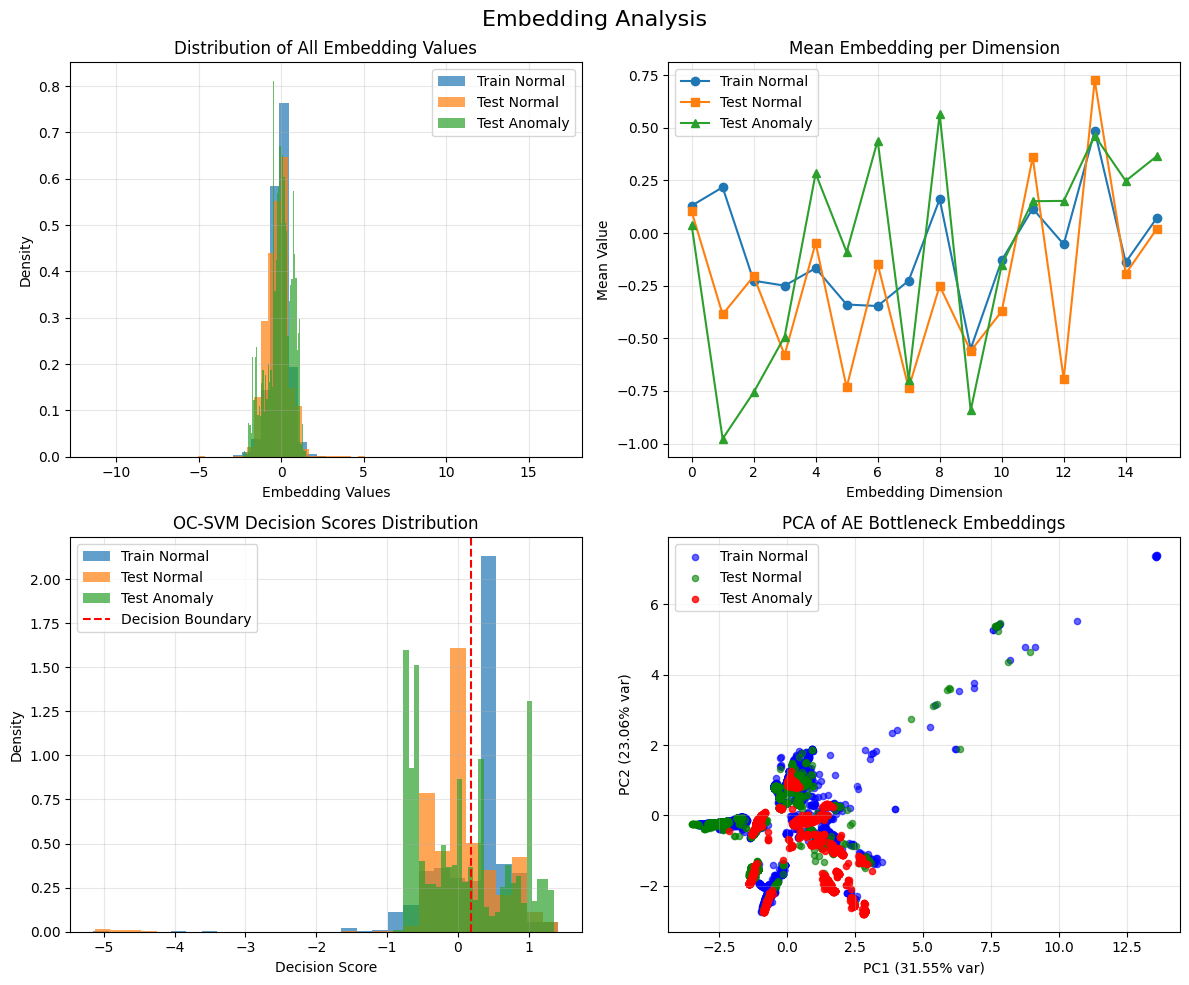

   PCA explained variance: 31.55% + 23.06% = 54.62%

5. EMBEDDING ANALYSIS
   Embedding variance per dimension:
     Dim 0: 0.1370
     Dim 1: 0.3496
     Dim 2: 0.2036
     Dim 3: 0.2358
     Dim 4: 0.3343
     Dim 5: 0.3631
     Dim 6: 0.2504
     Dim 7: 0.3611
     Dim 8: 0.4452
     Dim 9: 0.2053
     Dim 10: 0.1703
     Dim 11: 0.2170
     Dim 12: 0.5464
     Dim 13: 0.2555
     Dim 14: 0.2283
     Dim 15: 0.2610
   Most variable dimensions: [12  8  5] (higher variance often means more information)


In [ ]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import seaborn as sns

def additional_analysis(emb_train_norm, emb_test, y_test_bin, best_svm):
    """
    Additional analysis to understand the AE bottleneck approach
    """
    print("=== ADDITIONAL ANALYSIS ===\n")

    #  Dimensionality Analysis
    print("1. DIMENSIONALITY ANALYSIS")
    print(f"   Original features: {X_train_normal_only.shape[1]}")
    print(f"   AE bottleneck: {emb_train_norm.shape[1]}")
    print(f"   Compression ratio: {emb_train_norm.shape[1]/X_train_normal_only.shape[1]:.3f}")

    #  Distribution Analysis of Embeddings
    print(f"\n2. EMBEDDING DISTRIBUTION ANALYSIS")

    # Split test embeddings by true labels
    emb_test_normal = emb_test[y_test_bin == 0]
    emb_test_anomaly = emb_test[y_test_bin == 1]

    print(f"   Normal samples in test: {len(emb_test_normal)}")
    print(f"   Anomaly samples in test: {len(emb_test_anomaly)}")

    # Statistics per dimension
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    fig.suptitle('Embedding Analysis', fontsize=16)

    #  Distribution of embedding values
    ax1 = axes[0, 0]
    ax1.hist(emb_train_norm.flatten(), bins=50, alpha=0.7, label='Train Normal', density=True)
    ax1.hist(emb_test_normal.flatten(), bins=50, alpha=0.7, label='Test Normal', density=True)
    ax1.hist(emb_test_anomaly.flatten(), bins=50, alpha=0.7, label='Test Anomaly', density=True)
    ax1.set_xlabel('Embedding Values')
    ax1.set_ylabel('Density')
    ax1.set_title('Distribution of All Embedding Values')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    #  Mean embedding per dimension
    ax2 = axes[0, 1]
    dims = range(emb_train_norm.shape[1])
    ax2.plot(dims, np.mean(emb_train_norm, axis=0), 'o-', label='Train Normal')
    ax2.plot(dims, np.mean(emb_test_normal, axis=0), 's-', label='Test Normal')
    ax2.plot(dims, np.mean(emb_test_anomaly, axis=0), '^-', label='Test Anomaly')
    ax2.set_xlabel('Embedding Dimension')
    ax2.set_ylabel('Mean Value')
    ax2.set_title('Mean Embedding per Dimension')
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    #  Decision Boundary Analysis
    print(f"\n3. DECISION BOUNDARY ANALYSIS")

    # Get decision scores
    train_scores = best_svm.decision_function(emb_train_norm)
    test_scores = best_svm.decision_function(emb_test)
    test_scores_normal = test_scores[y_test_bin == 0]
    test_scores_anomaly = test_scores[y_test_bin == 1]

    print(f"   Train normal scores: mean={np.mean(train_scores):.4f}, std={np.std(train_scores):.4f}")
    print(f"   Test normal scores:  mean={np.mean(test_scores_normal):.4f}, std={np.std(test_scores_normal):.4f}")
    print(f"   Test anomaly scores: mean={np.mean(test_scores_anomaly):.4f}, std={np.std(test_scores_anomaly):.4f}")

    #  Decision scores distribution
    ax3 = axes[1, 0]
    ax3.hist(train_scores, bins=30, alpha=0.7, label='Train Normal', density=True)
    ax3.hist(test_scores_normal, bins=30, alpha=0.7, label='Test Normal', density=True)
    ax3.hist(test_scores_anomaly, bins=30, alpha=0.7, label='Test Anomaly', density=True)
    ax3.axvline(0.188868, color='red', linestyle='--', label='Decision Boundary')
    ax3.set_xlabel('Decision Score')
    ax3.set_ylabel('Density')
    ax3.set_title('OC-SVM Decision Scores Distribution')
    ax3.legend()
    ax3.grid(True, alpha=0.3)

    #  2D Visualization (PCA)
    print(f"\n4. 2D VISUALIZATION")

    # Apply PCA to embeddings for visualization
    pca = PCA(n_components=2, random_state=42)

    # Fit on training normals and transform all
    emb_all = np.vstack([emb_train_norm, emb_test])
    labels_all = np.concatenate([np.zeros(len(emb_train_norm)), y_test_bin])

    emb_2d = pca.fit_transform(emb_all)

    ax4 = axes[1, 1]

    # Plot points
    train_idx = len(emb_train_norm)
    ax4.scatter(emb_2d[:train_idx, 0], emb_2d[:train_idx, 1],
               c='blue', alpha=0.6, s=20, label='Train Normal')
    ax4.scatter(emb_2d[train_idx:][y_test_bin == 0, 0], emb_2d[train_idx:][y_test_bin == 0, 1],
               c='green', alpha=0.6, s=20, label='Test Normal')
    ax4.scatter(emb_2d[train_idx:][y_test_bin == 1, 0], emb_2d[train_idx:][y_test_bin == 1, 1],
               c='red', alpha=0.8, s=20, label='Test Anomaly')

    ax4.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} var)')
    ax4.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} var)')
    ax4.set_title('PCA of AE Bottleneck Embeddings')
    ax4.legend()
    ax4.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    print(f"   PCA explained variance: {pca.explained_variance_ratio_[0]:.2%} + {pca.explained_variance_ratio_[1]:.2%} = {pca.explained_variance_ratio_[:2].sum():.2%}")

    #  Feature importance analysis (if possible)
    print(f"\n5. EMBEDDING ANALYSIS")

    # Variance per dimension
    var_per_dim = np.var(emb_train_norm, axis=0)
    print(f"   Embedding variance per dimension:")
    for i, var in enumerate(var_per_dim):
        print(f"     Dim {i}: {var:.4f}")

    # Most informative dimensions
    top_dims = np.argsort(var_per_dim)[::-1][:3]
    print(f"   Most variable dimensions: {top_dims} (higher variance often means more information)")

    return {
        'pca_variance': pca.explained_variance_ratio_,
        'decision_scores': {
            'train_normal': train_scores,
            'test_normal': test_scores_normal,
            'test_anomaly': test_scores_anomaly
        },
        'embedding_variance': var_per_dim
    }

# Execute additional analysis
additional_results = additional_analysis(emb_train_norm, emb_test, y_test_bin, best_svm)

## PCA and OC-SVM

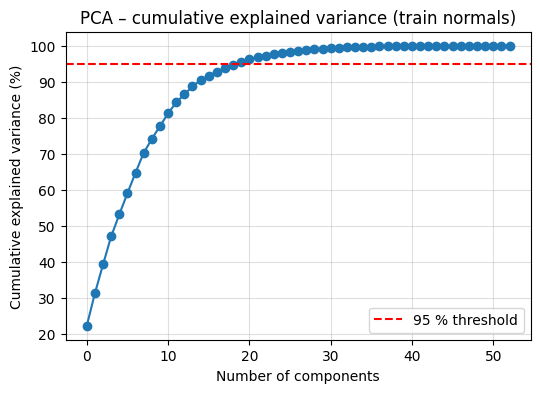

Chosen PCA components (elbow)  k = 20  → cum_var = 95.47%
OC-SVM (PCA) scelto   ν=0.005   γ=0.1   |  F1(val)=0.859

=== OC-SVM on PCA components – Test set ===
              precision    recall  f1-score   support

           0     0.7145    0.7361    0.7251      2152
           1     0.8426    0.8277    0.8351      3674

    accuracy                         0.7939      5826
   macro avg     0.7785    0.7819    0.7801      5826
weighted avg     0.7953    0.7939    0.7945      5826



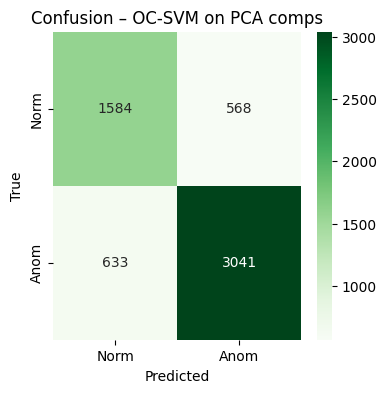

In [ ]:
# ================================================================
#  PCA → OC-SVM pipeline (normal-only train)
# ------------------------------------------------
#  1. Fit PCA on normals-only (train) and plot explained variance
#  2. Auto-detect “elbow” (first k with ≥95 % cum-var OR Δ<1 %)
#  3. Transform train-normals + test with k components
#  4. Train OC-SVM on PCA-features (normals) and evaluate on test
# ================================================================

from sklearn.decomposition import PCA
from sklearn.svm import OneClassSVM
from sklearn.metrics import classification_report, confusion_matrix

# ----------   FIT PCA on normal-only train ----------


pca_full = PCA().fit(X_train_normal_only)
           # full spectrum
cum_var  = np.cumsum(pca_full.explained_variance_ratio_) * 100   # %

# plot cumulative explained variance
plt.figure(figsize=(6,4))
plt.plot(cum_var, marker="o")
plt.axhline(95, ls="--", c="red", label="95 % threshold")
plt.xlabel("Number of components"); plt.ylabel("Cumulative explained variance (%)")
plt.title("PCA – cumulative explained variance (train normals)")
plt.grid(alpha=.4); plt.legend(); plt.show()

# ----------  elbow / k selection ----------
# heuristic: first k with cum_var ≥ 95 %  AND marginal gain < 1 %
marginal = np.diff(np.insert(cum_var, 0, 0))
k = next(i+1 for i,(cv,dv) in enumerate(zip(cum_var, marginal))
         if cv >= 95 and dv < 1)

print(f"Chosen PCA components (elbow)  k = {k}  → cum_var = {cum_var[k-1]:.2f}%")

pca   = PCA(n_components=k, random_state=42).fit(X_train_normal_only)
X_trk = pca.transform(X_train_normal_only)                 # (N_train_norm, k)

sc_pca = StandardScaler().fit(X_trk)
X_train_pca = sc_pca.transform(X_trk)


X_ts_k      = pca.transform(X_test)
X_test_pca  = sc_pca.transform(X_ts_k)


# ----------   OC-SVM on PCA-features ----------
# -------------------------------------------------------------
#   Prepara validation set (normali + anomalie)
# -------------------------------------------------------------
X_val_np   = df_val_preprocessed[feature_cols].values.astype(np.float32)
y_val_bin  = df_val_preprocessed["binary_label"].values            # 0 = norm, 1 = anom

# stesso identico pre-processing di train
X_val_pca  = sc_pca.transform(pca.transform(X_val_np))

# -------------------------------------------------------------
#   Grid-search driver by F1(val)
# -------------------------------------------------------------
from sklearn.metrics import f1_score

nu_grid    = [0.0005, 0.001, 0.002, 0.005, 0.01]
gamma_grid = [1e-4, 3e-4, 1e-3, 3e-3, 1e-2, 3e-2, 1e-1, "scale"]

best_svm, best_cfg, best_f1 = None, None, -1

for nu in nu_grid:
    for g in gamma_grid:
        svm = OneClassSVM(kernel="rbf", nu=nu, gamma=g).fit(X_train_pca)


        y_val_pred = (svm.predict(X_val_pca) == -1).astype(int)
        f1 = f1_score(y_val_bin, y_val_pred, pos_label=1)

        if f1 > best_f1:
            best_f1, best_svm, best_cfg = f1, svm, (nu, g)

print(f"OC-SVM (PCA) scelto   ν={best_cfg[0]}   γ={best_cfg[1]}   |  F1(val)={best_f1:.3f}")


# ----------   TEST evaluation ----------
y_pred_pca = (best_svm.predict(X_test_pca) == -1).astype(int)

print("\n=== OC-SVM on PCA components – Test set ===")
print(classification_report(y_test, y_pred_pca, digits=4))

cm_pca = confusion_matrix(y_test, y_pred_pca)
plt.figure(figsize=(4,4))
sns.heatmap(cm_pca, annot=True, fmt="d", cmap="Greens",
            xticklabels=["Norm","Anom"], yticklabels=["Norm","Anom"])
plt.title("Confusion – OC-SVM on PCA comps")
plt.xlabel("Predicted"); plt.ylabel("True"); plt.show()
